In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from utils import reparameterize
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.integrate import solve_ivp

In [2]:
# functions
def get_initials(L_full, lbd_spl, mu_fact, sig, Nmax_fact=2):
    Nmax = int(Nmax_fact * L_full / lbd_spl)
    n_ini = int(L_full / lbd_spl / mu_fact)

    lbd_vect = np.zeros((Nmax))
    adj_matr = np.zeros((Nmax, Nmax), dtype=int)

    # prepare initials
    for i in range(Nmax):
        if np.sum(lbd_vect) < L_full:
            lbd_vect[i] = L_full / n_ini + sig * np.random.randn()
            adj_matr[i, i+1] = 1
            adj_matr[i, i] += -1
            if i > 0:
                adj_matr[i, i-1] = 1
                adj_matr[i, i] += -1
        
        else:
            lbd_vect[i-1] = 0
            lbd_vect[i-1] = L_full - np.sum(lbd_vect)
            adj_matr[i-1, i] = 0
            adj_matr[i-1, i-1] += 1
            break
    return lbd_vect, csr_matrix(adj_matr)

def split(ind_split, lbd_vect, adj_matr):
    # single plateau
    if np.all(adj_matr.diagonal() == 0.0):
        # get another empty index
        ind_split2 = (ind_split + 1) % len(lbd_vect)

        # set lbd_vect
        split_val = 0.5 * lbd_vect[ind_split]
        for ind in [ind_split, ind_split2]:
            lbd_vect[ind] = split_val
        
        # set adj_matr
        adj_matr[ind_split, ind_split2] = adj_matr[ind_split2, ind_split] = 1
        
        adj_matr[ind_split, ind_split] = adj_matr[ind_split2, ind_split2] = -1
    else:
        # get another empty index
        ind_split2 = np.where(adj_matr.diagonal() == 0)[0][0]

        # set lbd_vect
        split_val = 0.5 * lbd_vect[ind_split]
        for ind in [ind_split, ind_split2]:
            lbd_vect[ind] = split_val
        
        # set adj_matr
        ind_neighbor = np.argmax(adj_matr[ind_split, :]) # here is the choice of insert on the left or on the right
        
        adj_matr[ind_split, ind_neighbor] = adj_matr[ind_neighbor, ind_split] = 0

        adj_matr[ind_neighbor, ind_split2] = adj_matr[ind_split2, ind_neighbor] = adj_matr[ind_split, ind_split2] = adj_matr[ind_split2, ind_split] = 1
        
        adj_matr[ind_split2, ind_split2] = -2
    return lbd_vect, adj_matr

def sparse_find_neighbors(sparse_adj_matr, node):
    return sparse_adj_matr[node].indices[sparse_adj_matr[node].data == 1]

def fix_negative(lbd_vect, adj_matr):
    while np.any(lbd_vect < 0): # here can put some constant to make it faster
        ind_negative = np.argmin(lbd_vect)
        inds_neighbors = sparse_find_neighbors(adj_matr, ind_negative) 
        if len(inds_neighbors) == 2:
            ind_neighbor1 = inds_neighbors[0]
            ind_neighbor2 = inds_neighbors[1]
            
            adj_matr[ind_neighbor1, ind_neighbor2] = 1
            adj_matr[ind_neighbor2, ind_neighbor1] = 1
            
            adj_matr[ind_neighbor1, ind_negative] = 0
            adj_matr[ind_negative, ind_neighbor1] = 0
            
            adj_matr[ind_negative, ind_neighbor2] = 0
            adj_matr[ind_neighbor2, ind_negative] = 0

            adj_matr[ind_negative, ind_negative] = 0

            lbd_vect[ind_neighbor1] += 0.5 * lbd_vect[ind_negative]
            lbd_vect[ind_neighbor2] += 0.5 * lbd_vect[ind_negative]

        elif len(inds_neighbors) == 1:
            ind_neighbor1 = inds_neighbors[0]
            
            adj_matr[ind_neighbor1, ind_negative] = 0
            adj_matr[ind_negative, ind_neighbor1] = 0
            
            adj_matr[ind_negative, ind_negative] = 0
            adj_matr[ind_neighbor1, ind_neighbor1] = -1

            lbd_vect[ind_neighbor1] += lbd_vect[ind_negative]

        else:
            raise ValueError(f"Adjacency matrix has {len(inds_neighbors)} neighbors. ")

        # set lbd_vect
        lbd_vect[ind_negative] = 0
        adj_matr[ind_negative, ind_negative] = 0

    return lbd_vect, adj_matr

def g(lbd, kappa, k, eps):
    return 0.5 * (kappa * np.exp(-k * lbd) + eps * lbd)

def rhs(lbd_vect, adj_matr, kappa, k, eps):
    return adj_matr @ g(lbd_vect, kappa, k, eps)

def step(lbd_vect, adj_matr, random_uniform, dt, kappa, k, eps, lbd_spl, r):
    # handle splitting
    potential_split_inds = np.where(lbd_vect > lbd_spl)[0]
    for i, potential_split_ind in enumerate(potential_split_inds):
        if random_uniform.get_next() < dt * r * (lbd_vect[potential_split_ind] - lbd_spl):
            lbd_vect, adj_matr = split(potential_split_ind, lbd_vect, adj_matr)
    # handle dynamics
    lbd_vect_tilde = lbd_vect + dt * rhs(lbd_vect, adj_matr, kappa, k, eps)   
    return fix_negative(lbd_vect_tilde, adj_matr)

class PrecompiledRandomGenerator:
    def __init__(self, n):
        self.n = n
        self.prepared_numbers = np.random.uniform(0, 1, n)
        self.index = 0

    def get_next(self):
        self.index += 1
        if self.index >= self.n:
            print('Reached the last prepared random number, looping back.') 
        self.index %= self.n
        return self.prepared_numbers[self.index]    

def evolve_fixed_timestep(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, stride_save, tqdm_bool=True):
    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)

    # initial conditions
    lbd_vect_ini, adj_matr_ini = get_initials(L_full, lbd_spl, mu_fact, sig)
    Nmax = len(lbd_vect_ini)
    
    # initialize variables
    t_range = np.arange(0, dt * n_steps, dt * stride_save)
    lbd_vect_t = np.zeros((Nmax, n_steps // stride_save))
    adj_matr_t = np.zeros((n_steps // stride_save), dtype=object)
    lbd_vect_t[:, 0] = lbd_vect_ini
    adj_matr_t[0] = adj_matr_ini
    lbd_vect, adj_matr = lbd_vect_ini, adj_matr_ini
    random_uniform_array = PrecompiledRandomGenerator(10_000_000)

    # evolve
    _iter = tqdm(range(1, n_steps)) if tqdm_bool else range(1, n_steps)
    for i in _iter:
        lbd_vect, adj_matr = step(lbd_vect, adj_matr, random_uniform_array,  dt, kappa, k, eps, lbd_spl, r)
        # save at some steps
        if i % stride_save == 0:
            # make sure adj matrix is sparse 
            adj_matr = csr_matrix(adj_matr.toarray())
            lbd_vect_t[:, i//stride_save] = lbd_vect
            adj_matr_t[   i//stride_save] = adj_matr
    
    return t_range, lbd_vect_t, adj_matr_t

In [3]:
# test split
lbd_vect, adj_matr = get_initials(200, 20, 0.8, 3.)
print(np.sum(lbd_vect))
print(lbd_vect)
print(adj_matr.toarray())

lbd_vect, adj_matr = split(2, lbd_vect, adj_matr)

print(np.sum(lbd_vect))
print(lbd_vect)
print(adj_matr.toarray())

200.0
[17.92262979 13.3259515  12.60280447 18.31018419 17.20604691 16.23310093
 19.39111956 17.15009771 13.67206663 19.69463861 15.77632043 18.71503927
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
[[-1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 -2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 -2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 -2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 -2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 -2  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 -2  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 -2  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 -2  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 -2  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 -2  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
 

/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [1]:
# test merge
lbd_vect, adj_matr = get_initials(200, 20, 0.8, 3.)
print(np.sum(lbd_vect))
print(lbd_vect)
print(adj_matr.toarray())

_i = 8
_val = 20
lbd_vect[_i] -= _val
lbd_vect[_i+1] += _val

print(np.sum(lbd_vect))
print(lbd_vect)
print(adj_matr.toarray())

lbd_vect, adj_matr = fix_negative(lbd_vect, adj_matr)

print(np.sum(lbd_vect))
print(lbd_vect)
print(adj_matr.toarray())


NameError: name 'get_initials' is not defined

In [5]:
# evolve (fixed dt)

# system parameters
L_full = 1000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-2  # important
r = 1e-2        # important
lbd_spl = 20.0  # important
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, argmax v_M = {lbd_max:.2f}, {lbd_spl = :.2f}')

# initial conditions
mu_fact = 0.85  # part of lbd_spl to start at
sig = 5.0       # spread
lbd_vect_ini, adj_matr_ini = get_initials(L_full, lbd_spl, mu_fact, sig)
Nmax = len(lbd_vect_ini)
print(f'Simulation supports at most {Nmax} plateaus. ')

# evolution parameters
n_steps = 1_000_000 
dt = 1e0
stride_save = 100
print(f'Evolving on [0, {n_steps * dt:.0e}] with {dt = }, saving {n_steps // stride_save} sample points. ')

t_range, lbd_vect_t, adj_matr_t = evolve_fixed_timestep(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, stride_save)

Emerging scales: lbd_spl/2 = 10.00, argmax v_M = 15.88, lbd_spl = 20.00
Simulation supports at most 100 plateaus. 
Evolving on [0, 1e+06] with dt = 1.0, saving 10000 sample points. 


100%|██████████| 999999/999999 [00:28<00:00, 34580.55it/s]


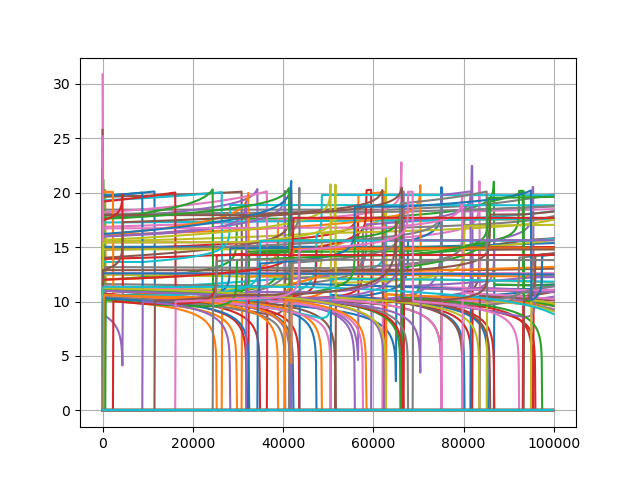

In [7]:
# plot solution 
fig, ax = plt.subplots()
assert np.all(np.isclose(np.sum(lbd_vect_t, axis=0), L_full))
for i in range(Nmax):
    ax.plot(t_range, lbd_vect_t[i, :])
ax.grid()
plt.show()

In [3]:
# evolve (fixed dt) - parameter sweep

# system parameters
L_full = 1000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
# epsilon = 1e-2  # important
r = 1e-2        # important
# lbd_spl = 20.0  # important

# initial conditions
mu_fact = 0.85  # part of lbd_spl to start at
# sig = 5.0       # spread

# evolution parameters
n_steps = 1_000_000
dt = 1e0
stride_save = 1_000

epsilon_range = np.logspace(-2, 0, 5, endpoint=True)
lbd_spl_range = np.linspace(12, 30, 7, endpoint=True)
sig_range     = [1.0, 5.0]

params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, stride_save) for lbd_spl in lbd_spl_range for epsilon in epsilon_range for sig in sig_range]

save_bool = False
for i, params in tqdm(enumerate(params_list), total=len(params_list)):
    t_range, lbd_vect_t, adj_matr_t = evolve_fixed_timestep(*params, tqdm_bool=False)
    if save_bool:
        L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, stride_save = params
        # np.save(f'evol_data/lbdvectt_{epsilon:.2e}_{lbd_spl:.2f}_{L_full:.0f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{stride_save:.0e}.npy', lbd_vect_t)
        # np.save(f'evol_data/adjmatrt_{epsilon:.2e}_{lbd_spl:.2f}_{L_full:.0f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{stride_save:.0e}.npy', adj_matr_t)


  0%|          | 0/70 [00:00<?, ?it/s]/usr/lib64/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████| 70/70 [00:07<00:00,  9.70it/s]


In [3]:
# functions - adaptive step size
from bisect import bisect_left
# number of additional arguments to conform to the solve_ivp
def dydt(t, y, adj_matr, kappa, k, eps, lbd_spl): 
    return adj_matr @ g(y, kappa, k, eps)

def g_prime(lbd, kappa, k, eps):
    return 0.5 * (-k * kappa * np.exp(-k * lbd) + eps)

def jac_dydt(t, y, adj_matr, kappa, k, eps, lbd_spl):
    return adj_matr @ np.diag(g_prime(y, kappa, k, eps))

def event_zero(t, y, adj_matr, kappa, k, eps, lbd_spl):
    return np.min(y[y != 0])

def get_event_split(included_inds, adj_matr, kappa, k, eps, lbd_spl):
    def event_split(t, y, adj_matr, kappa, k, eps, lbd_spl):
        return np.max(y[included_inds] - lbd_spl)
    
    event_split.terminal = True
    event_split.direction = 1

    return event_split

def fix_negative_adaptive(lbd_vect, adj_matr):
    while np.any(np.isclose(lbd_vect[lbd_vect != 0.0], 0.0)):
        ind_negative = np.where(np.logical_and(np.isclose(lbd_vect, 0.0), lbd_vect != 0.0))[0][0]

        inds_neighbors = sparse_find_neighbors(adj_matr, ind_negative) 
        if len(inds_neighbors) == 2:
            ind_neighbor1 = inds_neighbors[0]
            ind_neighbor2 = inds_neighbors[1]
            
            adj_matr[ind_neighbor1, ind_neighbor2] = adj_matr[ind_neighbor2, ind_neighbor1] = 1
            
            adj_matr[ind_neighbor1, ind_negative] = adj_matr[ind_negative, ind_neighbor1] = adj_matr[ind_negative, ind_neighbor2] = adj_matr[ind_neighbor2, ind_negative] = 0

            adj_matr[ind_negative, ind_negative] = 0

            lbd_vect[ind_neighbor1] += 0.5 * lbd_vect[ind_negative]
            lbd_vect[ind_neighbor2] += 0.5 * lbd_vect[ind_negative]

        elif len(inds_neighbors) == 1:
            ind_neighbor1 = inds_neighbors[0]
            
            adj_matr[ind_neighbor1, ind_negative] = adj_matr[ind_negative, ind_neighbor1] = 0
            
            adj_matr[ind_negative, ind_negative] = 0
            adj_matr[ind_neighbor1, ind_neighbor1] += 1

            lbd_vect[ind_neighbor1] += lbd_vect[ind_negative]

        elif len(inds_neighbors) == 0:            
            adj_matr[ind_negative, ind_negative] = 0

        else:
            raise ValueError(f"Adjacency matrix has {len(inds_neighbors)} neighbors. ")

        # set lbd_vect
        lbd_vect[ind_negative] = 0
        adj_matr[ind_negative, ind_negative] = 0

    return lbd_vect, adj_matr

event_zero.terminal = True
event_zero.direction = -1

def insert_sorted(arr, element):
    # Find the position where the element should be inserted
    position = bisect_left(arr, element)
    
    # Insert the element at the found position
    return np.insert(arr, position, element)
    
def insert_sorted2(arr, element, arr2, element2):
    # Find the position where the element should be inserted
    position = bisect_left(arr, element)
    
    # Insert the element at the found position
    arr.insert(position, element)
    arr2.insert(position, element2)
    
    return arr, arr2

def evolve_adapt_timestep(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, verbose=False, tqdm_bool=True, maxiter=1000, Nmax_fact=2):
    
    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
    # initial conditions
    lbd_vect_ini, adj_matr_ini = get_initials(L_full, lbd_spl, mu_fact, sig, Nmax_fact=Nmax_fact)
    # presplit
    if verbose: print('Presplitting ...')
    while np.any(lbd_vect_ini > lbd_spl):
        lbd_vect_ini, adj_matr_ini = split(np.where(lbd_vect_ini > lbd_spl)[0][0], lbd_vect_ini, adj_matr_ini)
    # make sure all positive
    while np.any(lbd_vect_ini < 0):
        lbd_vect_ini, adj_matr_ini = fix_negative(lbd_vect_ini, adj_matr_ini)

    Nmax = len(lbd_vect_ini)

    # initialize variables
    t_range = np.arange(0, dt * n_steps, dt)
    lbd_vect_t = np.zeros((Nmax, n_steps))
    adj_matr_t = np.zeros((n_steps), dtype=object)
    lbd_vect_t[:, 0] = lbd_vect_ini
    adj_matr_t[0] = adj_matr_ini

    lbd_vect, adj_matr = lbd_vect_ini, adj_matr_ini
    random_uniform = PrecompiledRandomGenerator(100_000)

    # initialize loop variables
    time_current = 0.0
    ind_current_lo = 0
    ind_current_hi = n_steps
        
    split_times_queue = [n_steps * dt]
    split_index_queue = [None]

    included_inds = np.arange(stop=len(lbd_vect), dtype=int)
    finished_bool = False
    
    _iter = tqdm(range(maxiter), desc='Worst case timer: ') if tqdm_bool else range(maxiter)
    for _counter in _iter:
        # check if finished
        if finished_bool:
            break

        if _counter == 0:
            t_eval_current = t_range
        else:
            # insert current time to evaluation array to ensure potential event occurs on the evaluated interval
            t_eval_current = np.insert(t_range[ind_current_lo:ind_current_hi], 0, time_current)
            if split_index_queue[0] != None:
                # insert last split time to know the initial condition for next steps
                t_eval_current = np.append(t_eval_current, split_times_queue[0])

        if verbose: print(f'# active: {np.sum(lbd_vect > 0)}')
        
        # evolve and (maybe) be interrupted 
        sol = solve_ivp(dydt, 
                        t_span=(time_current, split_times_queue[0]), 
                        y0=lbd_vect, 
                        method='BDF',
                        t_eval=t_eval_current, 
                        events=[event_zero, get_event_split(included_inds, adj_matr, kappa, k, eps, lbd_spl)], 
                        args=(adj_matr, kappa, k, eps, lbd_spl),
                        jac=jac_dydt,
                        rtol=1e-6) # also can help: max_step (parameter)
        
        if len(sol.y_events[0] > 0): # merging event
            # save
            lbd_vect_t[:, ind_current_lo:int(sol.t_events[0][0] / dt) + 1] = sol.y[:, min(_counter, 1):]
            adj_matr_t[ind_current_lo:int(sol.t_events[0][0] / dt) + 1] = adj_matr

            # update timing
            time_current = sol.t_events[0][0]
            ind_current_lo = int(time_current / dt) + 1

            if verbose: print(f'Interrupted by negative at {time_current = :.1f}')
            
            # perform merge
            lbd_vect, adj_matr = fix_negative_adaptive(sol.y_events[0][0], adj_matr)
            adj_matr = csr_matrix(adj_matr.toarray())

        elif len(sol.y_events[1] > 0): # split threshold reached
            # save
            lbd_vect_t[:, ind_current_lo:int(sol.t_events[1][0] / dt) + 1] = sol.y[:, min(_counter, 1):]
            adj_matr_t[ind_current_lo:int(sol.t_events[1][0] / dt) + 1] = adj_matr
            
            # update timing
            time_current = sol.t_events[1][0]
            ind_current_lo = int(time_current / dt) + 1

            # determine where split happened
            lbd_vect = sol.y_events[1][0]
            split_index = np.argmin(np.abs(lbd_vect - lbd_spl))
            
            # exclude the split index from split monitoring
            included_inds = np.delete(included_inds, np.where(included_inds == split_index)[0][0])
                
            # sample time-to-split: inv_P(uniform) is a sampled time-to-split (approx)
            dLambdadt = dydt(0.0, lbd_vect, adj_matr, kappa, k, eps, lbd_spl)[split_index] 
            split_time = time_current +  np.sqrt(-2 / r / dLambdadt * np.log(1 - random_uniform.get_next()))
            
            # add time and split index to split queues
            split_times_queue, split_index_queue = insert_sorted2(split_times_queue, split_time, split_index_queue, split_index)
            if verbose: print(f'Interrupted by split at {time_current = :.1f}, {split_index = }, sampled new split time: {split_time:.2f}')
            
            # update first expected time of split
            ind_current_hi = int(split_times_queue[0] / dt) + 1
            # make sure we will cross it
            lbd_vect[split_index] += 1e-6
        
        else:
            if split_index_queue[0] != None: # splitting time reached
                if verbose: print('Integrated until split time')
                # save
                lbd_vect_t[:, ind_current_lo:ind_current_hi] = sol.y[:, min(_counter, 1):-1]
                adj_matr_t[ind_current_lo:ind_current_hi] = adj_matr

                # perform split
                split_index = split_index_queue.pop(0)
                lbd_vect, adj_matr = split(split_index, sol.y[:, -1], adj_matr)
                adj_matr = csr_matrix(adj_matr.toarray())
                
                # include the split index to split monitoring
                included_inds = insert_sorted(included_inds, split_index)

                # remove time from split queue, update times and indices
                time_current = split_times_queue.pop(0)
                ind_current_lo = int(time_current / dt) + 1
                ind_current_hi = int(split_times_queue[0] / dt) + 1

            else: # final time reached
                if verbose: print('Finishing up.')
                # save
                lbd_vect_t[:, ind_current_lo:ind_current_hi] = sol.y[:, min(_counter, 1):]
                adj_matr_t[ind_current_lo:ind_current_hi] = adj_matr

                finished_bool = True

        _counter += 1
        if verbose: print(f'excluded indices: {[item for item in np.arange(stop=len(lbd_vect), dtype=int) if item not in included_inds]}')
    
    return t_range, lbd_vect_t, adj_matr_t

In [112]:
# evolve (adapt dt)
# system parameters
L_full = 20.0   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
lbd_spl = 9.0  # important
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, argmax v_M = {lbd_max:.2f}, {lbd_spl = :.2f}')

# initial conditions
mu_fact = 1/2  # part of lbd_spl to start at
sig = 0.1       # spread
# lbd_vect_ini, adj_matr_ini = get_initials(L_full, lbd_spl, mu_fact, sig, Nmax_fact=8)
# print(lbd_vect_ini)
# print(adj_matr_ini)

# # evolution parameters
n_steps = 100_000
dt = 1e0
print(f'Evolving on [0, {n_steps * dt:.0e}] with {dt = }, saving {n_steps} sample points. ')

np.random.seed(0)

t_range, lbd_vect_t, adj_matr_t = evolve_adapt_timestep(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt, Nmax_fact=10)

Emerging scales: lbd_spl/2 = 4.50, argmax v_M = 13.58, lbd_spl = 9.00
Evolving on [0, 1e+05] with dt = 1.0, saving 100000 sample points. 


Worst case timer:   0%|          | 0/1000 [00:00<?, ?it/s]/home/natan/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
Worst case timer:  83%|████████▎ | 827/1000 [00:08<00:01, 93.40it/s]


In [113]:
# plot solution 
fig, ax = plt.subplots()
# assert np.all(np.isclose(np.sum(lbd_vect_t, axis=0), L_full))
Nmax = np.shape(lbd_vect_t)[0]
for i in range(min(Nmax, 60)):
    # ax.plot(t_range, np.abs(lbd_vect_t[i, :]-lbd_vect_t[i, 0]))
    ax.plot(t_range, lbd_vect_t[i, :])
# ax.plot(t_range, np.sum(lbd_vect_t, axis=0))
ax.grid()
# ax.set_xscale('log')
# ax.set_yscale('log')
print(len(np.where(np.any(lbd_vect_t > 0.001, axis = 1))[0]))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

4


In [56]:
plt.close('all')

In [43]:
# evolve (fixed dt) - parameter sweep

# system parameters
L_full = 1_000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
# lbd_spl = 20.0  # important

# initial conditions
mu_fact = 0.95  # part of lbd_spl to start at
sig = 8.0       # spread

# evolution parameters
n_steps = 1_000
dt = 1e4        # true dt is now adaptive. saving only at multiples of dt

kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lower_stab = -1/k * np.log(eps / k / kappa)
# print(f'{lower_stab = }')
lbd_spl_range = np.linspace(lower_stab + 6, lower_stab + 10, 20, endpoint=True)

# lbd_spl_range = np.linspace(12, 30, 7, endpoint=True)
# sig_range     = [1.0, 5.0]

# params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for sig in sig_range]
params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range]

num_repeat = 100

save_bool = True
for i, params in tqdm(enumerate(params_list), total=len(params_list)):
    for j in range(num_repeat):
        print(f'{i + 1} / {len(params_list)}, {j + 1} / {num_repeat}')
        np.random.seed(j)
        t_range, lbd_vect_t, adj_matr_t = evolve_adapt_timestep(*params, tqdm_bool=True, maxiter=5_000)
        if save_bool:
            L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt = params
            np.save(f'SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy', lbd_vect_t)
            np.save(f'SIP_data/adjmatrtA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy', adj_matr_t)
            # np.save(f'/scratch/n/Natan.Dominko/SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy', lbd_vect_t)
            # np.save(f'/scratch/n/Natan.Dominko/SIP_data/adjmatrtA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy', adj_matr_t)


  0%|          | 0/20 [00:00<?, ?it/s]/home/natan/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


1 / 20, 1 / 100


Worst case timer:   6%|▋         | 320/5000 [00:09<02:12, 35.40it/s]


1 / 20, 2 / 100


Worst case timer:   2%|▏         | 108/5000 [00:04<03:05, 26.42it/s]


1 / 20, 3 / 100


Worst case timer:   6%|▌         | 290/5000 [00:08<02:16, 34.54it/s]


1 / 20, 4 / 100


Worst case timer:   6%|▌         | 298/5000 [00:13<03:38, 21.54it/s]


1 / 20, 5 / 100


Worst case timer:   8%|▊         | 386/5000 [00:11<02:15, 34.09it/s]


1 / 20, 6 / 100


Worst case timer:  18%|█▊        | 904/5000 [00:27<02:02, 33.33it/s]


1 / 20, 7 / 100


Worst case timer:  12%|█▏        | 624/5000 [00:20<02:21, 30.90it/s]


1 / 20, 8 / 100


Worst case timer:  11%|█         | 554/5000 [00:16<02:12, 33.46it/s]


1 / 20, 9 / 100


Worst case timer:  26%|██▌       | 1278/5000 [00:39<01:55, 32.22it/s]


1 / 20, 10 / 100


Worst case timer:   9%|▉         | 468/5000 [00:15<02:34, 29.35it/s]


1 / 20, 11 / 100


Worst case timer:  15%|█▌        | 766/5000 [00:21<02:00, 35.04it/s]


1 / 20, 12 / 100


Worst case timer:   4%|▍         | 191/5000 [00:09<03:58, 20.17it/s]


1 / 20, 13 / 100


Worst case timer:  15%|█▍        | 735/5000 [00:21<02:02, 34.77it/s]


1 / 20, 14 / 100


Worst case timer:  25%|██▌       | 1259/5000 [00:46<02:18, 27.00it/s]


1 / 20, 15 / 100


Worst case timer:   7%|▋         | 349/5000 [00:10<02:19, 33.33it/s]


1 / 20, 16 / 100


Worst case timer:  14%|█▍        | 689/5000 [00:21<02:16, 31.66it/s]


1 / 20, 17 / 100


Worst case timer:  33%|███▎      | 1649/5000 [01:15<02:33, 21.82it/s]


1 / 20, 18 / 100


Worst case timer:   6%|▌         | 275/5000 [00:10<02:51, 27.48it/s]


1 / 20, 19 / 100


Worst case timer:  16%|█▋        | 816/5000 [00:35<03:02, 22.92it/s]


1 / 20, 20 / 100


Worst case timer:   9%|▉         | 472/5000 [00:18<02:53, 26.09it/s]


1 / 20, 21 / 100


Worst case timer:  22%|██▏       | 1107/5000 [00:45<02:41, 24.10it/s]


1 / 20, 22 / 100


Worst case timer:   8%|▊         | 417/5000 [00:14<02:38, 28.98it/s]


1 / 20, 23 / 100


Worst case timer:   8%|▊         | 423/5000 [00:13<02:24, 31.62it/s]


1 / 20, 24 / 100


Worst case timer:  12%|█▏        | 596/5000 [00:15<01:57, 37.61it/s]


1 / 20, 25 / 100


Worst case timer:   5%|▌         | 270/5000 [00:08<02:22, 33.17it/s]


1 / 20, 26 / 100


Worst case timer:  16%|█▌        | 794/5000 [00:23<02:02, 34.37it/s]


1 / 20, 27 / 100


Worst case timer:  12%|█▏        | 578/5000 [00:16<02:06, 35.01it/s]


1 / 20, 28 / 100


Worst case timer:  23%|██▎       | 1173/5000 [00:31<01:42, 37.25it/s]


1 / 20, 29 / 100


Worst case timer:   5%|▍         | 227/5000 [00:05<01:53, 42.00it/s]


1 / 20, 30 / 100


Worst case timer:   6%|▋         | 313/5000 [00:07<01:45, 44.43it/s]


1 / 20, 31 / 100


Worst case timer:  12%|█▏        | 576/5000 [00:13<01:45, 42.10it/s]


1 / 20, 32 / 100


Worst case timer:   7%|▋         | 333/5000 [00:07<01:42, 45.74it/s]


1 / 20, 33 / 100


Worst case timer:  25%|██▍       | 1248/5000 [00:28<01:25, 43.78it/s]


1 / 20, 34 / 100


Worst case timer:   3%|▎         | 141/5000 [00:03<02:00, 40.45it/s]


1 / 20, 35 / 100


Worst case timer:   7%|▋         | 331/5000 [00:09<02:11, 35.63it/s]


1 / 20, 36 / 100


Worst case timer:   3%|▎         | 126/5000 [00:03<02:08, 38.06it/s]


1 / 20, 37 / 100


Worst case timer:   3%|▎         | 141/5000 [00:03<01:55, 42.13it/s]


1 / 20, 38 / 100


Worst case timer:   6%|▌         | 277/5000 [00:10<03:06, 25.31it/s]


1 / 20, 39 / 100


Worst case timer:   9%|▉         | 439/5000 [00:13<02:24, 31.63it/s]


1 / 20, 40 / 100


Worst case timer:  16%|█▋        | 816/5000 [00:18<01:34, 44.22it/s]


1 / 20, 41 / 100


Worst case timer:  38%|███▊      | 1889/5000 [00:41<01:07, 45.89it/s]


1 / 20, 42 / 100


Worst case timer:  15%|█▍        | 730/5000 [00:16<01:35, 44.72it/s]


1 / 20, 43 / 100


Worst case timer:  14%|█▎        | 687/5000 [00:17<01:51, 38.75it/s]


1 / 20, 44 / 100


Worst case timer:   2%|▏         | 107/5000 [00:03<02:29, 32.75it/s]


1 / 20, 45 / 100


Worst case timer:   6%|▋         | 325/5000 [00:09<02:14, 34.86it/s]


1 / 20, 46 / 100


Worst case timer:  15%|█▍        | 737/5000 [00:38<03:41, 19.22it/s]


1 / 20, 47 / 100


Worst case timer:   5%|▌         | 254/5000 [00:07<02:28, 31.91it/s]


1 / 20, 48 / 100


Worst case timer:   7%|▋         | 351/5000 [00:16<03:33, 21.78it/s]


1 / 20, 49 / 100


Worst case timer:   5%|▍         | 227/5000 [00:07<02:36, 30.45it/s]


1 / 20, 50 / 100


Worst case timer:   9%|▉         | 442/5000 [00:13<02:18, 32.91it/s]


1 / 20, 51 / 100


Worst case timer:  10%|█         | 502/5000 [00:15<02:21, 31.90it/s]


1 / 20, 52 / 100


Worst case timer:   9%|▊         | 430/5000 [00:11<02:06, 36.05it/s]


1 / 20, 53 / 100


Worst case timer:   8%|▊         | 409/5000 [00:12<02:17, 33.48it/s]


1 / 20, 54 / 100


Worst case timer:   7%|▋         | 344/5000 [00:09<02:07, 36.55it/s]


1 / 20, 55 / 100


Worst case timer:  20%|█▉        | 992/5000 [00:27<01:52, 35.57it/s]


1 / 20, 56 / 100


Worst case timer:  14%|█▎        | 679/5000 [00:21<02:15, 31.99it/s]


1 / 20, 57 / 100


Worst case timer:   9%|▊         | 426/5000 [00:12<02:15, 33.72it/s]


1 / 20, 58 / 100


Worst case timer:   9%|▉         | 453/5000 [00:12<02:06, 35.93it/s]


1 / 20, 59 / 100


Worst case timer:  19%|█▉        | 949/5000 [00:24<01:46, 38.09it/s]


1 / 20, 60 / 100


Worst case timer:  12%|█▏        | 617/5000 [00:17<02:02, 35.66it/s]


1 / 20, 61 / 100


Worst case timer:  14%|█▍        | 723/5000 [00:19<01:55, 37.16it/s]


1 / 20, 62 / 100


Worst case timer:   7%|▋         | 336/5000 [00:09<02:08, 36.38it/s]


1 / 20, 63 / 100


Worst case timer:  12%|█▏        | 587/5000 [00:15<01:55, 38.08it/s]


1 / 20, 64 / 100


Worst case timer:  11%|█         | 554/5000 [00:17<02:20, 31.64it/s]


1 / 20, 65 / 100


Worst case timer:   5%|▍         | 235/5000 [00:09<03:17, 24.12it/s]


1 / 20, 66 / 100


Worst case timer:   4%|▍         | 212/5000 [00:09<03:33, 22.39it/s]


1 / 20, 67 / 100


Worst case timer:   9%|▉         | 451/5000 [00:14<02:28, 30.53it/s]


1 / 20, 68 / 100


Worst case timer:  13%|█▎        | 668/5000 [00:18<02:01, 35.72it/s]


1 / 20, 69 / 100


Worst case timer:  18%|█▊        | 908/5000 [00:25<01:55, 35.52it/s]


1 / 20, 70 / 100


Worst case timer:   9%|▊         | 426/5000 [00:12<02:19, 32.86it/s]


1 / 20, 71 / 100


Worst case timer:   7%|▋         | 338/5000 [00:10<02:25, 32.09it/s]


1 / 20, 72 / 100


Worst case timer:  22%|██▏       | 1083/5000 [00:32<01:55, 33.80it/s]


1 / 20, 73 / 100


Worst case timer:   9%|▉         | 438/5000 [00:12<02:13, 34.24it/s]


1 / 20, 74 / 100


Worst case timer:   9%|▉         | 448/5000 [00:14<02:23, 31.63it/s]


1 / 20, 75 / 100


Worst case timer:  20%|██        | 1022/5000 [00:29<01:53, 34.91it/s]


1 / 20, 76 / 100


Worst case timer:   4%|▍         | 202/5000 [00:07<02:50, 28.21it/s]


1 / 20, 77 / 100


Worst case timer:  26%|██▌       | 1306/5000 [00:39<01:51, 33.23it/s]


1 / 20, 78 / 100


Worst case timer:  21%|██        | 1056/5000 [00:32<02:00, 32.73it/s]


1 / 20, 79 / 100


Worst case timer:  10%|█         | 507/5000 [00:11<01:39, 45.00it/s]


1 / 20, 80 / 100


Worst case timer:   9%|▉         | 457/5000 [00:09<01:39, 45.72it/s]


1 / 20, 81 / 100


Worst case timer:  11%|█         | 529/5000 [00:11<01:35, 46.93it/s]


1 / 20, 82 / 100


Worst case timer:  27%|██▋       | 1349/5000 [00:28<01:15, 48.16it/s]


1 / 20, 83 / 100


Worst case timer:   3%|▎         | 158/5000 [00:03<01:54, 42.41it/s]


1 / 20, 84 / 100


Worst case timer:   8%|▊         | 393/5000 [00:08<01:39, 46.29it/s]


1 / 20, 85 / 100


Worst case timer:   7%|▋         | 336/5000 [00:07<01:38, 47.47it/s]


1 / 20, 86 / 100


Worst case timer:   9%|▊         | 434/5000 [00:09<01:35, 48.03it/s]


1 / 20, 87 / 100


Worst case timer:  11%|█         | 538/5000 [00:14<01:56, 38.20it/s]


1 / 20, 88 / 100


Worst case timer:   9%|▉         | 453/5000 [00:11<01:51, 40.79it/s]


1 / 20, 89 / 100


Worst case timer:   8%|▊         | 398/5000 [00:09<01:47, 42.66it/s]


1 / 20, 90 / 100


Worst case timer:  10%|▉         | 498/5000 [00:11<01:42, 43.92it/s]


1 / 20, 91 / 100


Worst case timer:  12%|█▏        | 578/5000 [00:12<01:37, 45.50it/s]


1 / 20, 92 / 100


Worst case timer:  10%|█         | 506/5000 [00:10<01:30, 49.39it/s]


1 / 20, 93 / 100


Worst case timer:  11%|█         | 560/5000 [00:12<01:37, 45.34it/s]


1 / 20, 94 / 100


Worst case timer:  13%|█▎        | 639/5000 [00:14<01:35, 45.64it/s]


1 / 20, 95 / 100


Worst case timer:  22%|██▏       | 1116/5000 [00:24<01:23, 46.47it/s]


1 / 20, 96 / 100


Worst case timer:  11%|█         | 558/5000 [00:12<01:39, 44.47it/s]


1 / 20, 97 / 100


Worst case timer:   6%|▌         | 280/5000 [00:06<01:49, 43.15it/s]


1 / 20, 98 / 100


Worst case timer:  12%|█▏        | 601/5000 [00:12<01:30, 48.49it/s]


1 / 20, 99 / 100


Worst case timer:  27%|██▋       | 1351/5000 [00:27<01:15, 48.47it/s]


1 / 20, 100 / 100


  5%|▌         | 1/20 [27:56<8:51:02, 1676.99s/it]

2 / 20, 1 / 100


Worst case timer:   7%|▋         | 350/5000 [00:07<01:43, 45.13it/s]


2 / 20, 2 / 100


Worst case timer:   4%|▍         | 210/5000 [00:04<01:50, 43.18it/s]


2 / 20, 3 / 100


Worst case timer:   3%|▎         | 151/5000 [00:03<01:57, 41.11it/s]


2 / 20, 4 / 100


Worst case timer:   5%|▌         | 262/5000 [00:05<01:45, 44.88it/s]


2 / 20, 5 / 100


Worst case timer:  10%|▉         | 477/5000 [00:13<02:06, 35.72it/s]


2 / 20, 6 / 100


Worst case timer:  14%|█▍        | 720/5000 [00:16<01:40, 42.43it/s]


2 / 20, 7 / 100


Worst case timer:   8%|▊         | 383/5000 [00:08<01:40, 45.81it/s]


2 / 20, 8 / 100


Worst case timer:  21%|██        | 1054/5000 [00:23<01:29, 44.32it/s]


2 / 20, 9 / 100


Worst case timer:   9%|▉         | 467/5000 [00:09<01:36, 47.19it/s]


2 / 20, 10 / 100


Worst case timer:  15%|█▍        | 727/5000 [00:16<01:34, 45.25it/s]


2 / 20, 11 / 100


Worst case timer:  22%|██▏       | 1103/5000 [00:23<01:23, 46.66it/s]


2 / 20, 12 / 100


Worst case timer:   8%|▊         | 382/5000 [00:08<01:39, 46.48it/s]


2 / 20, 13 / 100


Worst case timer:  11%|█         | 528/5000 [00:12<01:43, 43.12it/s]


2 / 20, 14 / 100


Worst case timer:   6%|▌         | 301/5000 [00:06<01:49, 43.01it/s]


2 / 20, 15 / 100


Worst case timer:   4%|▎         | 184/5000 [00:03<01:44, 46.16it/s]


2 / 20, 16 / 100


Worst case timer:   9%|▉         | 440/5000 [00:09<01:37, 46.98it/s]


2 / 20, 17 / 100


Worst case timer:  11%|█         | 530/5000 [00:11<01:35, 46.93it/s]


2 / 20, 18 / 100


Worst case timer:   6%|▌         | 304/5000 [00:07<02:01, 38.81it/s]


2 / 20, 19 / 100


Worst case timer:   7%|▋         | 341/5000 [00:07<01:43, 45.11it/s]


2 / 20, 20 / 100


Worst case timer:   9%|▉         | 452/5000 [00:09<01:36, 46.99it/s]


2 / 20, 21 / 100


Worst case timer:   6%|▌         | 276/5000 [00:06<01:47, 44.06it/s]


2 / 20, 22 / 100


Worst case timer:   6%|▌         | 284/5000 [00:06<01:46, 44.46it/s]


2 / 20, 23 / 100


Worst case timer:  17%|█▋        | 842/5000 [00:18<01:31, 45.38it/s]


2 / 20, 24 / 100


Worst case timer:   8%|▊         | 422/5000 [00:09<01:47, 42.66it/s]


2 / 20, 25 / 100


Worst case timer:   4%|▍         | 215/5000 [00:05<01:56, 40.99it/s]


2 / 20, 26 / 100


Worst case timer:   9%|▊         | 433/5000 [00:09<01:36, 47.47it/s]


2 / 20, 27 / 100


Worst case timer:   7%|▋         | 366/5000 [00:08<01:49, 42.38it/s]


2 / 20, 28 / 100


Worst case timer:  29%|██▊       | 1431/5000 [00:32<01:20, 44.46it/s]


2 / 20, 29 / 100


Worst case timer:   2%|▏         | 118/5000 [00:05<04:06, 19.77it/s]


2 / 20, 30 / 100


Worst case timer:   8%|▊         | 375/5000 [00:08<01:38, 46.87it/s]


2 / 20, 31 / 100


Worst case timer:   4%|▍         | 222/5000 [00:05<01:48, 44.21it/s]


2 / 20, 32 / 100


Worst case timer:  16%|█▌        | 775/5000 [00:16<01:31, 46.13it/s]


2 / 20, 33 / 100


Worst case timer:   7%|▋         | 331/5000 [00:09<02:14, 34.71it/s]


2 / 20, 34 / 100


Worst case timer:   3%|▎         | 141/5000 [00:03<01:49, 44.20it/s]


2 / 20, 35 / 100


Worst case timer:  11%|█         | 536/5000 [00:15<02:12, 33.62it/s]


2 / 20, 36 / 100


Worst case timer:   7%|▋         | 326/5000 [00:10<02:24, 32.43it/s]


2 / 20, 37 / 100


Worst case timer:   7%|▋         | 357/5000 [00:07<01:42, 45.45it/s]


2 / 20, 38 / 100


Worst case timer:  16%|█▌        | 790/5000 [00:17<01:33, 44.90it/s]


2 / 20, 39 / 100


Worst case timer:   5%|▍         | 236/5000 [00:05<01:45, 45.01it/s]


2 / 20, 40 / 100


Worst case timer:  10%|▉         | 484/5000 [00:10<01:36, 46.75it/s]


2 / 20, 41 / 100


Worst case timer:  22%|██▏       | 1079/5000 [00:24<01:29, 44.02it/s]


2 / 20, 42 / 100


Worst case timer:   6%|▌         | 306/5000 [00:06<01:44, 44.97it/s]


2 / 20, 43 / 100


Worst case timer:   9%|▉         | 473/5000 [00:10<01:41, 44.59it/s]


2 / 20, 44 / 100


Worst case timer:   3%|▎         | 164/5000 [00:03<01:56, 41.35it/s]


2 / 20, 45 / 100


Worst case timer:   9%|▉         | 442/5000 [00:09<01:40, 45.18it/s]


2 / 20, 46 / 100


Worst case timer:  12%|█▏        | 620/5000 [00:14<01:40, 43.66it/s]


2 / 20, 47 / 100


Worst case timer:   6%|▌         | 290/5000 [00:06<01:43, 45.42it/s]


2 / 20, 48 / 100


Worst case timer:  11%|█         | 535/5000 [00:11<01:37, 45.87it/s]


2 / 20, 49 / 100


Worst case timer:  13%|█▎        | 657/5000 [00:16<01:51, 39.10it/s]


2 / 20, 50 / 100


Worst case timer:   4%|▎         | 178/5000 [00:04<01:52, 42.92it/s]


2 / 20, 51 / 100


Worst case timer:  12%|█▏        | 608/5000 [00:12<01:33, 47.09it/s]


2 / 20, 52 / 100


Worst case timer:   6%|▋         | 315/5000 [00:07<01:49, 42.84it/s]


2 / 20, 53 / 100


Worst case timer:   2%|▏         | 78/5000 [00:02<02:11, 37.43it/s]


2 / 20, 54 / 100


Worst case timer:  19%|█▉        | 973/5000 [00:21<01:26, 46.29it/s]


2 / 20, 55 / 100


Worst case timer:   8%|▊         | 390/5000 [00:08<01:41, 45.64it/s]


2 / 20, 56 / 100


Worst case timer:   7%|▋         | 363/5000 [00:07<01:40, 45.91it/s]


2 / 20, 57 / 100


Worst case timer:   9%|▉         | 467/5000 [00:10<01:41, 44.73it/s]


2 / 20, 58 / 100


Worst case timer:   6%|▌         | 281/5000 [00:06<01:44, 45.21it/s]


2 / 20, 59 / 100


Worst case timer:   6%|▋         | 314/5000 [00:09<02:17, 34.08it/s]


2 / 20, 60 / 100


Worst case timer:   9%|▊         | 430/5000 [00:09<01:42, 44.80it/s]


2 / 20, 61 / 100


Worst case timer:  13%|█▎        | 656/5000 [00:14<01:33, 46.53it/s]


2 / 20, 62 / 100


Worst case timer:   4%|▍         | 217/5000 [00:04<01:49, 43.63it/s]


2 / 20, 63 / 100


Worst case timer:  10%|▉         | 493/5000 [00:10<01:37, 46.35it/s]


2 / 20, 64 / 100


Worst case timer:   4%|▍         | 222/5000 [00:05<01:53, 41.97it/s]


2 / 20, 65 / 100


Worst case timer:   9%|▊         | 428/5000 [00:08<01:35, 48.09it/s]


2 / 20, 66 / 100


Worst case timer:   5%|▍         | 248/5000 [00:08<02:40, 29.53it/s]


2 / 20, 67 / 100


Worst case timer:   8%|▊         | 387/5000 [00:08<01:42, 45.14it/s]


2 / 20, 68 / 100


Worst case timer:   6%|▌         | 278/5000 [00:06<01:50, 42.92it/s]


2 / 20, 69 / 100


Worst case timer:  10%|█         | 519/5000 [00:11<01:42, 43.74it/s]


2 / 20, 70 / 100


Worst case timer:  25%|██▍       | 1227/5000 [00:27<01:24, 44.73it/s]


2 / 20, 71 / 100


Worst case timer:   5%|▌         | 261/5000 [00:08<02:36, 30.29it/s]


2 / 20, 72 / 100


Worst case timer:  18%|█▊        | 904/5000 [00:20<01:31, 44.83it/s]


2 / 20, 73 / 100


Worst case timer:  11%|█         | 547/5000 [00:12<01:39, 44.82it/s]


2 / 20, 74 / 100


Worst case timer:   8%|▊         | 401/5000 [00:08<01:41, 45.51it/s]


2 / 20, 75 / 100


Worst case timer:   5%|▍         | 241/5000 [00:05<01:51, 42.76it/s]


2 / 20, 76 / 100


Worst case timer:   5%|▌         | 253/5000 [00:06<01:56, 40.74it/s]


2 / 20, 77 / 100


Worst case timer:  18%|█▊        | 914/5000 [00:22<01:41, 40.22it/s]


2 / 20, 78 / 100


Worst case timer:   7%|▋         | 363/5000 [00:07<01:40, 46.34it/s]


2 / 20, 79 / 100


Worst case timer:   8%|▊         | 390/5000 [00:08<01:44, 44.11it/s]


2 / 20, 80 / 100


Worst case timer:   6%|▌         | 280/5000 [00:06<01:53, 41.74it/s]


2 / 20, 81 / 100


Worst case timer:   7%|▋         | 350/5000 [00:07<01:44, 44.29it/s]


2 / 20, 82 / 100


Worst case timer:  14%|█▎        | 679/5000 [00:14<01:30, 47.74it/s]


2 / 20, 83 / 100


Worst case timer:   2%|▏         | 89/5000 [00:02<02:00, 40.60it/s]


2 / 20, 84 / 100


Worst case timer:  11%|█         | 554/5000 [00:12<01:39, 44.66it/s]


2 / 20, 85 / 100


Worst case timer:  10%|█         | 521/5000 [00:10<01:33, 47.89it/s]


2 / 20, 86 / 100


Worst case timer:   4%|▍         | 197/5000 [00:06<02:32, 31.45it/s]


2 / 20, 87 / 100


Worst case timer:  13%|█▎        | 635/5000 [00:14<01:42, 42.79it/s]


2 / 20, 88 / 100


Worst case timer:   3%|▎         | 140/5000 [00:03<02:00, 40.35it/s]


2 / 20, 89 / 100


Worst case timer:   3%|▎         | 174/5000 [00:04<01:52, 43.03it/s]


2 / 20, 90 / 100


Worst case timer:   7%|▋         | 349/5000 [00:08<01:47, 43.21it/s]


2 / 20, 91 / 100


Worst case timer:   5%|▍         | 247/5000 [00:05<01:41, 46.65it/s]


2 / 20, 92 / 100


Worst case timer:   9%|▊         | 434/5000 [00:09<01:37, 46.93it/s]


2 / 20, 93 / 100


Worst case timer:  16%|█▌        | 807/5000 [00:20<01:44, 40.01it/s]


2 / 20, 94 / 100


Worst case timer:  11%|█         | 560/5000 [00:12<01:39, 44.75it/s]


2 / 20, 95 / 100


Worst case timer:  22%|██▏       | 1118/5000 [00:23<01:22, 46.79it/s]


2 / 20, 96 / 100


Worst case timer:  14%|█▍        | 724/5000 [00:18<01:48, 39.55it/s]


2 / 20, 97 / 100


Worst case timer:  12%|█▏        | 617/5000 [00:14<01:41, 43.24it/s]


2 / 20, 98 / 100


Worst case timer:   9%|▉         | 467/5000 [00:10<01:40, 44.93it/s]


2 / 20, 99 / 100


Worst case timer:  14%|█▍        | 712/5000 [00:15<01:32, 46.19it/s]


2 / 20, 100 / 100


 10%|█         | 2/20 [45:44<6:35:30, 1318.34s/it]

3 / 20, 1 / 100


Worst case timer:   4%|▎         | 181/5000 [00:02<01:07, 71.08it/s]


3 / 20, 2 / 100


Worst case timer:   8%|▊         | 393/5000 [00:05<01:08, 67.02it/s]


3 / 20, 3 / 100


Worst case timer:   8%|▊         | 379/5000 [00:05<01:01, 75.14it/s]


3 / 20, 4 / 100


Worst case timer:   3%|▎         | 150/5000 [00:02<01:12, 67.29it/s]


3 / 20, 5 / 100


Worst case timer:   4%|▍         | 197/5000 [00:02<01:07, 71.12it/s]


3 / 20, 6 / 100


Worst case timer:   3%|▎         | 168/5000 [00:02<01:08, 70.11it/s]


3 / 20, 7 / 100


Worst case timer:   5%|▍         | 239/5000 [00:03<01:07, 70.30it/s]


3 / 20, 8 / 100


Worst case timer:   4%|▍         | 223/5000 [00:03<01:05, 72.59it/s]


3 / 20, 9 / 100


Worst case timer:   8%|▊         | 422/5000 [00:05<00:58, 77.98it/s]


3 / 20, 10 / 100


Worst case timer:   6%|▌         | 308/5000 [00:04<01:01, 76.44it/s]


3 / 20, 11 / 100


Worst case timer:   9%|▊         | 429/5000 [00:06<01:04, 71.04it/s]


3 / 20, 12 / 100


Worst case timer:   4%|▎         | 181/5000 [00:02<01:10, 68.02it/s]


3 / 20, 13 / 100


Worst case timer:   8%|▊         | 375/5000 [00:05<01:02, 73.50it/s]


3 / 20, 14 / 100


Worst case timer:   5%|▍         | 240/5000 [00:03<01:06, 72.00it/s]


3 / 20, 15 / 100


Worst case timer:   8%|▊         | 403/5000 [00:05<01:02, 73.25it/s]


3 / 20, 16 / 100


Worst case timer:   8%|▊         | 388/5000 [00:05<01:04, 71.69it/s]


3 / 20, 17 / 100


Worst case timer:  17%|█▋        | 845/5000 [00:10<00:53, 77.48it/s]


3 / 20, 18 / 100


Worst case timer:   4%|▍         | 225/5000 [00:03<01:07, 70.23it/s]


3 / 20, 19 / 100


Worst case timer:   5%|▍         | 241/5000 [00:03<01:05, 72.28it/s]


3 / 20, 20 / 100


Worst case timer:   8%|▊         | 410/5000 [00:05<01:01, 74.73it/s]


3 / 20, 21 / 100


Worst case timer:   4%|▎         | 182/5000 [00:02<01:07, 71.19it/s]


3 / 20, 22 / 100


Worst case timer:   3%|▎         | 150/5000 [00:02<01:06, 72.48it/s]


3 / 20, 23 / 100


Worst case timer:  15%|█▍        | 733/5000 [00:10<00:59, 71.59it/s]


3 / 20, 24 / 100


Worst case timer:   7%|▋         | 327/5000 [00:04<01:06, 70.20it/s]


3 / 20, 25 / 100


Worst case timer:   3%|▎         | 136/5000 [00:01<01:10, 69.48it/s]


3 / 20, 26 / 100


Worst case timer:   9%|▉         | 442/5000 [00:06<01:05, 69.65it/s]


3 / 20, 27 / 100


Worst case timer:   2%|▏         | 84/5000 [00:01<01:14, 65.78it/s]


3 / 20, 28 / 100


Worst case timer:   8%|▊         | 414/5000 [00:05<01:04, 71.24it/s]


3 / 20, 29 / 100


Worst case timer:   5%|▌         | 272/5000 [00:03<01:08, 68.86it/s]


3 / 20, 30 / 100


Worst case timer:   5%|▌         | 256/5000 [00:03<01:07, 70.43it/s]


3 / 20, 31 / 100


Worst case timer:   2%|▏         | 107/5000 [00:01<01:13, 66.47it/s]


3 / 20, 32 / 100


Worst case timer:   5%|▍         | 249/5000 [00:03<01:03, 75.10it/s]


3 / 20, 33 / 100


Worst case timer:  12%|█▏        | 603/5000 [00:08<01:02, 70.55it/s]


3 / 20, 34 / 100


Worst case timer:   5%|▍         | 248/5000 [00:03<01:04, 73.92it/s]


3 / 20, 35 / 100


Worst case timer:   8%|▊         | 410/5000 [00:05<00:59, 77.53it/s]


3 / 20, 36 / 100


Worst case timer:   2%|▏         | 109/5000 [00:01<01:10, 69.54it/s]


3 / 20, 37 / 100


Worst case timer:   5%|▌         | 274/5000 [00:03<01:01, 76.74it/s]


3 / 20, 38 / 100


Worst case timer:   7%|▋         | 351/5000 [00:04<01:05, 71.31it/s]


3 / 20, 39 / 100


Worst case timer:   5%|▍         | 230/5000 [00:03<01:05, 72.59it/s]


3 / 20, 40 / 100


Worst case timer:  13%|█▎        | 630/5000 [00:08<00:58, 74.25it/s]


3 / 20, 41 / 100


Worst case timer:  11%|█         | 544/5000 [00:07<01:05, 68.54it/s]


3 / 20, 42 / 100


Worst case timer:   5%|▍         | 243/5000 [00:03<01:05, 72.46it/s]


3 / 20, 43 / 100


Worst case timer:  14%|█▍        | 722/5000 [00:09<00:57, 73.85it/s]


3 / 20, 44 / 100


Worst case timer:   3%|▎         | 128/5000 [00:01<01:14, 65.21it/s]


3 / 20, 45 / 100


Worst case timer:   7%|▋         | 348/5000 [00:04<01:03, 73.28it/s]


3 / 20, 46 / 100


Worst case timer:  14%|█▎        | 675/5000 [00:09<00:59, 72.27it/s]


3 / 20, 47 / 100


Worst case timer:   8%|▊         | 376/5000 [00:05<01:02, 74.57it/s]


3 / 20, 48 / 100


Worst case timer:   8%|▊         | 407/5000 [00:05<01:05, 70.43it/s]


3 / 20, 49 / 100


Worst case timer:   3%|▎         | 139/5000 [00:02<01:10, 69.14it/s]


3 / 20, 50 / 100


Worst case timer:  11%|█         | 529/5000 [00:06<00:57, 78.28it/s]


3 / 20, 51 / 100


Worst case timer:   9%|▉         | 469/5000 [00:06<01:00, 74.98it/s]


3 / 20, 52 / 100


Worst case timer:  17%|█▋        | 841/5000 [00:11<00:57, 72.86it/s]


3 / 20, 53 / 100


Worst case timer:   8%|▊         | 388/5000 [00:05<01:02, 73.30it/s]


3 / 20, 54 / 100


Worst case timer:   7%|▋         | 333/5000 [00:04<01:01, 75.50it/s]


3 / 20, 55 / 100


Worst case timer:   3%|▎         | 167/5000 [00:02<01:10, 68.71it/s]


3 / 20, 56 / 100


Worst case timer:   9%|▉         | 466/5000 [00:06<01:00, 74.49it/s]


3 / 20, 57 / 100


Worst case timer:   8%|▊         | 416/5000 [00:05<01:03, 72.03it/s]


3 / 20, 58 / 100


Worst case timer:   8%|▊         | 400/5000 [00:05<01:02, 73.66it/s]


3 / 20, 59 / 100


Worst case timer:   4%|▍         | 209/5000 [00:02<01:06, 72.39it/s]


3 / 20, 60 / 100


Worst case timer:   4%|▎         | 187/5000 [00:02<01:08, 69.88it/s]


3 / 20, 61 / 100


Worst case timer:  11%|█         | 528/5000 [00:06<00:58, 75.85it/s]


3 / 20, 62 / 100


Worst case timer:   3%|▎         | 154/5000 [00:02<01:07, 71.32it/s]


3 / 20, 63 / 100


Worst case timer:  19%|█▉        | 947/5000 [00:12<00:54, 73.76it/s]


3 / 20, 64 / 100


Worst case timer:   4%|▎         | 178/5000 [00:02<01:10, 68.38it/s]


3 / 20, 65 / 100


Worst case timer:  10%|▉         | 483/5000 [00:06<01:00, 74.20it/s]


3 / 20, 66 / 100


Worst case timer:   4%|▎         | 183/5000 [00:02<01:10, 68.46it/s]


3 / 20, 67 / 100


Worst case timer:   7%|▋         | 330/5000 [00:04<01:03, 73.92it/s]


3 / 20, 68 / 100


Worst case timer:   4%|▍         | 204/5000 [00:03<01:11, 67.49it/s]


3 / 20, 69 / 100


Worst case timer:  13%|█▎        | 659/5000 [00:08<00:58, 74.08it/s]


3 / 20, 70 / 100


Worst case timer:  13%|█▎        | 659/5000 [00:08<00:59, 73.46it/s]


3 / 20, 71 / 100


Worst case timer:  17%|█▋        | 857/5000 [00:11<00:57, 71.98it/s]


3 / 20, 72 / 100


Worst case timer:  13%|█▎        | 643/5000 [00:08<00:59, 73.46it/s]


3 / 20, 73 / 100


Worst case timer:   8%|▊         | 383/5000 [00:05<01:00, 76.56it/s]


3 / 20, 74 / 100


Worst case timer:   5%|▌         | 263/5000 [00:03<01:03, 74.11it/s]


3 / 20, 75 / 100


Worst case timer:   9%|▊         | 433/5000 [00:06<01:05, 70.01it/s]


3 / 20, 76 / 100


Worst case timer:   4%|▍         | 211/5000 [00:03<01:10, 68.30it/s]


3 / 20, 77 / 100


Worst case timer:   9%|▉         | 468/5000 [00:06<01:01, 73.44it/s]


3 / 20, 78 / 100


Worst case timer:  10%|█         | 523/5000 [00:07<01:01, 73.32it/s]


3 / 20, 79 / 100


Worst case timer:   5%|▌         | 268/5000 [00:03<01:07, 70.31it/s]


3 / 20, 80 / 100


Worst case timer:   2%|▏         | 116/5000 [00:01<01:11, 67.93it/s]


3 / 20, 81 / 100


Worst case timer:  11%|█         | 539/5000 [00:07<01:01, 72.46it/s]


3 / 20, 82 / 100


Worst case timer:   9%|▊         | 437/5000 [00:05<00:58, 78.31it/s]


3 / 20, 83 / 100


Worst case timer:   5%|▌         | 267/5000 [00:03<01:09, 67.64it/s]


3 / 20, 84 / 100


Worst case timer:   6%|▌         | 291/5000 [00:03<01:04, 72.77it/s]


3 / 20, 85 / 100


Worst case timer:  25%|██▍       | 1235/5000 [00:16<00:50, 74.70it/s]


3 / 20, 86 / 100


Worst case timer:   4%|▍         | 193/5000 [00:02<01:07, 71.24it/s]


3 / 20, 87 / 100


Worst case timer:   6%|▌         | 290/5000 [00:04<01:08, 68.72it/s]


3 / 20, 88 / 100


Worst case timer:  11%|█         | 529/5000 [00:07<01:01, 73.08it/s]


3 / 20, 89 / 100


Worst case timer:   3%|▎         | 174/5000 [00:02<01:08, 70.31it/s]


3 / 20, 90 / 100


Worst case timer:  12%|█▏        | 616/5000 [00:07<00:56, 77.37it/s]


3 / 20, 91 / 100


Worst case timer:   8%|▊         | 393/5000 [00:04<00:58, 78.94it/s]


3 / 20, 92 / 100


Worst case timer:  21%|██        | 1047/5000 [00:13<00:51, 76.76it/s]


3 / 20, 93 / 100


Worst case timer:   8%|▊         | 394/5000 [00:05<01:04, 71.73it/s]


3 / 20, 94 / 100


Worst case timer:   5%|▍         | 244/5000 [00:03<01:05, 73.04it/s]


3 / 20, 95 / 100


Worst case timer:   5%|▌         | 255/5000 [00:03<01:02, 76.04it/s]


3 / 20, 96 / 100


Worst case timer:   5%|▌         | 263/5000 [00:03<01:05, 72.72it/s]


3 / 20, 97 / 100


Worst case timer:   4%|▎         | 179/5000 [00:02<01:10, 68.71it/s]


3 / 20, 98 / 100


Worst case timer:   8%|▊         | 376/5000 [00:05<01:09, 66.28it/s]


3 / 20, 99 / 100


Worst case timer:   7%|▋         | 372/5000 [00:05<01:03, 72.61it/s]


3 / 20, 100 / 100


 15%|█▌        | 3/20 [54:21<4:29:51, 952.45s/it] 

4 / 20, 1 / 100


Worst case timer:   5%|▌         | 258/5000 [00:03<01:06, 71.71it/s]


4 / 20, 2 / 100


Worst case timer:   3%|▎         | 146/5000 [00:02<01:13, 65.90it/s]


4 / 20, 3 / 100


Worst case timer:  12%|█▏        | 596/5000 [00:08<01:03, 69.00it/s]


4 / 20, 4 / 100


Worst case timer:   2%|▏         | 114/5000 [00:01<01:12, 67.60it/s]


4 / 20, 5 / 100


Worst case timer:   5%|▍         | 231/5000 [00:03<01:07, 70.42it/s]


4 / 20, 6 / 100


Worst case timer:   3%|▎         | 139/5000 [00:01<01:09, 70.17it/s]


4 / 20, 7 / 100


Worst case timer:   5%|▌         | 271/5000 [00:03<01:08, 68.97it/s]


4 / 20, 8 / 100


Worst case timer:   9%|▉         | 462/5000 [00:06<01:01, 73.37it/s]


4 / 20, 9 / 100


Worst case timer:   6%|▌         | 290/5000 [00:03<01:00, 77.61it/s]


4 / 20, 10 / 100


Worst case timer:   6%|▌         | 289/5000 [00:03<01:03, 74.61it/s]


4 / 20, 11 / 100


Worst case timer:   8%|▊         | 379/5000 [00:05<01:06, 69.72it/s]


4 / 20, 12 / 100


Worst case timer:   3%|▎         | 158/5000 [00:02<01:09, 69.44it/s]


4 / 20, 13 / 100


Worst case timer:   7%|▋         | 354/5000 [00:05<01:06, 70.03it/s]


4 / 20, 14 / 100


Worst case timer:   4%|▍         | 191/5000 [00:02<01:05, 73.51it/s]


4 / 20, 15 / 100


Worst case timer:   3%|▎         | 163/5000 [00:02<01:04, 74.73it/s]


4 / 20, 16 / 100


Worst case timer:   4%|▍         | 201/5000 [00:03<01:13, 65.51it/s]


4 / 20, 17 / 100


Worst case timer:  11%|█         | 531/5000 [00:07<01:01, 72.29it/s]


4 / 20, 18 / 100


Worst case timer:   7%|▋         | 359/5000 [00:05<01:07, 68.42it/s]


4 / 20, 19 / 100


Worst case timer:   4%|▎         | 183/5000 [00:02<01:10, 67.85it/s]


4 / 20, 20 / 100


Worst case timer:   8%|▊         | 393/5000 [00:05<01:02, 73.30it/s]


4 / 20, 21 / 100


Worst case timer:   7%|▋         | 357/5000 [00:05<01:08, 67.88it/s]


4 / 20, 22 / 100


Worst case timer:   3%|▎         | 174/5000 [00:02<01:06, 72.99it/s]


4 / 20, 23 / 100


Worst case timer:   7%|▋         | 362/5000 [00:04<01:03, 73.11it/s]


4 / 20, 24 / 100


Worst case timer:   2%|▏         | 120/5000 [00:01<01:14, 65.66it/s]


4 / 20, 25 / 100


Worst case timer:   2%|▏         | 94/5000 [00:01<01:12, 67.83it/s]


4 / 20, 26 / 100


Worst case timer:   5%|▍         | 237/5000 [00:03<01:04, 73.29it/s]


4 / 20, 27 / 100


Worst case timer:   3%|▎         | 157/5000 [00:02<01:10, 68.50it/s]


4 / 20, 28 / 100


Worst case timer:  10%|▉         | 481/5000 [00:06<01:02, 71.73it/s]


4 / 20, 29 / 100


Worst case timer:   2%|▏         | 118/5000 [00:01<01:16, 64.16it/s]


4 / 20, 30 / 100


Worst case timer:  14%|█▍        | 692/5000 [00:09<00:56, 75.67it/s]


4 / 20, 31 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:14, 65.64it/s]


4 / 20, 32 / 100


Worst case timer:   5%|▍         | 229/5000 [00:03<01:07, 70.51it/s]


4 / 20, 33 / 100


Worst case timer:   6%|▌         | 298/5000 [00:04<01:04, 73.32it/s]


4 / 20, 34 / 100


Worst case timer:   7%|▋         | 366/5000 [00:05<01:07, 68.23it/s]


4 / 20, 35 / 100


Worst case timer:   7%|▋         | 371/5000 [00:05<01:04, 71.66it/s]


4 / 20, 36 / 100


Worst case timer:   3%|▎         | 158/5000 [00:02<01:15, 64.21it/s]


4 / 20, 37 / 100


Worst case timer:   4%|▍         | 208/5000 [00:02<01:07, 71.36it/s]


4 / 20, 38 / 100


Worst case timer:   4%|▍         | 207/5000 [00:02<01:08, 70.28it/s]


4 / 20, 39 / 100


Worst case timer:   5%|▍         | 246/5000 [00:03<01:05, 72.59it/s]


4 / 20, 40 / 100


Worst case timer:   5%|▍         | 243/5000 [00:03<01:07, 70.78it/s]


4 / 20, 41 / 100


Worst case timer:   4%|▍         | 190/5000 [00:02<01:08, 70.05it/s]


4 / 20, 42 / 100


Worst case timer:   5%|▍         | 248/5000 [00:03<01:07, 69.90it/s]


4 / 20, 43 / 100


Worst case timer:   8%|▊         | 395/5000 [00:05<01:01, 74.97it/s]


4 / 20, 44 / 100


Worst case timer:   4%|▎         | 176/5000 [00:02<01:15, 63.57it/s]


4 / 20, 45 / 100


Worst case timer:   3%|▎         | 170/5000 [00:02<01:14, 65.00it/s]


4 / 20, 46 / 100


Worst case timer:   9%|▉         | 440/5000 [00:05<01:02, 73.55it/s]


4 / 20, 47 / 100


Worst case timer:   5%|▍         | 230/5000 [00:03<01:06, 71.67it/s]


4 / 20, 48 / 100


Worst case timer:   5%|▍         | 227/5000 [00:03<01:09, 68.83it/s]


4 / 20, 49 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:12, 67.72it/s]


4 / 20, 50 / 100


Worst case timer:   6%|▋         | 316/5000 [00:04<01:04, 72.74it/s]


4 / 20, 51 / 100


Worst case timer:   6%|▌         | 286/5000 [00:03<01:05, 72.29it/s]


4 / 20, 52 / 100


Worst case timer:   9%|▉         | 463/5000 [00:06<01:02, 72.59it/s]


4 / 20, 53 / 100


Worst case timer:   6%|▌         | 280/5000 [00:04<01:08, 69.18it/s]


4 / 20, 54 / 100


Worst case timer:   3%|▎         | 173/5000 [00:02<01:09, 69.30it/s]


4 / 20, 55 / 100


Worst case timer:   3%|▎         | 152/5000 [00:02<01:14, 64.89it/s]


4 / 20, 56 / 100


Worst case timer:   6%|▌         | 295/5000 [00:03<01:03, 74.57it/s]


4 / 20, 57 / 100


Worst case timer:   7%|▋         | 343/5000 [00:04<01:02, 74.63it/s]


4 / 20, 58 / 100


Worst case timer:   7%|▋         | 353/5000 [00:04<01:03, 72.91it/s]


4 / 20, 59 / 100


Worst case timer:   3%|▎         | 165/5000 [00:02<01:07, 71.40it/s]


4 / 20, 60 / 100


Worst case timer:   5%|▌         | 265/5000 [00:03<01:05, 72.23it/s]


4 / 20, 61 / 100


Worst case timer:  12%|█▏        | 583/5000 [00:08<01:02, 70.81it/s]


4 / 20, 62 / 100


Worst case timer:   3%|▎         | 153/5000 [00:02<01:11, 67.92it/s]


4 / 20, 63 / 100


Worst case timer:   9%|▉         | 460/5000 [00:06<01:00, 74.59it/s]


4 / 20, 64 / 100


Worst case timer:   4%|▍         | 214/5000 [00:03<01:08, 69.42it/s]


4 / 20, 65 / 100


Worst case timer:  10%|█         | 504/5000 [00:06<00:59, 75.74it/s]


4 / 20, 66 / 100


Worst case timer:   2%|▏         | 96/5000 [00:01<01:15, 64.53it/s]


4 / 20, 67 / 100


Worst case timer:   5%|▌         | 262/5000 [00:03<01:03, 74.65it/s]


4 / 20, 68 / 100


Worst case timer:   3%|▎         | 135/5000 [00:02<01:14, 65.09it/s]


4 / 20, 69 / 100


Worst case timer:   9%|▉         | 451/5000 [00:06<01:04, 70.41it/s]


4 / 20, 70 / 100


Worst case timer:  10%|▉         | 485/5000 [00:06<01:03, 70.74it/s]


4 / 20, 71 / 100


Worst case timer:   5%|▌         | 254/5000 [00:03<01:06, 71.32it/s]


4 / 20, 72 / 100


Worst case timer:   5%|▌         | 273/5000 [00:03<01:04, 73.18it/s]


4 / 20, 73 / 100


Worst case timer:  10%|▉         | 489/5000 [00:06<01:04, 69.90it/s]


4 / 20, 74 / 100


Worst case timer:   4%|▍         | 208/5000 [00:02<01:08, 70.37it/s]


4 / 20, 75 / 100


Worst case timer:   4%|▎         | 183/5000 [00:02<01:09, 69.68it/s]


4 / 20, 76 / 100


Worst case timer:   3%|▎         | 155/5000 [00:02<01:11, 67.43it/s]


4 / 20, 77 / 100


Worst case timer:  11%|█         | 540/5000 [00:07<01:03, 70.65it/s]


4 / 20, 78 / 100


Worst case timer:   3%|▎         | 141/5000 [00:02<01:16, 63.90it/s]


4 / 20, 79 / 100


Worst case timer:  10%|█         | 523/5000 [00:07<01:02, 71.25it/s]


4 / 20, 80 / 100


Worst case timer:   2%|▏         | 83/5000 [00:01<01:18, 62.82it/s]


4 / 20, 81 / 100


Worst case timer:   5%|▌         | 269/5000 [00:03<01:07, 70.51it/s]


4 / 20, 82 / 100


Worst case timer:   7%|▋         | 367/5000 [00:04<01:01, 75.44it/s]


4 / 20, 83 / 100


Worst case timer:   3%|▎         | 126/5000 [00:01<01:14, 65.71it/s]


4 / 20, 84 / 100


Worst case timer:   7%|▋         | 367/5000 [00:05<01:04, 71.62it/s]


4 / 20, 85 / 100


Worst case timer:   8%|▊         | 423/5000 [00:05<01:02, 73.45it/s]


4 / 20, 86 / 100


Worst case timer:   4%|▍         | 207/5000 [00:02<01:09, 69.02it/s]


4 / 20, 87 / 100


Worst case timer:   6%|▌         | 298/5000 [00:04<01:09, 67.98it/s]


4 / 20, 88 / 100


Worst case timer:   4%|▍         | 213/5000 [00:03<01:07, 70.48it/s]


4 / 20, 89 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:13, 66.57it/s]


4 / 20, 90 / 100


Worst case timer:   8%|▊         | 421/5000 [00:05<01:00, 76.25it/s]


4 / 20, 91 / 100


Worst case timer:   6%|▌         | 280/5000 [00:04<01:07, 69.95it/s]


4 / 20, 92 / 100


Worst case timer:   9%|▉         | 461/5000 [00:06<01:02, 73.07it/s]


4 / 20, 93 / 100


Worst case timer:   7%|▋         | 332/5000 [00:04<01:07, 69.32it/s]


4 / 20, 94 / 100


Worst case timer:   4%|▍         | 195/5000 [00:02<01:07, 71.35it/s]


4 / 20, 95 / 100


Worst case timer:   8%|▊         | 387/5000 [00:05<01:06, 68.90it/s]


4 / 20, 96 / 100


Worst case timer:   4%|▍         | 207/5000 [00:02<01:08, 69.69it/s]


4 / 20, 97 / 100


Worst case timer:   4%|▎         | 177/5000 [00:02<01:07, 71.45it/s]


4 / 20, 98 / 100


Worst case timer:   5%|▍         | 235/5000 [00:03<01:10, 67.27it/s]


4 / 20, 99 / 100


Worst case timer:   6%|▋         | 320/5000 [00:04<01:02, 75.09it/s]


4 / 20, 100 / 100


 20%|██        | 4/20 [1:00:57<3:15:23, 732.72s/it]

5 / 20, 1 / 100


Worst case timer:   4%|▎         | 176/5000 [00:02<01:12, 66.78it/s]


5 / 20, 2 / 100


Worst case timer:   3%|▎         | 126/5000 [00:01<01:16, 64.06it/s]


5 / 20, 3 / 100


Worst case timer:   3%|▎         | 172/5000 [00:02<01:07, 71.86it/s]


5 / 20, 4 / 100


Worst case timer:   4%|▎         | 183/5000 [00:02<01:10, 67.92it/s]


5 / 20, 5 / 100


Worst case timer:   3%|▎         | 167/5000 [00:02<01:09, 69.44it/s]


5 / 20, 6 / 100


Worst case timer:   3%|▎         | 150/5000 [00:02<01:09, 69.40it/s]


5 / 20, 7 / 100


Worst case timer:   7%|▋         | 326/5000 [00:04<01:06, 70.81it/s]


5 / 20, 8 / 100


Worst case timer:   5%|▌         | 253/5000 [00:03<01:05, 72.82it/s]


5 / 20, 9 / 100


Worst case timer:  10%|█         | 500/5000 [00:06<01:00, 74.72it/s]


5 / 20, 10 / 100


Worst case timer:   5%|▍         | 231/5000 [00:03<01:05, 72.48it/s]


5 / 20, 11 / 100


Worst case timer:   5%|▍         | 241/5000 [00:03<01:04, 73.58it/s]


5 / 20, 12 / 100


Worst case timer:   3%|▎         | 161/5000 [00:02<01:08, 70.39it/s]


5 / 20, 13 / 100


Worst case timer:  10%|▉         | 495/5000 [00:06<01:01, 73.16it/s]


5 / 20, 14 / 100


Worst case timer:   6%|▌         | 299/5000 [00:04<01:07, 70.02it/s]


5 / 20, 15 / 100


Worst case timer:   3%|▎         | 160/5000 [00:02<01:09, 69.42it/s]


5 / 20, 16 / 100


Worst case timer:   5%|▌         | 263/5000 [00:03<01:06, 71.02it/s]


5 / 20, 17 / 100


Worst case timer:  10%|▉         | 489/5000 [00:06<01:02, 72.38it/s]


5 / 20, 18 / 100


Worst case timer:   5%|▍         | 229/5000 [00:03<01:08, 69.84it/s]


5 / 20, 19 / 100


Worst case timer:   4%|▎         | 187/5000 [00:02<01:13, 65.11it/s]


5 / 20, 20 / 100


Worst case timer:  11%|█         | 526/5000 [00:07<01:04, 69.71it/s]


5 / 20, 21 / 100


Worst case timer:   3%|▎         | 148/5000 [00:02<01:10, 68.35it/s]


5 / 20, 22 / 100


Worst case timer:   5%|▍         | 246/5000 [00:03<01:06, 71.07it/s]


5 / 20, 23 / 100


Worst case timer:   4%|▍         | 212/5000 [00:03<01:11, 67.19it/s]


5 / 20, 24 / 100


Worst case timer:   4%|▎         | 182/5000 [00:02<01:08, 70.12it/s]


5 / 20, 25 / 100


Worst case timer:   7%|▋         | 331/5000 [00:05<01:11, 64.98it/s]


5 / 20, 26 / 100


Worst case timer:   8%|▊         | 396/5000 [00:05<01:09, 66.05it/s]


5 / 20, 27 / 100


Worst case timer:   2%|▏         | 86/5000 [00:01<01:23, 58.70it/s]


5 / 20, 28 / 100


Worst case timer:   4%|▎         | 179/5000 [00:02<01:09, 68.94it/s]


5 / 20, 29 / 100


Worst case timer:   2%|▏         | 98/5000 [00:01<01:17, 63.09it/s]


5 / 20, 30 / 100


Worst case timer:   6%|▌         | 285/5000 [00:04<01:09, 67.52it/s]


5 / 20, 31 / 100


Worst case timer:   6%|▋         | 316/5000 [00:04<01:05, 71.57it/s]


5 / 20, 32 / 100


Worst case timer:   2%|▏         | 124/5000 [00:01<01:09, 70.23it/s]


5 / 20, 33 / 100


Worst case timer:   9%|▊         | 433/5000 [00:06<01:05, 69.43it/s]


5 / 20, 34 / 100


Worst case timer:   3%|▎         | 172/5000 [00:02<01:10, 68.03it/s]


5 / 20, 35 / 100


Worst case timer:   6%|▋         | 322/5000 [00:04<01:05, 71.35it/s]


5 / 20, 36 / 100


Worst case timer:   2%|▏         | 80/5000 [00:01<01:21, 60.05it/s]


5 / 20, 37 / 100


Worst case timer:   5%|▌         | 255/5000 [00:03<01:06, 71.60it/s]


5 / 20, 38 / 100


Worst case timer:   3%|▎         | 173/5000 [00:02<01:09, 69.24it/s]


5 / 20, 39 / 100


Worst case timer:   4%|▍         | 191/5000 [00:02<01:06, 72.59it/s]


5 / 20, 40 / 100


Worst case timer:   3%|▎         | 140/5000 [00:02<01:16, 63.62it/s]


5 / 20, 41 / 100


Worst case timer:   3%|▎         | 171/5000 [00:02<01:09, 69.66it/s]


5 / 20, 42 / 100


Worst case timer:   3%|▎         | 146/5000 [00:02<01:10, 69.11it/s]


5 / 20, 43 / 100


Worst case timer:  10%|█         | 519/5000 [00:07<01:00, 74.13it/s]


5 / 20, 44 / 100


Worst case timer:   2%|▏         | 101/5000 [00:01<01:13, 66.52it/s]


5 / 20, 45 / 100


Worst case timer:   2%|▏         | 82/5000 [00:01<01:19, 61.94it/s]


5 / 20, 46 / 100


Worst case timer:   4%|▍         | 225/5000 [00:03<01:05, 72.73it/s]


5 / 20, 47 / 100


Worst case timer:   3%|▎         | 144/5000 [00:02<01:11, 67.95it/s]


5 / 20, 48 / 100


Worst case timer:   5%|▍         | 246/5000 [00:03<01:06, 71.67it/s]


5 / 20, 49 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:15, 64.93it/s]


5 / 20, 50 / 100


Worst case timer:   4%|▍         | 201/5000 [00:02<01:06, 71.77it/s]


5 / 20, 51 / 100


Worst case timer:   7%|▋         | 362/5000 [00:04<01:03, 73.62it/s]


5 / 20, 52 / 100


Worst case timer:   3%|▎         | 151/5000 [00:02<01:09, 69.69it/s]


5 / 20, 53 / 100


Worst case timer:   2%|▏         | 107/5000 [00:01<01:13, 66.13it/s]


5 / 20, 54 / 100


Worst case timer:   3%|▎         | 170/5000 [00:02<01:08, 70.30it/s]


5 / 20, 55 / 100


Worst case timer:   3%|▎         | 129/5000 [00:01<01:13, 66.66it/s]


5 / 20, 56 / 100


Worst case timer:   4%|▍         | 215/5000 [00:03<01:07, 71.18it/s]


5 / 20, 57 / 100


Worst case timer:   4%|▎         | 187/5000 [00:02<01:12, 66.07it/s]


5 / 20, 58 / 100


Worst case timer:   3%|▎         | 172/5000 [00:02<01:07, 71.07it/s]


5 / 20, 59 / 100


Worst case timer:   4%|▍         | 209/5000 [00:02<01:07, 71.25it/s]


5 / 20, 60 / 100


Worst case timer:   3%|▎         | 151/5000 [00:02<01:12, 67.18it/s]


5 / 20, 61 / 100


Worst case timer:   9%|▉         | 451/5000 [00:06<01:01, 74.12it/s]


5 / 20, 62 / 100


Worst case timer:   4%|▎         | 176/5000 [00:02<01:09, 69.08it/s]


5 / 20, 63 / 100


Worst case timer:   4%|▍         | 215/5000 [00:03<01:11, 66.55it/s]


5 / 20, 64 / 100


Worst case timer:   5%|▌         | 253/5000 [00:03<01:11, 66.57it/s]


5 / 20, 65 / 100


Worst case timer:   5%|▌         | 262/5000 [00:03<01:02, 76.18it/s]


5 / 20, 66 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:28, 56.15it/s]


5 / 20, 67 / 100


Worst case timer:   4%|▍         | 197/5000 [00:02<01:06, 72.66it/s]


5 / 20, 68 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:18, 62.15it/s]


5 / 20, 69 / 100


Worst case timer:   3%|▎         | 128/5000 [00:01<01:11, 68.05it/s]


5 / 20, 70 / 100


Worst case timer:   5%|▌         | 250/5000 [00:03<01:05, 72.52it/s]


5 / 20, 71 / 100


Worst case timer:   5%|▌         | 270/5000 [00:03<01:09, 68.06it/s]


5 / 20, 72 / 100


Worst case timer:   4%|▎         | 187/5000 [00:02<01:07, 71.07it/s]


5 / 20, 73 / 100


Worst case timer:   4%|▎         | 179/5000 [00:02<01:05, 73.41it/s]


5 / 20, 74 / 100


Worst case timer:   2%|▏         | 120/5000 [00:01<01:14, 65.40it/s]


5 / 20, 75 / 100


Worst case timer:   7%|▋         | 354/5000 [00:05<01:06, 69.51it/s]


5 / 20, 76 / 100


Worst case timer:   2%|▏         | 97/5000 [00:01<01:19, 61.66it/s]


5 / 20, 77 / 100


Worst case timer:  10%|▉         | 493/5000 [00:06<01:02, 72.36it/s]


5 / 20, 78 / 100


Worst case timer:   4%|▍         | 192/5000 [00:02<01:10, 68.22it/s]


5 / 20, 79 / 100


Worst case timer:   3%|▎         | 147/5000 [00:02<01:15, 64.34it/s]


5 / 20, 80 / 100


Worst case timer:   6%|▌         | 275/5000 [00:03<01:07, 70.34it/s]


5 / 20, 81 / 100


Worst case timer:   8%|▊         | 395/5000 [00:05<01:03, 72.23it/s]


5 / 20, 82 / 100


Worst case timer:   8%|▊         | 394/5000 [00:05<01:02, 73.58it/s]


5 / 20, 83 / 100


Worst case timer:   4%|▍         | 191/5000 [00:02<01:12, 66.02it/s]


5 / 20, 84 / 100


Worst case timer:   4%|▍         | 211/5000 [00:02<01:04, 74.32it/s]


5 / 20, 85 / 100


Worst case timer:   8%|▊         | 404/5000 [00:05<01:03, 72.72it/s]


5 / 20, 86 / 100


Worst case timer:   2%|▏         | 107/5000 [00:01<01:10, 69.15it/s]


5 / 20, 87 / 100


Worst case timer:   2%|▏         | 95/5000 [00:01<01:19, 61.48it/s]


5 / 20, 88 / 100


Worst case timer:   4%|▍         | 212/5000 [00:03<01:09, 68.56it/s]


5 / 20, 89 / 100


Worst case timer:   5%|▍         | 235/5000 [00:03<01:06, 71.97it/s]


5 / 20, 90 / 100


Worst case timer:   4%|▍         | 208/5000 [00:02<01:07, 70.96it/s]


5 / 20, 91 / 100


Worst case timer:   3%|▎         | 144/5000 [00:02<01:09, 69.63it/s]


5 / 20, 92 / 100


Worst case timer:   3%|▎         | 145/5000 [00:01<01:06, 72.52it/s]


5 / 20, 93 / 100


Worst case timer:   3%|▎         | 151/5000 [00:02<01:12, 67.25it/s]


5 / 20, 94 / 100


Worst case timer:   3%|▎         | 133/5000 [00:02<01:13, 66.31it/s]


5 / 20, 95 / 100


Worst case timer:   3%|▎         | 151/5000 [00:02<01:12, 67.14it/s]


5 / 20, 96 / 100


Worst case timer:   6%|▌         | 309/5000 [00:04<01:09, 67.19it/s]


5 / 20, 97 / 100


Worst case timer:   4%|▍         | 218/5000 [00:03<01:07, 71.04it/s]


5 / 20, 98 / 100


Worst case timer:   2%|▏         | 97/5000 [00:01<01:17, 63.21it/s]


5 / 20, 99 / 100


Worst case timer:   8%|▊         | 400/5000 [00:05<01:05, 70.26it/s]


5 / 20, 100 / 100


 25%|██▌       | 5/20 [1:06:18<2:26:04, 584.27s/it]

6 / 20, 1 / 100


Worst case timer:   4%|▍         | 197/5000 [00:02<01:11, 67.40it/s]


6 / 20, 2 / 100


Worst case timer:   3%|▎         | 149/5000 [00:02<01:15, 64.12it/s]


6 / 20, 3 / 100


Worst case timer:   4%|▎         | 182/5000 [00:02<01:09, 69.26it/s]


6 / 20, 4 / 100


Worst case timer:   4%|▍         | 210/5000 [00:03<01:10, 67.69it/s]


6 / 20, 5 / 100


Worst case timer:   6%|▋         | 315/5000 [00:04<01:07, 69.31it/s]


6 / 20, 6 / 100


Worst case timer:   2%|▏         | 120/5000 [00:01<01:13, 66.04it/s]


6 / 20, 7 / 100


Worst case timer:   3%|▎         | 150/5000 [00:02<01:09, 69.37it/s]


6 / 20, 8 / 100


Worst case timer:   4%|▍         | 223/5000 [00:03<01:08, 69.83it/s]


6 / 20, 9 / 100


Worst case timer:   9%|▊         | 437/5000 [00:06<01:02, 72.79it/s]


6 / 20, 10 / 100


Worst case timer:   6%|▌         | 312/5000 [00:04<01:05, 71.59it/s]


6 / 20, 11 / 100


Worst case timer:   5%|▍         | 242/5000 [00:03<01:07, 70.54it/s]


6 / 20, 12 / 100


Worst case timer:   2%|▏         | 79/5000 [00:01<01:21, 60.68it/s]


6 / 20, 13 / 100


Worst case timer:   7%|▋         | 343/5000 [00:04<01:05, 71.30it/s]


6 / 20, 14 / 100


Worst case timer:   7%|▋         | 374/5000 [00:05<01:06, 69.06it/s]


6 / 20, 15 / 100


Worst case timer:   2%|▏         | 121/5000 [00:01<01:13, 66.09it/s]


6 / 20, 16 / 100


Worst case timer:   4%|▎         | 183/5000 [00:02<01:10, 68.52it/s]


6 / 20, 17 / 100


Worst case timer:   8%|▊         | 421/5000 [00:06<01:06, 68.70it/s]


6 / 20, 18 / 100


Worst case timer:   3%|▎         | 143/5000 [00:02<01:16, 63.48it/s]


6 / 20, 19 / 100


Worst case timer:   3%|▎         | 132/5000 [00:01<01:13, 66.16it/s]


6 / 20, 20 / 100


Worst case timer:   4%|▍         | 198/5000 [00:02<01:10, 67.70it/s]


6 / 20, 21 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:14, 65.41it/s]


6 / 20, 22 / 100


Worst case timer:   4%|▎         | 178/5000 [00:02<01:08, 70.91it/s]


6 / 20, 23 / 100


Worst case timer:   6%|▌         | 290/5000 [00:04<01:07, 70.20it/s]


6 / 20, 24 / 100


Worst case timer:   2%|▏         | 101/5000 [00:01<01:18, 62.29it/s]


6 / 20, 25 / 100


Worst case timer:   2%|▏         | 110/5000 [00:01<01:15, 64.45it/s]


6 / 20, 26 / 100


Worst case timer:   5%|▌         | 251/5000 [00:03<01:10, 67.67it/s]


6 / 20, 27 / 100


Worst case timer:   3%|▎         | 137/5000 [00:02<01:13, 66.54it/s]


6 / 20, 28 / 100


Worst case timer:   4%|▍         | 189/5000 [00:02<01:11, 67.50it/s]


6 / 20, 29 / 100


Worst case timer:   2%|▏         | 79/5000 [00:01<01:20, 61.27it/s]


6 / 20, 30 / 100


Worst case timer:   2%|▏         | 116/5000 [00:01<01:15, 64.39it/s]


6 / 20, 31 / 100


Worst case timer:   3%|▎         | 138/5000 [00:01<01:09, 70.04it/s]


6 / 20, 32 / 100


Worst case timer:   4%|▎         | 185/5000 [00:02<01:08, 70.32it/s]


6 / 20, 33 / 100


Worst case timer:   3%|▎         | 171/5000 [00:02<01:13, 65.84it/s]


6 / 20, 34 / 100


Worst case timer:   4%|▍         | 208/5000 [00:03<01:11, 67.35it/s]


6 / 20, 35 / 100


Worst case timer:   4%|▍         | 202/5000 [00:02<01:07, 71.21it/s]


6 / 20, 36 / 100


Worst case timer:   2%|▏         | 122/5000 [00:01<01:14, 65.11it/s]


6 / 20, 37 / 100


Worst case timer:   3%|▎         | 142/5000 [00:02<01:09, 69.65it/s]


6 / 20, 38 / 100


Worst case timer:   4%|▍         | 215/5000 [00:03<01:13, 65.22it/s]


6 / 20, 39 / 100


Worst case timer:   3%|▎         | 142/5000 [00:02<01:10, 68.83it/s]


6 / 20, 40 / 100


Worst case timer:   2%|▏         | 122/5000 [00:01<01:17, 63.33it/s]


6 / 20, 41 / 100


Worst case timer:   5%|▍         | 228/5000 [00:03<01:11, 66.47it/s]


6 / 20, 42 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:18, 62.57it/s]


6 / 20, 43 / 100


Worst case timer:   6%|▌         | 284/5000 [00:03<01:06, 71.41it/s]


6 / 20, 44 / 100


Worst case timer:   4%|▎         | 184/5000 [00:02<01:14, 64.34it/s]


6 / 20, 45 / 100


Worst case timer:   2%|▏         | 94/5000 [00:01<01:18, 62.27it/s]


6 / 20, 46 / 100


Worst case timer:   7%|▋         | 330/5000 [00:04<01:04, 72.80it/s]


6 / 20, 47 / 100


Worst case timer:   4%|▍         | 216/5000 [00:03<01:09, 68.84it/s]


6 / 20, 48 / 100


Worst case timer:   4%|▎         | 177/5000 [00:02<01:10, 68.15it/s]


6 / 20, 49 / 100


Worst case timer:   2%|▏         | 79/5000 [00:01<01:17, 63.78it/s]


6 / 20, 50 / 100


Worst case timer:   6%|▌         | 278/5000 [00:03<01:04, 72.68it/s]


6 / 20, 51 / 100


Worst case timer:   5%|▍         | 239/5000 [00:03<01:05, 72.38it/s]


6 / 20, 52 / 100


Worst case timer:   3%|▎         | 148/5000 [00:02<01:10, 68.98it/s]


6 / 20, 53 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:19, 61.73it/s]


6 / 20, 54 / 100


Worst case timer:   3%|▎         | 131/5000 [00:01<01:10, 69.34it/s]


6 / 20, 55 / 100


Worst case timer:   2%|▏         | 80/5000 [00:01<01:19, 61.52it/s]


6 / 20, 56 / 100


Worst case timer:   4%|▍         | 195/5000 [00:02<01:07, 71.71it/s]


6 / 20, 57 / 100


Worst case timer:   2%|▏         | 117/5000 [00:01<01:09, 69.91it/s]


6 / 20, 58 / 100


Worst case timer:   2%|▏         | 123/5000 [00:01<01:11, 68.11it/s]


6 / 20, 59 / 100


Worst case timer:   3%|▎         | 166/5000 [00:02<01:10, 68.16it/s]


6 / 20, 60 / 100


Worst case timer:   4%|▍         | 210/5000 [00:02<01:07, 70.51it/s]


6 / 20, 61 / 100


Worst case timer:  10%|▉         | 486/5000 [00:06<01:04, 69.76it/s]


6 / 20, 62 / 100


Worst case timer:   3%|▎         | 165/5000 [00:02<01:13, 66.09it/s]


6 / 20, 63 / 100


Worst case timer:  10%|▉         | 497/5000 [00:06<01:02, 72.59it/s]


6 / 20, 64 / 100


Worst case timer:   3%|▎         | 141/5000 [00:02<01:13, 66.36it/s]


6 / 20, 65 / 100


Worst case timer:   7%|▋         | 331/5000 [00:04<01:03, 73.34it/s]


6 / 20, 66 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:21, 60.39it/s]


6 / 20, 67 / 100


Worst case timer:   4%|▍         | 212/5000 [00:02<01:06, 71.72it/s]


6 / 20, 68 / 100


Worst case timer:   1%|          | 58/5000 [00:00<01:20, 61.72it/s]


6 / 20, 69 / 100


Worst case timer:   4%|▍         | 188/5000 [00:02<01:09, 69.69it/s]


6 / 20, 70 / 100


Worst case timer:   5%|▌         | 265/5000 [00:03<01:06, 71.17it/s]


6 / 20, 71 / 100


Worst case timer:   3%|▎         | 165/5000 [00:02<01:08, 70.55it/s]


6 / 20, 72 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:14, 65.88it/s]


6 / 20, 73 / 100


Worst case timer:   5%|▍         | 242/5000 [00:03<01:10, 67.60it/s]


6 / 20, 74 / 100


Worst case timer:   1%|▏         | 67/5000 [00:01<01:17, 63.72it/s]


6 / 20, 75 / 100


Worst case timer:   4%|▍         | 213/5000 [00:03<01:12, 65.99it/s]


6 / 20, 76 / 100


Worst case timer:   2%|▏         | 99/5000 [00:01<01:19, 61.66it/s]


6 / 20, 77 / 100


Worst case timer:   6%|▌         | 300/5000 [00:04<01:07, 69.59it/s]


6 / 20, 78 / 100


Worst case timer:   2%|▏         | 104/5000 [00:01<01:15, 65.23it/s]


6 / 20, 79 / 100


Worst case timer:   4%|▎         | 176/5000 [00:02<01:16, 63.21it/s]


6 / 20, 80 / 100


Worst case timer:   3%|▎         | 145/5000 [00:02<01:13, 66.38it/s]


6 / 20, 81 / 100


Worst case timer:   4%|▍         | 200/5000 [00:02<01:11, 67.15it/s]


6 / 20, 82 / 100


Worst case timer:  10%|▉         | 479/5000 [00:06<01:02, 72.74it/s]


6 / 20, 83 / 100


Worst case timer:   2%|▏         | 119/5000 [00:01<01:19, 61.48it/s]


6 / 20, 84 / 100


Worst case timer:   3%|▎         | 141/5000 [00:02<01:12, 67.05it/s]


6 / 20, 85 / 100


Worst case timer:   5%|▍         | 229/5000 [00:03<01:07, 70.64it/s]


6 / 20, 86 / 100


Worst case timer:   2%|▏         | 121/5000 [00:01<01:08, 71.22it/s]


6 / 20, 87 / 100


Worst case timer:   2%|▏         | 82/5000 [00:01<01:17, 63.85it/s]


6 / 20, 88 / 100


Worst case timer:   6%|▌         | 282/5000 [00:04<01:10, 66.66it/s]


6 / 20, 89 / 100


Worst case timer:   2%|▏         | 110/5000 [00:01<01:12, 67.04it/s]


6 / 20, 90 / 100


Worst case timer:   3%|▎         | 143/5000 [00:02<01:14, 65.58it/s]


6 / 20, 91 / 100


Worst case timer:   5%|▌         | 272/5000 [00:03<01:06, 71.52it/s]


6 / 20, 92 / 100


Worst case timer:   3%|▎         | 172/5000 [00:02<01:09, 69.91it/s]


6 / 20, 93 / 100


Worst case timer:   4%|▍         | 223/5000 [00:03<01:11, 66.41it/s]


6 / 20, 94 / 100


Worst case timer:   3%|▎         | 151/5000 [00:02<01:08, 70.67it/s]


6 / 20, 95 / 100


Worst case timer:   3%|▎         | 153/5000 [00:02<01:14, 64.67it/s]


6 / 20, 96 / 100


Worst case timer:   4%|▍         | 209/5000 [00:03<01:15, 63.32it/s]


6 / 20, 97 / 100


Worst case timer:   5%|▌         | 264/5000 [00:03<01:06, 71.13it/s]


6 / 20, 98 / 100


Worst case timer:   2%|▏         | 97/5000 [00:01<01:17, 62.97it/s]


6 / 20, 99 / 100


Worst case timer:   4%|▍         | 189/5000 [00:02<01:08, 70.16it/s]


6 / 20, 100 / 100


 30%|███       | 6/20 [1:10:58<1:52:12, 480.91s/it]

7 / 20, 1 / 100


Worst case timer:   5%|▌         | 259/5000 [00:03<01:05, 72.07it/s]


7 / 20, 2 / 100


Worst case timer:   2%|▏         | 101/5000 [00:01<01:17, 63.56it/s]


7 / 20, 3 / 100


Worst case timer:   3%|▎         | 138/5000 [00:02<01:13, 66.50it/s]


7 / 20, 4 / 100


Worst case timer:   3%|▎         | 165/5000 [00:02<01:11, 67.35it/s]


7 / 20, 5 / 100


Worst case timer:   3%|▎         | 148/5000 [00:02<01:06, 72.44it/s]


7 / 20, 6 / 100


Worst case timer:   4%|▍         | 218/5000 [00:03<01:09, 68.85it/s]


7 / 20, 7 / 100


Worst case timer:   1%|▏         | 63/5000 [00:00<01:15, 65.50it/s]


7 / 20, 8 / 100


Worst case timer:   5%|▍         | 229/5000 [00:03<01:09, 68.58it/s]


7 / 20, 9 / 100


Worst case timer:   2%|▏         | 124/5000 [00:01<01:10, 69.25it/s]


7 / 20, 10 / 100


Worst case timer:   3%|▎         | 140/5000 [00:02<01:10, 68.47it/s]


7 / 20, 11 / 100


Worst case timer:   3%|▎         | 134/5000 [00:02<01:12, 66.92it/s]


7 / 20, 12 / 100


Worst case timer:   2%|▏         | 83/5000 [00:01<01:20, 60.97it/s]


7 / 20, 13 / 100


Worst case timer:  10%|█         | 524/5000 [00:07<01:04, 68.97it/s]


7 / 20, 14 / 100


Worst case timer:   4%|▎         | 183/5000 [00:02<01:10, 68.33it/s]


7 / 20, 15 / 100


Worst case timer:   2%|▏         | 80/5000 [00:01<01:15, 65.09it/s]


7 / 20, 16 / 100


Worst case timer:   4%|▎         | 182/5000 [00:02<01:10, 68.50it/s]


7 / 20, 17 / 100


Worst case timer:   7%|▋         | 341/5000 [00:04<01:07, 68.68it/s]


7 / 20, 18 / 100


Worst case timer:   3%|▎         | 159/5000 [00:02<01:14, 65.05it/s]


7 / 20, 19 / 100


Worst case timer:   2%|▏         | 86/5000 [00:01<01:25, 57.76it/s]


7 / 20, 20 / 100


Worst case timer:   3%|▎         | 170/5000 [00:02<01:11, 67.12it/s]


7 / 20, 21 / 100


Worst case timer:   4%|▎         | 177/5000 [00:02<01:12, 66.23it/s]


7 / 20, 22 / 100


Worst case timer:   5%|▌         | 273/5000 [00:03<01:05, 72.10it/s]


7 / 20, 23 / 100


Worst case timer:   2%|▏         | 115/5000 [00:01<01:09, 70.02it/s]


7 / 20, 24 / 100


Worst case timer:   3%|▎         | 158/5000 [00:02<01:13, 65.99it/s]


7 / 20, 25 / 100


Worst case timer:   2%|▏         | 84/5000 [00:01<01:21, 60.34it/s]


7 / 20, 26 / 100


Worst case timer:   7%|▋         | 337/5000 [00:04<01:08, 67.94it/s]


7 / 20, 27 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:22, 60.04it/s]


7 / 20, 28 / 100


Worst case timer:   2%|▏         | 108/5000 [00:01<01:12, 67.90it/s]


7 / 20, 29 / 100


Worst case timer:   2%|▏         | 120/5000 [00:01<01:16, 63.93it/s]


7 / 20, 30 / 100


Worst case timer:   3%|▎         | 138/5000 [00:02<01:17, 63.10it/s]


7 / 20, 31 / 100


Worst case timer:   2%|▏         | 112/5000 [00:01<01:14, 65.42it/s]


7 / 20, 32 / 100


Worst case timer:   2%|▏         | 114/5000 [00:01<01:12, 67.40it/s]


7 / 20, 33 / 100


Worst case timer:   3%|▎         | 171/5000 [00:02<01:11, 67.88it/s]


7 / 20, 34 / 100


Worst case timer:   6%|▌         | 302/5000 [00:04<01:07, 69.52it/s]


7 / 20, 35 / 100


Worst case timer:   5%|▍         | 230/5000 [00:03<01:07, 71.05it/s]


7 / 20, 36 / 100


Worst case timer:   2%|▏         | 123/5000 [00:01<01:18, 61.77it/s]


7 / 20, 37 / 100


Worst case timer:   4%|▍         | 223/5000 [00:03<01:05, 72.65it/s]


7 / 20, 38 / 100


Worst case timer:   5%|▍         | 237/5000 [00:03<01:13, 65.18it/s]


7 / 20, 39 / 100


Worst case timer:   5%|▍         | 243/5000 [00:03<01:08, 69.06it/s]


7 / 20, 40 / 100


Worst case timer:   1%|▏         | 72/5000 [00:01<01:29, 55.18it/s]


7 / 20, 41 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:28, 56.33it/s]


7 / 20, 42 / 100


Worst case timer:   2%|▏         | 104/5000 [00:01<01:18, 62.15it/s]


7 / 20, 43 / 100


Worst case timer:   6%|▌         | 303/5000 [00:04<01:08, 68.83it/s]


7 / 20, 44 / 100


Worst case timer:   3%|▎         | 138/5000 [00:02<01:15, 64.70it/s]


7 / 20, 45 / 100


Worst case timer:   2%|▏         | 81/5000 [00:01<01:25, 57.54it/s]


7 / 20, 46 / 100


Worst case timer:   4%|▍         | 188/5000 [00:02<01:07, 71.01it/s]


7 / 20, 47 / 100


Worst case timer:   1%|          | 61/5000 [00:00<01:14, 66.14it/s]


7 / 20, 48 / 100


Worst case timer:   3%|▎         | 142/5000 [00:02<01:14, 65.39it/s]


7 / 20, 49 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:18, 62.54it/s]


7 / 20, 50 / 100


Worst case timer:   5%|▌         | 272/5000 [00:04<01:12, 65.02it/s]


7 / 20, 51 / 100


Worst case timer:   3%|▎         | 162/5000 [00:02<01:12, 66.81it/s]


7 / 20, 52 / 100


Worst case timer:   6%|▌         | 292/5000 [00:03<01:04, 73.02it/s]


7 / 20, 53 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:21, 60.24it/s]


7 / 20, 54 / 100


Worst case timer:   2%|▏         | 108/5000 [00:01<01:12, 67.87it/s]


7 / 20, 55 / 100


Worst case timer:   3%|▎         | 154/5000 [00:02<01:11, 67.62it/s]


7 / 20, 56 / 100


Worst case timer:   5%|▍         | 240/5000 [00:03<01:09, 68.55it/s]


7 / 20, 57 / 100


Worst case timer:   2%|▏         | 90/5000 [00:01<01:14, 66.22it/s]


7 / 20, 58 / 100


Worst case timer:   2%|▏         | 98/5000 [00:01<01:13, 66.38it/s]


7 / 20, 59 / 100


Worst case timer:   4%|▍         | 192/5000 [00:02<01:08, 70.44it/s]


7 / 20, 60 / 100


Worst case timer:   2%|▏         | 97/5000 [00:01<01:17, 63.00it/s]


7 / 20, 61 / 100


Worst case timer:   3%|▎         | 156/5000 [00:02<01:09, 69.26it/s]


7 / 20, 62 / 100


Worst case timer:   2%|▏         | 81/5000 [00:01<01:18, 62.66it/s]


7 / 20, 63 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:21, 60.22it/s]


7 / 20, 64 / 100


Worst case timer:   2%|▏         | 104/5000 [00:01<01:19, 61.73it/s]


7 / 20, 65 / 100


Worst case timer:   4%|▍         | 194/5000 [00:02<01:11, 66.85it/s]


7 / 20, 66 / 100


Worst case timer:   3%|▎         | 126/5000 [00:01<01:13, 66.39it/s]


7 / 20, 67 / 100


Worst case timer:   3%|▎         | 135/5000 [00:01<01:11, 68.48it/s]


7 / 20, 68 / 100


Worst case timer:   2%|▏         | 95/5000 [00:01<01:16, 64.09it/s]


7 / 20, 69 / 100


Worst case timer:   2%|▏         | 75/5000 [00:01<01:15, 65.63it/s]


7 / 20, 70 / 100


Worst case timer:   4%|▍         | 218/5000 [00:03<01:07, 71.31it/s]


7 / 20, 71 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:24, 58.35it/s]


7 / 20, 72 / 100


Worst case timer:   4%|▍         | 208/5000 [00:03<01:13, 64.97it/s]


7 / 20, 73 / 100


Worst case timer:   4%|▎         | 184/5000 [00:02<01:12, 66.61it/s]


7 / 20, 74 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:17, 63.25it/s]


7 / 20, 75 / 100


Worst case timer:   2%|▏         | 123/5000 [00:01<01:13, 66.05it/s]


7 / 20, 76 / 100


Worst case timer:   3%|▎         | 170/5000 [00:02<01:10, 68.56it/s]


7 / 20, 77 / 100


Worst case timer:   8%|▊         | 410/5000 [00:05<01:04, 71.20it/s]


7 / 20, 78 / 100


Worst case timer:   3%|▎         | 166/5000 [00:02<01:11, 67.69it/s]


7 / 20, 79 / 100


Worst case timer:   1%|          | 59/5000 [00:01<01:32, 53.69it/s]


7 / 20, 80 / 100


Worst case timer:   3%|▎         | 127/5000 [00:01<01:13, 66.52it/s]


7 / 20, 81 / 100


Worst case timer:   5%|▍         | 233/5000 [00:03<01:08, 69.62it/s]


7 / 20, 82 / 100


Worst case timer:   7%|▋         | 336/5000 [00:04<01:04, 72.35it/s]


7 / 20, 83 / 100


Worst case timer:   2%|▏         | 122/5000 [00:01<01:19, 61.45it/s]


7 / 20, 84 / 100


Worst case timer:   3%|▎         | 140/5000 [00:02<01:14, 65.24it/s]


7 / 20, 85 / 100


Worst case timer:   6%|▋         | 316/5000 [00:04<01:06, 70.90it/s]


7 / 20, 86 / 100


Worst case timer:   3%|▎         | 143/5000 [00:02<01:08, 70.96it/s]


7 / 20, 87 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:24, 58.37it/s]


7 / 20, 88 / 100


Worst case timer:   4%|▍         | 192/5000 [00:03<01:15, 63.77it/s]


7 / 20, 89 / 100


Worst case timer:   2%|▏         | 86/5000 [00:01<01:15, 64.78it/s]


7 / 20, 90 / 100


Worst case timer:   5%|▌         | 255/5000 [00:03<01:08, 69.76it/s]


7 / 20, 91 / 100


Worst case timer:   3%|▎         | 158/5000 [00:02<01:07, 72.04it/s]


7 / 20, 92 / 100


Worst case timer:   4%|▎         | 176/5000 [00:02<01:04, 74.68it/s]


7 / 20, 93 / 100


Worst case timer:   3%|▎         | 168/5000 [00:02<01:10, 68.09it/s]


7 / 20, 94 / 100


Worst case timer:   3%|▎         | 136/5000 [00:02<01:14, 65.42it/s]


7 / 20, 95 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:24, 58.42it/s]


7 / 20, 96 / 100


Worst case timer:   5%|▍         | 239/5000 [00:03<01:12, 65.53it/s]


7 / 20, 97 / 100


Worst case timer:   5%|▌         | 258/5000 [00:03<01:06, 71.70it/s]


7 / 20, 98 / 100


Worst case timer:   3%|▎         | 128/5000 [00:01<01:15, 64.15it/s]


7 / 20, 99 / 100


Worst case timer:   5%|▌         | 259/5000 [00:03<01:10, 67.48it/s]


7 / 20, 100 / 100


 35%|███▌      | 7/20 [1:15:04<1:27:33, 404.15s/it]

8 / 20, 1 / 100


Worst case timer:   2%|▏         | 99/5000 [00:01<01:15, 64.49it/s]


8 / 20, 2 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:30, 54.99it/s]


8 / 20, 3 / 100


Worst case timer:   3%|▎         | 149/5000 [00:02<01:12, 67.05it/s]


8 / 20, 4 / 100


Worst case timer:   3%|▎         | 147/5000 [00:02<01:10, 68.88it/s]


8 / 20, 5 / 100


Worst case timer:   4%|▎         | 179/5000 [00:02<01:09, 69.39it/s]


8 / 20, 6 / 100


Worst case timer:   4%|▍         | 192/5000 [00:02<01:09, 69.10it/s]


8 / 20, 7 / 100


Worst case timer:   1%|▏         | 72/5000 [00:01<01:15, 65.65it/s]


8 / 20, 8 / 100


Worst case timer:   2%|▏         | 123/5000 [00:01<01:13, 66.63it/s]


8 / 20, 9 / 100


Worst case timer:   1%|          | 60/5000 [00:00<01:19, 61.78it/s]


8 / 20, 10 / 100


Worst case timer:   3%|▎         | 144/5000 [00:02<01:14, 64.95it/s]


8 / 20, 11 / 100


Worst case timer:   3%|▎         | 145/5000 [00:02<01:12, 66.66it/s]


8 / 20, 12 / 100


Worst case timer:   2%|▏         | 92/5000 [00:01<01:13, 66.92it/s]


8 / 20, 13 / 100


Worst case timer:   3%|▎         | 151/5000 [00:02<01:14, 65.00it/s]


8 / 20, 14 / 100


Worst case timer:   1%|          | 61/5000 [00:01<01:22, 59.99it/s]


8 / 20, 15 / 100


Worst case timer:   2%|▏         | 117/5000 [00:01<01:12, 67.22it/s]


8 / 20, 16 / 100


Worst case timer:   2%|▏         | 124/5000 [00:01<01:12, 66.98it/s]


8 / 20, 17 / 100


Worst case timer:   2%|▏         | 93/5000 [00:01<01:19, 61.88it/s]


8 / 20, 18 / 100


Worst case timer:   6%|▌         | 276/5000 [00:04<01:10, 66.97it/s]


8 / 20, 19 / 100


Worst case timer:   3%|▎         | 130/5000 [00:02<01:17, 62.88it/s]


8 / 20, 20 / 100


Worst case timer:   3%|▎         | 138/5000 [00:02<01:12, 67.04it/s]


8 / 20, 21 / 100


Worst case timer:   4%|▍         | 219/5000 [00:03<01:12, 66.30it/s]


8 / 20, 22 / 100


Worst case timer:   4%|▍         | 191/5000 [00:02<01:09, 69.58it/s]


8 / 20, 23 / 100


Worst case timer:   5%|▍         | 240/5000 [00:03<01:08, 69.79it/s]


8 / 20, 24 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:18, 62.27it/s]


8 / 20, 25 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:30, 54.73it/s]


8 / 20, 26 / 100


Worst case timer:   3%|▎         | 155/5000 [00:02<01:12, 67.05it/s]


8 / 20, 27 / 100


Worst case timer:   2%|▏         | 112/5000 [00:01<01:18, 61.96it/s]


8 / 20, 28 / 100


Worst case timer:   3%|▎         | 127/5000 [00:01<01:13, 66.72it/s]


8 / 20, 29 / 100


Worst case timer:   2%|▏         | 82/5000 [00:01<01:22, 59.50it/s]


8 / 20, 30 / 100


Worst case timer:   2%|▏         | 91/5000 [00:01<01:23, 58.51it/s]


8 / 20, 31 / 100


Worst case timer:   1%|          | 51/5000 [00:00<01:22, 59.83it/s]


8 / 20, 32 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:28, 56.05it/s]


8 / 20, 33 / 100


Worst case timer:   4%|▍         | 219/5000 [00:03<01:10, 68.01it/s]


8 / 20, 34 / 100


Worst case timer:   3%|▎         | 135/5000 [00:02<01:12, 67.21it/s]


8 / 20, 35 / 100


Worst case timer:   4%|▎         | 180/5000 [00:02<01:09, 69.80it/s]


8 / 20, 36 / 100


Worst case timer:   1%|          | 50/5000 [00:00<01:26, 57.42it/s]


8 / 20, 37 / 100


Worst case timer:   4%|▎         | 180/5000 [00:02<01:14, 65.10it/s]


8 / 20, 38 / 100


Worst case timer:   3%|▎         | 154/5000 [00:02<01:15, 64.21it/s]


8 / 20, 39 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:16, 64.50it/s]


8 / 20, 40 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:26, 57.20it/s]


8 / 20, 41 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:32, 53.83it/s]


8 / 20, 42 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:29, 55.12it/s]


8 / 20, 43 / 100


Worst case timer:   2%|▏         | 101/5000 [00:01<01:13, 66.72it/s]


8 / 20, 44 / 100


Worst case timer:   4%|▍         | 194/5000 [00:02<01:09, 68.70it/s]


8 / 20, 45 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:22, 59.84it/s]


8 / 20, 46 / 100


Worst case timer:   4%|▎         | 185/5000 [00:02<01:08, 70.64it/s]


8 / 20, 47 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:23, 59.52it/s]


8 / 20, 48 / 100


Worst case timer:   2%|▏         | 110/5000 [00:01<01:21, 60.08it/s]


8 / 20, 49 / 100


Worst case timer:   1%|▏         | 70/5000 [00:01<01:24, 58.16it/s]


8 / 20, 50 / 100


Worst case timer:   5%|▌         | 251/5000 [00:03<01:12, 65.11it/s]


8 / 20, 51 / 100


Worst case timer:   3%|▎         | 146/5000 [00:02<01:18, 62.18it/s]


8 / 20, 52 / 100


Worst case timer:   2%|▏         | 89/5000 [00:01<01:19, 62.11it/s]


8 / 20, 53 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:25, 57.94it/s]


8 / 20, 54 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:44, 47.78it/s]


8 / 20, 55 / 100


Worst case timer:   2%|▏         | 118/5000 [00:01<01:12, 67.35it/s]


8 / 20, 56 / 100


Worst case timer:   5%|▍         | 234/5000 [00:03<01:10, 67.23it/s]


8 / 20, 57 / 100


Worst case timer:   4%|▍         | 194/5000 [00:02<01:09, 69.31it/s]


8 / 20, 58 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:24, 58.50it/s]


8 / 20, 59 / 100


Worst case timer:   3%|▎         | 128/5000 [00:01<01:11, 68.44it/s]


8 / 20, 60 / 100


Worst case timer:   1%|          | 59/5000 [00:00<01:17, 63.79it/s]


8 / 20, 61 / 100


Worst case timer:   2%|▏         | 76/5000 [00:01<01:13, 66.68it/s]


8 / 20, 62 / 100


Worst case timer:   1%|          | 50/5000 [00:00<01:26, 57.16it/s]


8 / 20, 63 / 100


Worst case timer:   4%|▍         | 198/5000 [00:02<01:12, 66.50it/s]


8 / 20, 64 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:18, 62.81it/s]


8 / 20, 65 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:09, 70.34it/s]


8 / 20, 66 / 100


Worst case timer:   1%|          | 60/5000 [00:01<01:25, 57.51it/s]


8 / 20, 67 / 100


Worst case timer:   4%|▍         | 196/5000 [00:02<01:12, 66.27it/s]


8 / 20, 68 / 100


Worst case timer:   3%|▎         | 167/5000 [00:02<01:11, 67.87it/s]


8 / 20, 69 / 100


Worst case timer:   2%|▏         | 76/5000 [00:01<01:17, 63.26it/s]


8 / 20, 70 / 100


Worst case timer:   4%|▎         | 182/5000 [00:02<01:09, 69.15it/s]


8 / 20, 71 / 100


Worst case timer:   3%|▎         | 139/5000 [00:02<01:14, 65.53it/s]


8 / 20, 72 / 100


Worst case timer:   2%|▏         | 121/5000 [00:01<01:16, 63.90it/s]


8 / 20, 73 / 100


Worst case timer:   3%|▎         | 134/5000 [00:02<01:15, 64.61it/s]


8 / 20, 74 / 100


Worst case timer:   2%|▏         | 95/5000 [00:01<01:20, 61.16it/s]


8 / 20, 75 / 100


Worst case timer:   3%|▎         | 158/5000 [00:02<01:15, 64.05it/s]


8 / 20, 76 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:37, 50.74it/s]


8 / 20, 77 / 100


Worst case timer:   5%|▍         | 243/5000 [00:03<01:06, 71.83it/s]


8 / 20, 78 / 100


Worst case timer:   2%|▏         | 120/5000 [00:01<01:15, 65.07it/s]


8 / 20, 79 / 100


Worst case timer:   2%|▏         | 78/5000 [00:01<01:28, 55.66it/s]


8 / 20, 80 / 100


Worst case timer:   2%|▏         | 115/5000 [00:01<01:19, 61.55it/s]


8 / 20, 81 / 100


Worst case timer:   3%|▎         | 142/5000 [00:02<01:13, 66.38it/s]


8 / 20, 82 / 100


Worst case timer:   6%|▌         | 292/5000 [00:03<01:03, 74.02it/s]


8 / 20, 83 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:45, 47.30it/s]


8 / 20, 84 / 100


Worst case timer:   2%|▏         | 95/5000 [00:01<01:16, 64.08it/s]


8 / 20, 85 / 100


Worst case timer:   3%|▎         | 133/5000 [00:02<01:17, 62.94it/s]


8 / 20, 86 / 100


Worst case timer:   2%|▏         | 120/5000 [00:01<01:16, 64.11it/s]


8 / 20, 87 / 100


Worst case timer:   1%|          | 55/5000 [00:00<01:22, 60.03it/s]


8 / 20, 88 / 100


Worst case timer:   2%|▏         | 104/5000 [00:01<01:16, 63.88it/s]


8 / 20, 89 / 100


Worst case timer:   4%|▎         | 182/5000 [00:02<01:10, 67.91it/s]


8 / 20, 90 / 100


Worst case timer:   5%|▌         | 261/5000 [00:03<01:06, 71.71it/s]


8 / 20, 91 / 100


Worst case timer:   2%|▏         | 96/5000 [00:01<01:12, 67.20it/s]


8 / 20, 92 / 100


Worst case timer:   3%|▎         | 152/5000 [00:02<01:14, 64.99it/s]


8 / 20, 93 / 100


Worst case timer:   2%|▏         | 76/5000 [00:01<01:25, 57.70it/s]


8 / 20, 94 / 100


Worst case timer:   3%|▎         | 136/5000 [00:01<01:10, 69.27it/s]


8 / 20, 95 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:31, 54.21it/s]


8 / 20, 96 / 100


Worst case timer:   2%|▏         | 87/5000 [00:01<01:17, 63.59it/s]


8 / 20, 97 / 100


Worst case timer:   3%|▎         | 154/5000 [00:02<01:12, 67.29it/s]


8 / 20, 98 / 100


Worst case timer:   1%|▏         | 73/5000 [00:01<01:18, 62.93it/s]


8 / 20, 99 / 100


Worst case timer:   2%|▏         | 103/5000 [00:01<01:14, 66.17it/s]


8 / 20, 100 / 100


 40%|████      | 8/20 [1:18:12<1:07:04, 335.41s/it]

9 / 20, 1 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:16, 64.46it/s]


9 / 20, 2 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:21, 60.79it/s]


9 / 20, 3 / 100


Worst case timer:   3%|▎         | 143/5000 [00:02<01:15, 64.29it/s]


9 / 20, 4 / 100


Worst case timer:   2%|▏         | 95/5000 [00:01<01:15, 65.11it/s]


9 / 20, 5 / 100


Worst case timer:   4%|▍         | 201/5000 [00:03<01:11, 66.88it/s]


9 / 20, 6 / 100


Worst case timer:   2%|▏         | 89/5000 [00:01<01:17, 63.69it/s]


9 / 20, 7 / 100


Worst case timer:   1%|          | 60/5000 [00:00<01:22, 60.07it/s]


9 / 20, 8 / 100


Worst case timer:   2%|▏         | 95/5000 [00:01<01:16, 64.17it/s]


9 / 20, 9 / 100


Worst case timer:   1%|          | 58/5000 [00:00<01:17, 64.13it/s]


9 / 20, 10 / 100


Worst case timer:   2%|▏         | 117/5000 [00:01<01:17, 63.24it/s]


9 / 20, 11 / 100


Worst case timer:   2%|▏         | 109/5000 [00:01<01:17, 63.47it/s]


9 / 20, 12 / 100


Worst case timer:   2%|▏         | 75/5000 [00:01<01:18, 62.62it/s]


9 / 20, 13 / 100


Worst case timer:   2%|▏         | 114/5000 [00:01<01:16, 63.96it/s]


9 / 20, 14 / 100


Worst case timer:   1%|          | 57/5000 [00:00<01:22, 59.93it/s]


9 / 20, 15 / 100


Worst case timer:   4%|▍         | 202/5000 [00:03<01:11, 66.77it/s]


9 / 20, 16 / 100


Worst case timer:   1%|▏         | 64/5000 [00:01<01:24, 58.22it/s]


9 / 20, 17 / 100


Worst case timer:   2%|▏         | 93/5000 [00:01<01:20, 61.13it/s]


9 / 20, 18 / 100


Worst case timer:   5%|▍         | 226/5000 [00:03<01:16, 62.37it/s]


9 / 20, 19 / 100


Worst case timer:   1%|▏         | 70/5000 [00:01<01:23, 59.13it/s]


9 / 20, 20 / 100


Worst case timer:   2%|▏         | 116/5000 [00:01<01:12, 67.57it/s]


9 / 20, 21 / 100


Worst case timer:   3%|▎         | 137/5000 [00:02<01:13, 65.87it/s]


9 / 20, 22 / 100


Worst case timer:   3%|▎         | 155/5000 [00:02<01:10, 68.35it/s]


9 / 20, 23 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:11, 68.75it/s]


9 / 20, 24 / 100


Worst case timer:   1%|▏         | 65/5000 [00:01<01:19, 62.34it/s]


9 / 20, 25 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:36, 51.27it/s]


9 / 20, 26 / 100


Worst case timer:   4%|▎         | 184/5000 [00:02<01:08, 69.95it/s]


9 / 20, 27 / 100


Worst case timer:   1%|          | 51/5000 [00:00<01:34, 52.62it/s]


9 / 20, 28 / 100


Worst case timer:   2%|▏         | 103/5000 [00:01<01:18, 62.36it/s]


9 / 20, 29 / 100


Worst case timer:   3%|▎         | 149/5000 [00:02<01:16, 63.37it/s]


9 / 20, 30 / 100


Worst case timer:   2%|▏         | 124/5000 [00:02<01:20, 60.53it/s]


9 / 20, 31 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:36, 51.43it/s]


9 / 20, 32 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:21, 61.32it/s]


9 / 20, 33 / 100


Worst case timer:   4%|▍         | 188/5000 [00:02<01:11, 67.08it/s]


9 / 20, 34 / 100


Worst case timer:   2%|▏         | 98/5000 [00:01<01:17, 63.46it/s]


9 / 20, 35 / 100


Worst case timer:   2%|▏         | 119/5000 [00:01<01:15, 64.92it/s]


9 / 20, 36 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:27, 56.60it/s]


9 / 20, 37 / 100


Worst case timer:   4%|▎         | 183/5000 [00:02<01:08, 70.12it/s]


9 / 20, 38 / 100


Worst case timer:   1%|          | 59/5000 [00:00<01:21, 60.67it/s]


9 / 20, 39 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:21, 60.45it/s]


9 / 20, 40 / 100


Worst case timer:   1%|▏         | 65/5000 [00:01<01:32, 53.38it/s]


9 / 20, 41 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:44, 47.75it/s]


9 / 20, 42 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:49, 45.44it/s]


9 / 20, 43 / 100


Worst case timer:   2%|▏         | 92/5000 [00:01<01:17, 63.54it/s]


9 / 20, 44 / 100


Worst case timer:   3%|▎         | 134/5000 [00:02<01:15, 64.26it/s]


9 / 20, 45 / 100


Worst case timer:   2%|▏         | 123/5000 [00:02<01:22, 59.12it/s]


9 / 20, 46 / 100


Worst case timer:   4%|▍         | 203/5000 [00:03<01:11, 67.35it/s]


9 / 20, 47 / 100


Worst case timer:   3%|▎         | 156/5000 [00:02<01:16, 63.40it/s]


9 / 20, 48 / 100


Worst case timer:   2%|▏         | 109/5000 [00:01<01:19, 61.67it/s]


9 / 20, 49 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:34, 52.38it/s]


9 / 20, 50 / 100


Worst case timer:   2%|▏         | 78/5000 [00:01<01:18, 62.66it/s]


9 / 20, 51 / 100


Worst case timer:   4%|▎         | 176/5000 [00:02<01:14, 65.09it/s]


9 / 20, 52 / 100


Worst case timer:   2%|▏         | 115/5000 [00:01<01:18, 62.17it/s]


9 / 20, 53 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:45, 47.09it/s]


9 / 20, 54 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:40, 49.49it/s]


9 / 20, 55 / 100


Worst case timer:   2%|▏         | 93/5000 [00:01<01:15, 65.19it/s]


9 / 20, 56 / 100


Worst case timer:   5%|▍         | 243/5000 [00:03<01:09, 68.68it/s]


9 / 20, 57 / 100


Worst case timer:   5%|▍         | 246/5000 [00:03<01:06, 71.43it/s]


9 / 20, 58 / 100


Worst case timer:   1%|          | 62/5000 [00:01<01:24, 58.76it/s]


9 / 20, 59 / 100


Worst case timer:   3%|▎         | 145/5000 [00:02<01:13, 66.48it/s]


9 / 20, 60 / 100


Worst case timer:   1%|          | 53/5000 [00:00<01:24, 58.58it/s]


9 / 20, 61 / 100


Worst case timer:   1%|▏         | 67/5000 [00:01<01:15, 65.44it/s]


9 / 20, 62 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:27, 56.46it/s]


9 / 20, 63 / 100


Worst case timer:   2%|▏         | 86/5000 [00:01<01:20, 61.40it/s]


9 / 20, 64 / 100


Worst case timer:   1%|▏         | 73/5000 [00:01<01:18, 62.49it/s]


9 / 20, 65 / 100


Worst case timer:   2%|▏         | 124/5000 [00:01<01:14, 65.83it/s]


9 / 20, 66 / 100


Worst case timer:   1%|▏         | 74/5000 [00:01<01:22, 59.77it/s]


9 / 20, 67 / 100


Worst case timer:   2%|▏         | 98/5000 [00:01<01:12, 67.54it/s]


9 / 20, 68 / 100


Worst case timer:   2%|▏         | 83/5000 [00:01<01:18, 62.66it/s]


9 / 20, 69 / 100


Worst case timer:   1%|▏         | 64/5000 [00:01<01:25, 57.77it/s]


9 / 20, 70 / 100


Worst case timer:   2%|▏         | 115/5000 [00:01<01:14, 65.32it/s]


9 / 20, 71 / 100


Worst case timer:   3%|▎         | 128/5000 [00:02<01:17, 62.71it/s]


9 / 20, 72 / 100


Worst case timer:   2%|▏         | 118/5000 [00:01<01:20, 61.02it/s]


9 / 20, 73 / 100


Worst case timer:   2%|▏         | 107/5000 [00:01<01:13, 66.73it/s]


9 / 20, 74 / 100


Worst case timer:   2%|▏         | 92/5000 [00:01<01:18, 62.34it/s]


9 / 20, 75 / 100


Worst case timer:   2%|▏         | 99/5000 [00:01<01:19, 61.80it/s]


9 / 20, 76 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:39, 50.08it/s]


9 / 20, 77 / 100


Worst case timer:   4%|▍         | 218/5000 [00:03<01:11, 66.95it/s]


9 / 20, 78 / 100


Worst case timer:   2%|▏         | 102/5000 [00:01<01:19, 61.70it/s]


9 / 20, 79 / 100


Worst case timer:   1%|          | 57/5000 [00:01<01:33, 52.90it/s]


9 / 20, 80 / 100


Worst case timer:   2%|▏         | 102/5000 [00:01<01:17, 63.26it/s]


9 / 20, 81 / 100


Worst case timer:   2%|▏         | 121/5000 [00:01<01:17, 62.60it/s]


9 / 20, 82 / 100


Worst case timer:   5%|▍         | 229/5000 [00:03<01:07, 70.90it/s]


9 / 20, 83 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:58, 42.04it/s]


9 / 20, 84 / 100


Worst case timer:   2%|▏         | 79/5000 [00:01<01:21, 60.47it/s]


9 / 20, 85 / 100


Worst case timer:   5%|▍         | 235/5000 [00:03<01:14, 63.54it/s]


9 / 20, 86 / 100


Worst case timer:   4%|▎         | 177/5000 [00:02<01:13, 65.53it/s]


9 / 20, 87 / 100


Worst case timer:   1%|          | 46/5000 [00:00<01:35, 51.77it/s]


9 / 20, 88 / 100


Worst case timer:   1%|▏         | 69/5000 [00:01<01:25, 57.84it/s]


9 / 20, 89 / 100


Worst case timer:   2%|▏         | 82/5000 [00:01<01:17, 63.80it/s]


9 / 20, 90 / 100


Worst case timer:   3%|▎         | 163/5000 [00:02<01:10, 68.57it/s]


9 / 20, 91 / 100


Worst case timer:   2%|▏         | 89/5000 [00:01<01:15, 65.14it/s]


9 / 20, 92 / 100


Worst case timer:   2%|▏         | 94/5000 [00:01<01:15, 65.18it/s]


9 / 20, 93 / 100


Worst case timer:   2%|▏         | 91/5000 [00:01<01:19, 61.50it/s]


9 / 20, 94 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:22, 60.05it/s]


9 / 20, 95 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:28, 56.07it/s]


9 / 20, 96 / 100


Worst case timer:   2%|▏         | 92/5000 [00:01<01:14, 65.75it/s]


9 / 20, 97 / 100


Worst case timer:   3%|▎         | 148/5000 [00:02<01:09, 70.02it/s]


9 / 20, 98 / 100


Worst case timer:   2%|▏         | 107/5000 [00:01<01:17, 63.29it/s]


9 / 20, 99 / 100


Worst case timer:   2%|▏         | 102/5000 [00:01<01:13, 66.40it/s]


9 / 20, 100 / 100


 45%|████▌     | 9/20 [1:20:58<51:44, 282.20s/it]  

10 / 20, 1 / 100


Worst case timer:   2%|▏         | 85/5000 [00:01<01:18, 62.68it/s]


10 / 20, 2 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:37, 51.04it/s]


10 / 20, 3 / 100


Worst case timer:   2%|▏         | 96/5000 [00:01<01:15, 64.82it/s]


10 / 20, 4 / 100


Worst case timer:   2%|▏         | 80/5000 [00:01<01:21, 60.58it/s]


10 / 20, 5 / 100


Worst case timer:   4%|▍         | 204/5000 [00:02<01:10, 68.20it/s]


10 / 20, 6 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:22, 59.76it/s]


10 / 20, 7 / 100


Worst case timer:   1%|          | 52/5000 [00:00<01:25, 57.80it/s]


10 / 20, 8 / 100


Worst case timer:   1%|▏         | 73/5000 [00:01<01:16, 64.18it/s]


10 / 20, 9 / 100


Worst case timer:   1%|          | 52/5000 [00:00<01:20, 61.35it/s]


10 / 20, 10 / 100


Worst case timer:   2%|▏         | 102/5000 [00:01<01:15, 64.86it/s]


10 / 20, 11 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:23, 58.72it/s]


10 / 20, 12 / 100


Worst case timer:   1%|          | 57/5000 [00:00<01:16, 64.26it/s]


10 / 20, 13 / 100


Worst case timer:   2%|▏         | 106/5000 [00:01<01:21, 59.81it/s]


10 / 20, 14 / 100


Worst case timer:   1%|          | 54/5000 [00:00<01:22, 60.09it/s]


10 / 20, 15 / 100


Worst case timer:   2%|▏         | 81/5000 [00:01<01:18, 62.38it/s]


10 / 20, 16 / 100


Worst case timer:   2%|▏         | 93/5000 [00:01<01:13, 66.46it/s]


10 / 20, 17 / 100


Worst case timer:   1%|▏         | 70/5000 [00:01<01:19, 61.81it/s]


10 / 20, 18 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:21, 60.29it/s]


10 / 20, 19 / 100


Worst case timer:   1%|          | 46/5000 [00:00<01:34, 52.64it/s]


10 / 20, 20 / 100


Worst case timer:   2%|▏         | 91/5000 [00:01<01:17, 63.34it/s]


10 / 20, 21 / 100


Worst case timer:   3%|▎         | 160/5000 [00:02<01:10, 68.62it/s]


10 / 20, 22 / 100


Worst case timer:   3%|▎         | 146/5000 [00:02<01:13, 66.40it/s]


10 / 20, 23 / 100


Worst case timer:   3%|▎         | 146/5000 [00:02<01:11, 67.46it/s]


10 / 20, 24 / 100


Worst case timer:   1%|          | 59/5000 [00:01<01:31, 54.09it/s]


10 / 20, 25 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:43, 48.29it/s]


10 / 20, 26 / 100


Worst case timer:   3%|▎         | 138/5000 [00:02<01:13, 66.30it/s]


10 / 20, 27 / 100


Worst case timer:   1%|          | 51/5000 [00:00<01:36, 51.53it/s]


10 / 20, 28 / 100


Worst case timer:   2%|▏         | 119/5000 [00:01<01:15, 64.39it/s]


10 / 20, 29 / 100


Worst case timer:   1%|          | 57/5000 [00:01<01:31, 54.28it/s]


10 / 20, 30 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:32, 53.33it/s]


10 / 20, 31 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:30, 54.90it/s]


10 / 20, 32 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:23, 59.83it/s]


10 / 20, 33 / 100


Worst case timer:   4%|▎         | 178/5000 [00:02<01:14, 64.32it/s]


10 / 20, 34 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:22, 59.39it/s]


10 / 20, 35 / 100


Worst case timer:   2%|▏         | 99/5000 [00:01<01:16, 63.68it/s]


10 / 20, 36 / 100


Worst case timer:   1%|          | 60/5000 [00:01<01:28, 55.90it/s]


10 / 20, 37 / 100


Worst case timer:   2%|▏         | 97/5000 [00:01<01:13, 67.06it/s]


10 / 20, 38 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:32, 53.70it/s]


10 / 20, 39 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:35, 52.29it/s]


10 / 20, 40 / 100


Worst case timer:   1%|▏         | 69/5000 [00:01<01:27, 56.09it/s]


10 / 20, 41 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:24, 58.38it/s]


10 / 20, 42 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:54, 43.47it/s]


10 / 20, 43 / 100


Worst case timer:   2%|▏         | 109/5000 [00:01<01:15, 64.95it/s]


10 / 20, 44 / 100


Worst case timer:   3%|▎         | 128/5000 [00:02<01:16, 63.65it/s]


10 / 20, 45 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:26, 56.79it/s]


10 / 20, 46 / 100


Worst case timer:   1%|▏         | 65/5000 [00:01<01:21, 60.49it/s]


10 / 20, 47 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:21, 60.26it/s]


10 / 20, 48 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:23, 58.95it/s]


10 / 20, 49 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:24, 58.67it/s]


10 / 20, 50 / 100


Worst case timer:   3%|▎         | 132/5000 [00:02<01:19, 61.16it/s]


10 / 20, 51 / 100


Worst case timer:   3%|▎         | 134/5000 [00:02<01:15, 64.32it/s]


10 / 20, 52 / 100


Worst case timer:   4%|▍         | 206/5000 [00:03<01:12, 66.37it/s]


10 / 20, 53 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:37, 51.10it/s]


10 / 20, 54 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:44, 47.50it/s]


10 / 20, 55 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:14, 65.95it/s]


10 / 20, 56 / 100


Worst case timer:   4%|▎         | 185/5000 [00:02<01:09, 69.12it/s]


10 / 20, 57 / 100


Worst case timer:   2%|▏         | 116/5000 [00:01<01:13, 66.53it/s]


10 / 20, 58 / 100


Worst case timer:   1%|          | 62/5000 [00:00<01:18, 62.75it/s]


10 / 20, 59 / 100


Worst case timer:   3%|▎         | 160/5000 [00:02<01:09, 69.72it/s]


10 / 20, 60 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:22, 60.40it/s]


10 / 20, 61 / 100


Worst case timer:   1%|▏         | 67/5000 [00:01<01:21, 60.36it/s]


10 / 20, 62 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:29, 55.87it/s]


10 / 20, 63 / 100


Worst case timer:   2%|▏         | 94/5000 [00:01<01:26, 56.69it/s]


10 / 20, 64 / 100


Worst case timer:   1%|          | 60/5000 [00:01<01:26, 57.38it/s]


10 / 20, 65 / 100


Worst case timer:   2%|▏         | 114/5000 [00:01<01:15, 64.64it/s]


10 / 20, 66 / 100


Worst case timer:   1%|          | 52/5000 [00:00<01:19, 62.35it/s]


10 / 20, 67 / 100


Worst case timer:   2%|▏         | 82/5000 [00:01<01:17, 63.23it/s]


10 / 20, 68 / 100


Worst case timer:   4%|▍         | 190/5000 [00:02<01:14, 64.19it/s]


10 / 20, 69 / 100


Worst case timer:   1%|▏         | 66/5000 [00:01<01:20, 61.63it/s]


10 / 20, 70 / 100


Worst case timer:   2%|▏         | 76/5000 [00:01<01:19, 62.19it/s]


10 / 20, 71 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:19, 61.96it/s]


10 / 20, 72 / 100


Worst case timer:   2%|▏         | 112/5000 [00:01<01:16, 63.86it/s]


10 / 20, 73 / 100


Worst case timer:   2%|▏         | 104/5000 [00:01<01:17, 63.52it/s]


10 / 20, 74 / 100


Worst case timer:   1%|          | 45/5000 [00:00<01:28, 56.30it/s]


10 / 20, 75 / 100


Worst case timer:   3%|▎         | 152/5000 [00:02<01:15, 64.03it/s]


10 / 20, 76 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:45, 47.36it/s]


10 / 20, 77 / 100


Worst case timer:   4%|▍         | 194/5000 [00:02<01:11, 67.04it/s]


10 / 20, 78 / 100


Worst case timer:   3%|▎         | 129/5000 [00:02<01:17, 63.08it/s]


10 / 20, 79 / 100


Worst case timer:   1%|          | 49/5000 [00:00<01:33, 53.14it/s]


10 / 20, 80 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:19, 61.72it/s]


10 / 20, 81 / 100


Worst case timer:   2%|▏         | 97/5000 [00:01<01:15, 64.77it/s]


10 / 20, 82 / 100


Worst case timer:   5%|▌         | 263/5000 [00:03<01:07, 70.45it/s]


10 / 20, 83 / 100


Worst case timer:   0%|          | 12/5000 [00:00<02:23, 34.72it/s]


10 / 20, 84 / 100


Worst case timer:   1%|          | 55/5000 [00:00<01:20, 61.71it/s]


10 / 20, 85 / 100


Worst case timer:   3%|▎         | 151/5000 [00:02<01:13, 66.36it/s]


10 / 20, 86 / 100


Worst case timer:   2%|▏         | 85/5000 [00:01<01:19, 62.13it/s]


10 / 20, 87 / 100


Worst case timer:   1%|          | 33/5000 [00:00<01:36, 51.31it/s]


10 / 20, 88 / 100


Worst case timer:   1%|▏         | 74/5000 [00:01<01:21, 60.68it/s]


10 / 20, 89 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:34, 52.72it/s]


10 / 20, 90 / 100


Worst case timer:   3%|▎         | 145/5000 [00:02<01:10, 68.49it/s]


10 / 20, 91 / 100


Worst case timer:   2%|▏         | 83/5000 [00:01<01:16, 63.94it/s]


10 / 20, 92 / 100


Worst case timer:   2%|▏         | 82/5000 [00:01<01:18, 62.38it/s]


10 / 20, 93 / 100


Worst case timer:   2%|▏         | 85/5000 [00:01<01:21, 60.08it/s]


10 / 20, 94 / 100


Worst case timer:   2%|▏         | 91/5000 [00:01<01:22, 59.75it/s]


10 / 20, 95 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:43, 47.98it/s]


10 / 20, 96 / 100


Worst case timer:   2%|▏         | 114/5000 [00:01<01:15, 64.64it/s]


10 / 20, 97 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:17, 62.81it/s]


10 / 20, 98 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:23, 59.04it/s]


10 / 20, 99 / 100


Worst case timer:   2%|▏         | 83/5000 [00:01<01:18, 62.92it/s]


10 / 20, 100 / 100


 50%|█████     | 10/20 [1:23:19<39:47, 238.80s/it]

11 / 20, 1 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:17, 63.57it/s]


11 / 20, 2 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:35, 51.79it/s]


11 / 20, 3 / 100


Worst case timer:   3%|▎         | 155/5000 [00:02<01:11, 67.53it/s]


11 / 20, 4 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:21, 60.47it/s]


11 / 20, 5 / 100


Worst case timer:   2%|▏         | 110/5000 [00:01<01:18, 62.62it/s]


11 / 20, 6 / 100


Worst case timer:   1%|          | 58/5000 [00:00<01:23, 59.18it/s]


11 / 20, 7 / 100


Worst case timer:   2%|▏         | 98/5000 [00:01<01:16, 63.69it/s]


11 / 20, 8 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:18, 62.85it/s]


11 / 20, 9 / 100


Worst case timer:   1%|          | 61/5000 [00:01<01:21, 60.74it/s]


11 / 20, 10 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:32, 53.85it/s]


11 / 20, 11 / 100


Worst case timer:   3%|▎         | 134/5000 [00:02<01:13, 66.55it/s]


11 / 20, 12 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:20, 61.30it/s]


11 / 20, 13 / 100


Worst case timer:   3%|▎         | 143/5000 [00:02<01:15, 64.38it/s]


11 / 20, 14 / 100


Worst case timer:   1%|▏         | 72/5000 [00:01<01:22, 59.55it/s]


11 / 20, 15 / 100


Worst case timer:   1%|▏         | 69/5000 [00:01<01:19, 61.67it/s]


11 / 20, 16 / 100


Worst case timer:   4%|▍         | 191/5000 [00:02<01:14, 64.26it/s]


11 / 20, 17 / 100


Worst case timer:   1%|▏         | 72/5000 [00:01<01:25, 57.30it/s]


11 / 20, 18 / 100


Worst case timer:   1%|▏         | 70/5000 [00:01<01:27, 56.64it/s]


11 / 20, 19 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:39, 49.59it/s]


11 / 20, 20 / 100


Worst case timer:   1%|          | 56/5000 [00:00<01:24, 58.46it/s]


11 / 20, 21 / 100


Worst case timer:   4%|▍         | 209/5000 [00:03<01:09, 68.44it/s]


11 / 20, 22 / 100


Worst case timer:   2%|▏         | 85/5000 [00:01<01:15, 65.41it/s]


11 / 20, 23 / 100


Worst case timer:   2%|▏         | 124/5000 [00:01<01:16, 63.98it/s]


11 / 20, 24 / 100


Worst case timer:   1%|          | 49/5000 [00:00<01:27, 56.77it/s]


11 / 20, 25 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:38, 50.63it/s]


11 / 20, 26 / 100


Worst case timer:   2%|▏         | 95/5000 [00:01<01:14, 65.89it/s]


11 / 20, 27 / 100


Worst case timer:   1%|▏         | 72/5000 [00:01<01:28, 55.51it/s]


11 / 20, 28 / 100


Worst case timer:   1%|▏         | 74/5000 [00:01<01:26, 56.83it/s]


11 / 20, 29 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:26, 56.80it/s]


11 / 20, 30 / 100


Worst case timer:   1%|▏         | 73/5000 [00:01<01:23, 59.34it/s]


11 / 20, 31 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:30, 55.07it/s]


11 / 20, 32 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:25, 57.96it/s]


11 / 20, 33 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:22, 59.81it/s]


11 / 20, 34 / 100


Worst case timer:   1%|          | 56/5000 [00:00<01:22, 60.23it/s]


11 / 20, 35 / 100


Worst case timer:   2%|▏         | 98/5000 [00:01<01:14, 66.12it/s]


11 / 20, 36 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:28, 56.09it/s]


11 / 20, 37 / 100


Worst case timer:   2%|▏         | 93/5000 [00:01<01:14, 65.95it/s]


11 / 20, 38 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:32, 53.92it/s]


11 / 20, 39 / 100


Worst case timer:   2%|▏         | 87/5000 [00:01<01:19, 61.73it/s]


11 / 20, 40 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:53, 43.78it/s]


11 / 20, 41 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:35, 51.92it/s]


11 / 20, 42 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:59, 41.80it/s]


11 / 20, 43 / 100


Worst case timer:   3%|▎         | 131/5000 [00:02<01:16, 64.02it/s]


11 / 20, 44 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:28, 55.96it/s]


11 / 20, 45 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:41, 49.04it/s]


11 / 20, 46 / 100


Worst case timer:   3%|▎         | 153/5000 [00:02<01:12, 66.92it/s]


11 / 20, 47 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:32, 53.65it/s]


11 / 20, 48 / 100


Worst case timer:   2%|▏         | 117/5000 [00:01<01:22, 59.18it/s]


11 / 20, 49 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:30, 54.80it/s]


11 / 20, 50 / 100


Worst case timer:   1%|          | 55/5000 [00:00<01:24, 58.72it/s]


11 / 20, 51 / 100


Worst case timer:   1%|▏         | 74/5000 [00:01<01:21, 60.66it/s]


11 / 20, 52 / 100


Worst case timer:   2%|▏         | 90/5000 [00:01<01:21, 60.17it/s]


11 / 20, 53 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:43, 47.90it/s]


11 / 20, 54 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:40, 49.73it/s]


11 / 20, 55 / 100


Worst case timer:   1%|          | 52/5000 [00:00<01:25, 57.82it/s]


11 / 20, 56 / 100


Worst case timer:   2%|▏         | 114/5000 [00:01<01:16, 63.79it/s]


11 / 20, 57 / 100


Worst case timer:   2%|▏         | 116/5000 [00:01<01:12, 67.26it/s]


11 / 20, 58 / 100


Worst case timer:   1%|          | 62/5000 [00:01<01:23, 59.38it/s]


11 / 20, 59 / 100


Worst case timer:   1%|          | 62/5000 [00:01<01:20, 61.02it/s]


11 / 20, 60 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:22, 59.93it/s]


11 / 20, 61 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:26, 57.29it/s]


11 / 20, 62 / 100


Worst case timer:   1%|          | 58/5000 [00:01<01:26, 56.96it/s]


11 / 20, 63 / 100


Worst case timer:   2%|▏         | 96/5000 [00:01<01:18, 62.40it/s]


11 / 20, 64 / 100


Worst case timer:   2%|▏         | 96/5000 [00:01<01:17, 63.08it/s]


11 / 20, 65 / 100


Worst case timer:   2%|▏         | 83/5000 [00:01<01:13, 66.78it/s]


11 / 20, 66 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:23, 59.33it/s]


11 / 20, 67 / 100


Worst case timer:   2%|▏         | 122/5000 [00:01<01:14, 65.61it/s]


11 / 20, 68 / 100


Worst case timer:   3%|▎         | 152/5000 [00:02<01:18, 61.45it/s]


11 / 20, 69 / 100


Worst case timer:   2%|▏         | 94/5000 [00:01<01:19, 61.87it/s]


11 / 20, 70 / 100


Worst case timer:   1%|▏         | 65/5000 [00:01<01:24, 58.52it/s]


11 / 20, 71 / 100


Worst case timer:   1%|          | 59/5000 [00:01<01:24, 58.65it/s]


11 / 20, 72 / 100


Worst case timer:   1%|▏         | 66/5000 [00:01<01:20, 60.92it/s]


11 / 20, 73 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:31, 53.99it/s]


11 / 20, 74 / 100


Worst case timer:   2%|▏         | 96/5000 [00:01<01:18, 62.11it/s]


11 / 20, 75 / 100


Worst case timer:   2%|▏         | 76/5000 [00:01<01:25, 57.35it/s]


11 / 20, 76 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:55, 43.25it/s]


11 / 20, 77 / 100


Worst case timer:   2%|▎         | 125/5000 [00:01<01:12, 67.09it/s]


11 / 20, 78 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:31, 53.94it/s]


11 / 20, 79 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:41, 48.77it/s]


11 / 20, 80 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:37, 51.26it/s]


11 / 20, 81 / 100


Worst case timer:   2%|▏         | 99/5000 [00:01<01:24, 58.15it/s]


11 / 20, 82 / 100


Worst case timer:   6%|▌         | 309/5000 [00:04<01:06, 70.29it/s]


11 / 20, 83 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:57, 42.31it/s]


11 / 20, 84 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:36, 51.54it/s]


11 / 20, 85 / 100


Worst case timer:   2%|▏         | 103/5000 [00:01<01:18, 62.26it/s]


11 / 20, 86 / 100


Worst case timer:   2%|▏         | 116/5000 [00:01<01:16, 63.72it/s]


11 / 20, 87 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:51, 44.69it/s]


11 / 20, 88 / 100


Worst case timer:   4%|▍         | 197/5000 [00:03<01:13, 65.44it/s]


11 / 20, 89 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:28, 55.98it/s]


11 / 20, 90 / 100


Worst case timer:   3%|▎         | 126/5000 [00:01<01:12, 67.03it/s]


11 / 20, 91 / 100


Worst case timer:   1%|          | 59/5000 [00:01<01:25, 58.11it/s]


11 / 20, 92 / 100


Worst case timer:   1%|          | 61/5000 [00:01<01:25, 57.84it/s]


11 / 20, 93 / 100


Worst case timer:   2%|▏         | 101/5000 [00:01<01:18, 62.50it/s]


11 / 20, 94 / 100


Worst case timer:   2%|▏         | 94/5000 [00:01<01:17, 63.10it/s]


11 / 20, 95 / 100


Worst case timer:   1%|          | 52/5000 [00:00<01:20, 61.10it/s]


11 / 20, 96 / 100


Worst case timer:   1%|          | 54/5000 [00:00<01:26, 56.98it/s]


11 / 20, 97 / 100


Worst case timer:   1%|▏         | 66/5000 [00:01<01:18, 62.96it/s]


11 / 20, 98 / 100


Worst case timer:   1%|▏         | 67/5000 [00:01<01:22, 60.13it/s]


11 / 20, 99 / 100


Worst case timer:   2%|▏         | 96/5000 [00:01<01:16, 63.84it/s]


11 / 20, 100 / 100


 55%|█████▌    | 11/20 [1:25:26<30:41, 204.61s/it]

12 / 20, 1 / 100


Worst case timer:   1%|          | 54/5000 [00:00<01:25, 57.86it/s]


12 / 20, 2 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:40, 49.70it/s]


12 / 20, 3 / 100


Worst case timer:   3%|▎         | 130/5000 [00:01<01:14, 65.44it/s]


12 / 20, 4 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:26, 57.51it/s]


12 / 20, 5 / 100


Worst case timer:   2%|▏         | 110/5000 [00:01<01:16, 63.75it/s]


12 / 20, 6 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:26, 57.34it/s]


12 / 20, 7 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:20, 61.09it/s]


12 / 20, 8 / 100


Worst case timer:   1%|          | 49/5000 [00:00<01:27, 56.88it/s]


12 / 20, 9 / 100


Worst case timer:   1%|          | 46/5000 [00:00<01:21, 60.97it/s]


12 / 20, 10 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:34, 52.86it/s]


12 / 20, 11 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:44, 47.78it/s]


12 / 20, 12 / 100


Worst case timer:   1%|          | 61/5000 [00:01<01:25, 57.91it/s]


12 / 20, 13 / 100


Worst case timer:   2%|▏         | 89/5000 [00:01<01:26, 56.46it/s]


12 / 20, 14 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:29, 55.07it/s]


12 / 20, 15 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:25, 57.57it/s]


12 / 20, 16 / 100


Worst case timer:   1%|▏         | 66/5000 [00:01<01:24, 58.72it/s]


12 / 20, 17 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:21, 60.35it/s]


12 / 20, 18 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:26, 57.28it/s]


12 / 20, 19 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:41, 48.79it/s]


12 / 20, 20 / 100


Worst case timer:   1%|▏         | 70/5000 [00:01<01:22, 59.72it/s]


12 / 20, 21 / 100


Worst case timer:   3%|▎         | 142/5000 [00:02<01:14, 65.39it/s]


12 / 20, 22 / 100


Worst case timer:   2%|▏         | 85/5000 [00:01<01:19, 62.06it/s]


12 / 20, 23 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:21, 60.20it/s]


12 / 20, 24 / 100


Worst case timer:   1%|          | 45/5000 [00:00<01:30, 54.86it/s]


12 / 20, 25 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:50, 44.94it/s]


12 / 20, 26 / 100


Worst case timer:   2%|▏         | 81/5000 [00:01<01:19, 61.87it/s]


12 / 20, 27 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:57, 42.27it/s]


12 / 20, 28 / 100


Worst case timer:   1%|▏         | 74/5000 [00:01<01:24, 58.16it/s]


12 / 20, 29 / 100


Worst case timer:   1%|          | 53/5000 [00:00<01:31, 54.36it/s]


12 / 20, 30 / 100


Worst case timer:   1%|          | 54/5000 [00:00<01:26, 56.89it/s]


12 / 20, 31 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:30, 55.08it/s]


12 / 20, 32 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:29, 55.50it/s]


12 / 20, 33 / 100


Worst case timer:   1%|          | 59/5000 [00:00<01:22, 59.82it/s]


12 / 20, 34 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:32, 53.54it/s]


12 / 20, 35 / 100


Worst case timer:   2%|▏         | 93/5000 [00:01<01:16, 64.20it/s]


12 / 20, 36 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:46, 46.69it/s]


12 / 20, 37 / 100


Worst case timer:   2%|▏         | 81/5000 [00:01<01:24, 58.55it/s]


12 / 20, 38 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:56, 42.56it/s]


12 / 20, 39 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:31, 54.62it/s]


12 / 20, 40 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:50, 45.10it/s]


12 / 20, 41 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:32, 53.60it/s]


12 / 20, 42 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:57, 42.27it/s]


12 / 20, 43 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:16, 64.16it/s]


12 / 20, 44 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:26, 57.60it/s]


12 / 20, 45 / 100


Worst case timer:   1%|          | 49/5000 [00:00<01:35, 51.67it/s]


12 / 20, 46 / 100


Worst case timer:   2%|▏         | 104/5000 [00:01<01:16, 64.02it/s]


12 / 20, 47 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:38, 50.24it/s]


12 / 20, 48 / 100


Worst case timer:   3%|▎         | 132/5000 [00:02<01:21, 59.86it/s]


12 / 20, 49 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:35, 51.79it/s]


12 / 20, 50 / 100


Worst case timer:   1%|          | 61/5000 [00:01<01:26, 57.16it/s]


12 / 20, 51 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:20, 61.21it/s]


12 / 20, 52 / 100


Worst case timer:   1%|▏         | 64/5000 [00:01<01:20, 61.49it/s]


12 / 20, 53 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:21, 35.26it/s]


12 / 20, 54 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:40, 49.42it/s]


12 / 20, 55 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:33, 53.01it/s]


12 / 20, 56 / 100


Worst case timer:   2%|▏         | 102/5000 [00:01<01:17, 62.96it/s]


12 / 20, 57 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:22, 59.97it/s]


12 / 20, 58 / 100


Worst case timer:   1%|          | 56/5000 [00:00<01:22, 59.78it/s]


12 / 20, 59 / 100


Worst case timer:   1%|          | 62/5000 [00:00<01:16, 64.56it/s]


12 / 20, 60 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:25, 57.91it/s]


12 / 20, 61 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:27, 56.94it/s]


12 / 20, 62 / 100


Worst case timer:   1%|          | 62/5000 [00:01<01:28, 56.00it/s]


12 / 20, 63 / 100


Worst case timer:   1%|          | 58/5000 [00:01<01:34, 52.48it/s]


12 / 20, 64 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:31, 54.48it/s]


12 / 20, 65 / 100


Worst case timer:   2%|▏         | 121/5000 [00:01<01:10, 69.42it/s]


12 / 20, 66 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:23, 59.68it/s]


12 / 20, 67 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:15, 65.22it/s]


12 / 20, 68 / 100


Worst case timer:   1%|          | 57/5000 [00:01<01:27, 56.57it/s]


12 / 20, 69 / 100


Worst case timer:   2%|▏         | 90/5000 [00:01<01:19, 61.96it/s]


12 / 20, 70 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:25, 57.93it/s]


12 / 20, 71 / 100


Worst case timer:   2%|▏         | 84/5000 [00:01<01:18, 62.75it/s]


12 / 20, 72 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:34, 52.55it/s]


12 / 20, 73 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:30, 54.80it/s]


12 / 20, 74 / 100


Worst case timer:   1%|▏         | 65/5000 [00:01<01:22, 59.60it/s]


12 / 20, 75 / 100


Worst case timer:   1%|          | 54/5000 [00:01<01:33, 52.86it/s]


12 / 20, 76 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:55, 43.24it/s]


12 / 20, 77 / 100


Worst case timer:   2%|▏         | 98/5000 [00:01<01:18, 62.49it/s]


12 / 20, 78 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:32, 53.78it/s]


12 / 20, 79 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:53, 43.81it/s]


12 / 20, 80 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:47, 46.15it/s]


12 / 20, 81 / 100


Worst case timer:   2%|▏         | 91/5000 [00:01<01:25, 57.67it/s]


12 / 20, 82 / 100


Worst case timer:   3%|▎         | 150/5000 [00:02<01:11, 68.07it/s]


12 / 20, 83 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:30, 33.21it/s]


12 / 20, 84 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:34, 52.35it/s]


12 / 20, 85 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:21, 60.28it/s]


12 / 20, 86 / 100


Worst case timer:   2%|▏         | 112/5000 [00:01<01:19, 61.59it/s]


12 / 20, 87 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:53, 43.89it/s]


12 / 20, 88 / 100


Worst case timer:   2%|▏         | 101/5000 [00:01<01:19, 61.58it/s]


12 / 20, 89 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:32, 53.88it/s]


12 / 20, 90 / 100


Worst case timer:   2%|▏         | 93/5000 [00:01<01:18, 62.39it/s]


12 / 20, 91 / 100


Worst case timer:   1%|          | 59/5000 [00:00<01:20, 61.67it/s]


12 / 20, 92 / 100


Worst case timer:   1%|          | 49/5000 [00:00<01:24, 58.33it/s]


12 / 20, 93 / 100


Worst case timer:   1%|          | 51/5000 [00:00<01:29, 55.39it/s]


12 / 20, 94 / 100


Worst case timer:   1%|          | 45/5000 [00:00<01:21, 60.97it/s]


12 / 20, 95 / 100


Worst case timer:   1%|          | 46/5000 [00:00<01:23, 59.07it/s]


12 / 20, 96 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:26, 57.46it/s]


12 / 20, 97 / 100


Worst case timer:   1%|          | 59/5000 [00:00<01:15, 65.54it/s]


12 / 20, 98 / 100


Worst case timer:   1%|▏         | 73/5000 [00:01<01:21, 60.42it/s]


12 / 20, 99 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:20, 61.32it/s]


12 / 20, 100 / 100


 60%|██████    | 12/20 [1:27:08<23:07, 173.43s/it]

13 / 20, 1 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:42, 48.52it/s]


13 / 20, 2 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:03, 40.37it/s]


13 / 20, 3 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:19, 61.69it/s]


13 / 20, 4 / 100


Worst case timer:   1%|          | 51/5000 [00:00<01:21, 61.01it/s]


13 / 20, 5 / 100


Worst case timer:   1%|          | 57/5000 [00:00<01:24, 58.28it/s]


13 / 20, 6 / 100


Worst case timer:   1%|          | 50/5000 [00:00<01:20, 61.80it/s]


13 / 20, 7 / 100


Worst case timer:   2%|▏         | 95/5000 [00:01<01:21, 59.90it/s]


13 / 20, 8 / 100


Worst case timer:   1%|          | 54/5000 [00:00<01:20, 61.74it/s]


13 / 20, 9 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:20, 61.97it/s]


13 / 20, 10 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:46, 46.95it/s]


13 / 20, 11 / 100


Worst case timer:   1%|          | 54/5000 [00:01<01:36, 51.18it/s]


13 / 20, 12 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:21, 60.99it/s]


13 / 20, 13 / 100


Worst case timer:   3%|▎         | 157/5000 [00:02<01:19, 60.61it/s]


13 / 20, 14 / 100


Worst case timer:   2%|▏         | 82/5000 [00:01<01:22, 59.30it/s]


13 / 20, 15 / 100


Worst case timer:   1%|▏         | 67/5000 [00:01<01:22, 60.04it/s]


13 / 20, 16 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:39, 50.14it/s]


13 / 20, 17 / 100


Worst case timer:   1%|▏         | 68/5000 [00:01<01:25, 57.79it/s]


13 / 20, 18 / 100


Worst case timer:   1%|          | 46/5000 [00:00<01:37, 50.70it/s]


13 / 20, 19 / 100


Worst case timer:   0%|          | 21/5000 [00:00<02:00, 41.43it/s]


13 / 20, 20 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:39, 49.76it/s]


13 / 20, 21 / 100


Worst case timer:   2%|▏         | 84/5000 [00:01<01:27, 56.12it/s]


13 / 20, 22 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:34, 52.27it/s]


13 / 20, 23 / 100


Worst case timer:   2%|▏         | 87/5000 [00:01<01:18, 62.47it/s]


13 / 20, 24 / 100


Worst case timer:   2%|▏         | 103/5000 [00:01<01:24, 57.74it/s]


13 / 20, 25 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:32, 53.50it/s]


13 / 20, 26 / 100


Worst case timer:   1%|          | 46/5000 [00:00<01:26, 57.08it/s]


13 / 20, 27 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:36, 51.30it/s]


13 / 20, 28 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:08, 38.83it/s]


13 / 20, 29 / 100


Worst case timer:   2%|▏         | 81/5000 [00:01<01:24, 58.05it/s]


13 / 20, 30 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:35, 51.71it/s]


13 / 20, 31 / 100


Worst case timer:   1%|▏         | 71/5000 [00:01<01:22, 59.56it/s]


13 / 20, 32 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:26, 57.43it/s]


13 / 20, 33 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:38, 50.47it/s]


13 / 20, 34 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:24, 58.42it/s]


13 / 20, 35 / 100


Worst case timer:   1%|▏         | 73/5000 [00:01<01:19, 61.76it/s]


13 / 20, 36 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:30, 54.86it/s]


13 / 20, 37 / 100


Worst case timer:   1%|          | 49/5000 [00:00<01:19, 62.41it/s]


13 / 20, 38 / 100


Worst case timer:   0%|          | 12/5000 [00:00<02:02, 40.68it/s]


13 / 20, 39 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:27, 56.66it/s]


13 / 20, 40 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:44, 47.56it/s]


13 / 20, 41 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:30, 54.54it/s]


13 / 20, 42 / 100


Worst case timer:   1%|▏         | 69/5000 [00:01<01:19, 61.93it/s]


13 / 20, 43 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:33, 52.77it/s]


13 / 20, 44 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:34, 52.72it/s]


13 / 20, 45 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:31, 54.26it/s]


13 / 20, 46 / 100


Worst case timer:   1%|          | 61/5000 [00:01<01:23, 59.48it/s]


13 / 20, 47 / 100


Worst case timer:   1%|▏         | 67/5000 [00:01<01:14, 66.58it/s]


13 / 20, 48 / 100


Worst case timer:   3%|▎         | 129/5000 [00:02<01:24, 57.51it/s]


13 / 20, 49 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:25, 57.66it/s]


13 / 20, 50 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:27, 56.75it/s]


13 / 20, 51 / 100


Worst case timer:   1%|          | 58/5000 [00:01<01:28, 56.03it/s]


13 / 20, 52 / 100


Worst case timer:   1%|▏         | 72/5000 [00:01<01:23, 58.92it/s]


13 / 20, 53 / 100


Worst case timer:   1%|          | 53/5000 [00:00<01:29, 55.28it/s]


13 / 20, 54 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:44, 47.94it/s]


13 / 20, 55 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:28, 55.82it/s]


13 / 20, 56 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:35, 52.07it/s]


13 / 20, 57 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:35, 51.90it/s]


13 / 20, 58 / 100


Worst case timer:   1%|          | 57/5000 [00:00<01:21, 60.40it/s]


13 / 20, 59 / 100


Worst case timer:   2%|▏         | 103/5000 [00:01<01:22, 59.23it/s]


13 / 20, 60 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:20, 61.38it/s]


13 / 20, 61 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:09, 38.61it/s]


13 / 20, 62 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:37, 51.02it/s]


13 / 20, 63 / 100


Worst case timer:   2%|▏         | 85/5000 [00:01<01:22, 59.84it/s]


13 / 20, 64 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:53, 44.01it/s]


13 / 20, 65 / 100


Worst case timer:   2%|▏         | 89/5000 [00:01<01:16, 63.83it/s]


13 / 20, 66 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:38, 50.45it/s]


13 / 20, 67 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:22, 60.19it/s]


13 / 20, 68 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:51, 44.55it/s]


13 / 20, 69 / 100


Worst case timer:   4%|▎         | 186/5000 [00:03<01:18, 61.24it/s]


13 / 20, 70 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:26, 56.91it/s]


13 / 20, 71 / 100


Worst case timer:   2%|▏         | 123/5000 [00:02<01:20, 60.35it/s]


13 / 20, 72 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:37, 50.88it/s]


13 / 20, 73 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:24, 58.78it/s]


13 / 20, 74 / 100


Worst case timer:   1%|▏         | 67/5000 [00:01<01:23, 58.87it/s]


13 / 20, 75 / 100


Worst case timer:   1%|          | 60/5000 [00:01<01:29, 55.27it/s]


13 / 20, 76 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:38, 50.54it/s]


13 / 20, 77 / 100


Worst case timer:   1%|▏         | 73/5000 [00:01<01:23, 58.75it/s]


13 / 20, 78 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:36, 51.64it/s]


13 / 20, 79 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:50, 45.10it/s]


13 / 20, 80 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:44, 47.69it/s]


13 / 20, 81 / 100


Worst case timer:   2%|▏         | 77/5000 [00:01<01:22, 59.33it/s]


13 / 20, 82 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:17, 62.98it/s]


13 / 20, 83 / 100


Worst case timer:   0%|          | 13/5000 [00:00<02:01, 41.11it/s]


13 / 20, 84 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:26, 57.34it/s]


13 / 20, 85 / 100


Worst case timer:   1%|          | 55/5000 [00:01<01:31, 53.78it/s]


13 / 20, 86 / 100


Worst case timer:   2%|▏         | 107/5000 [00:01<01:15, 65.05it/s]


13 / 20, 87 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:29, 55.58it/s]


13 / 20, 88 / 100


Worst case timer:   2%|▏         | 85/5000 [00:01<01:20, 61.05it/s]


13 / 20, 89 / 100


Worst case timer:   1%|          | 50/5000 [00:00<01:22, 59.67it/s]


13 / 20, 90 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:19, 62.35it/s]


13 / 20, 91 / 100


Worst case timer:   1%|▏         | 64/5000 [00:01<01:22, 59.82it/s]


13 / 20, 92 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:44, 47.87it/s]


13 / 20, 93 / 100


Worst case timer:   4%|▍         | 189/5000 [00:02<01:14, 64.31it/s]


13 / 20, 94 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:24, 58.88it/s]


13 / 20, 95 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:45, 46.95it/s]


13 / 20, 96 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:27, 56.58it/s]


13 / 20, 97 / 100


Worst case timer:   1%|          | 57/5000 [00:01<01:26, 56.95it/s]


13 / 20, 98 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:28, 55.87it/s]


13 / 20, 99 / 100


Worst case timer:   1%|▏         | 64/5000 [00:01<01:25, 58.00it/s]


13 / 20, 100 / 100


 65%|██████▌   | 13/20 [1:28:46<17:32, 150.43s/it]

14 / 20, 1 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:39, 50.17it/s]


14 / 20, 2 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:11, 38.01it/s]


14 / 20, 3 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:18, 62.76it/s]


14 / 20, 4 / 100


Worst case timer:   1%|          | 45/5000 [00:00<01:27, 56.81it/s]


14 / 20, 5 / 100


Worst case timer:   2%|▏         | 75/5000 [00:01<01:26, 56.81it/s]


14 / 20, 6 / 100


Worst case timer:   1%|          | 46/5000 [00:00<01:38, 50.29it/s]


14 / 20, 7 / 100


Worst case timer:   2%|▏         | 89/5000 [00:01<01:19, 62.16it/s]


14 / 20, 8 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:18, 63.21it/s]


14 / 20, 9 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:23, 59.57it/s]


14 / 20, 10 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:57, 42.33it/s]


14 / 20, 11 / 100


Worst case timer:   0%|          | 17/5000 [00:00<02:02, 40.79it/s]


14 / 20, 12 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:26, 57.41it/s]


14 / 20, 13 / 100


Worst case timer:   1%|          | 51/5000 [00:00<01:27, 56.64it/s]


14 / 20, 14 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:44, 47.73it/s]


14 / 20, 15 / 100


Worst case timer:   2%|▏         | 101/5000 [00:01<01:20, 60.75it/s]


14 / 20, 16 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:37, 50.79it/s]


14 / 20, 17 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:35, 52.08it/s]


14 / 20, 18 / 100


Worst case timer:   1%|          | 45/5000 [00:00<01:30, 54.46it/s]


14 / 20, 19 / 100


Worst case timer:   0%|          | 20/5000 [00:00<02:05, 39.74it/s]


14 / 20, 20 / 100


Worst case timer:   1%|          | 33/5000 [00:00<01:53, 43.61it/s]


14 / 20, 21 / 100


Worst case timer:   1%|          | 54/5000 [00:01<01:32, 53.73it/s]


14 / 20, 22 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:37, 50.87it/s]


14 / 20, 23 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:23, 59.76it/s]


14 / 20, 24 / 100


Worst case timer:   1%|          | 62/5000 [00:01<01:24, 58.55it/s]


14 / 20, 25 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:37, 50.97it/s]


14 / 20, 26 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:27, 56.81it/s]


14 / 20, 27 / 100


Worst case timer:   1%|▏         | 69/5000 [00:01<01:26, 56.70it/s]


14 / 20, 28 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:21, 35.14it/s]


14 / 20, 29 / 100


Worst case timer:   1%|▏         | 72/5000 [00:01<01:30, 54.58it/s]


14 / 20, 30 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:42, 48.61it/s]


14 / 20, 31 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:30, 54.99it/s]


14 / 20, 32 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:21, 61.52it/s]


14 / 20, 33 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:29, 55.10it/s]


14 / 20, 34 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:33, 52.87it/s]


14 / 20, 35 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:30, 54.68it/s]


14 / 20, 36 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:32, 53.40it/s]


14 / 20, 37 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:32, 53.76it/s]


14 / 20, 38 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:56, 42.74it/s]


14 / 20, 39 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:31, 54.54it/s]


14 / 20, 40 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:41, 48.76it/s]


14 / 20, 41 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:59, 41.80it/s]


14 / 20, 42 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:55, 43.28it/s]


14 / 20, 43 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:29, 55.37it/s]


14 / 20, 44 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:29, 55.40it/s]


14 / 20, 45 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:42, 48.44it/s]


14 / 20, 46 / 100


Worst case timer:   1%|          | 50/5000 [00:00<01:24, 58.52it/s]


14 / 20, 47 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:25, 58.13it/s]


14 / 20, 48 / 100


Worst case timer:   2%|▏         | 105/5000 [00:01<01:23, 58.64it/s]


14 / 20, 49 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:30, 54.94it/s]


14 / 20, 50 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:35, 52.15it/s]


14 / 20, 51 / 100


Worst case timer:   1%|          | 56/5000 [00:00<01:23, 59.56it/s]


14 / 20, 52 / 100


Worst case timer:   1%|          | 55/5000 [00:00<01:26, 57.32it/s]


14 / 20, 53 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:31, 54.19it/s]


14 / 20, 54 / 100


Worst case timer:   0%|          | 12/5000 [00:00<02:09, 38.51it/s]


14 / 20, 55 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:24, 59.07it/s]


14 / 20, 56 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:36, 51.46it/s]


14 / 20, 57 / 100


Worst case timer:   3%|▎         | 137/5000 [00:02<01:18, 61.77it/s]


14 / 20, 58 / 100


Worst case timer:   1%|          | 57/5000 [00:00<01:20, 61.56it/s]


14 / 20, 59 / 100


Worst case timer:   2%|▏         | 97/5000 [00:01<01:22, 59.58it/s]


14 / 20, 60 / 100


Worst case timer:   1%|          | 61/5000 [00:01<01:21, 60.94it/s]


14 / 20, 61 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:23, 34.77it/s]


14 / 20, 62 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:29, 55.73it/s]


14 / 20, 63 / 100


Worst case timer:   2%|▏         | 88/5000 [00:01<01:18, 62.28it/s]


14 / 20, 64 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:51, 44.53it/s]


14 / 20, 65 / 100


Worst case timer:   2%|▏         | 80/5000 [00:01<01:13, 67.39it/s]


14 / 20, 66 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:41, 49.22it/s]


14 / 20, 67 / 100


Worst case timer:   1%|          | 45/5000 [00:00<01:21, 60.76it/s]


14 / 20, 68 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:51, 44.58it/s]


14 / 20, 69 / 100


Worst case timer:   2%|▏         | 109/5000 [00:01<01:21, 59.68it/s]


14 / 20, 70 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:35, 52.18it/s]


14 / 20, 71 / 100


Worst case timer:   2%|▏         | 117/5000 [00:01<01:21, 59.70it/s]


14 / 20, 72 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:32, 53.90it/s]


14 / 20, 73 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:46, 46.65it/s]


14 / 20, 74 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:30, 54.61it/s]


14 / 20, 75 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:36, 51.55it/s]


14 / 20, 76 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:42, 48.77it/s]


14 / 20, 77 / 100


Worst case timer:   1%|          | 53/5000 [00:00<01:26, 56.88it/s]


14 / 20, 78 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:35, 52.08it/s]


14 / 20, 79 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:06, 39.53it/s]


14 / 20, 80 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:44, 47.91it/s]


14 / 20, 81 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:35, 52.16it/s]


14 / 20, 82 / 100


Worst case timer:   2%|▏         | 100/5000 [00:01<01:13, 66.43it/s]


14 / 20, 83 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:12, 37.75it/s]


14 / 20, 84 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:36, 51.63it/s]


14 / 20, 85 / 100


Worst case timer:   1%|          | 51/5000 [00:00<01:25, 57.58it/s]


14 / 20, 86 / 100


Worst case timer:   1%|▏         | 69/5000 [00:01<01:27, 56.42it/s]


14 / 20, 87 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:48, 45.95it/s]


14 / 20, 88 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:39, 50.01it/s]


14 / 20, 89 / 100


Worst case timer:   1%|          | 50/5000 [00:00<01:22, 59.72it/s]


14 / 20, 90 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:27, 56.71it/s]


14 / 20, 91 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:16, 65.05it/s]


14 / 20, 92 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:37, 50.96it/s]


14 / 20, 93 / 100


Worst case timer:   2%|▏         | 104/5000 [00:01<01:24, 58.12it/s]


14 / 20, 94 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:17, 63.62it/s]


14 / 20, 95 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:37, 51.07it/s]


14 / 20, 96 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:39, 50.07it/s]


14 / 20, 97 / 100


Worst case timer:   1%|          | 52/5000 [00:00<01:27, 56.70it/s]


14 / 20, 98 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:24, 58.64it/s]


14 / 20, 99 / 100


Worst case timer:   1%|          | 58/5000 [00:01<01:28, 55.99it/s]


14 / 20, 100 / 100


 70%|███████   | 14/20 [1:30:08<12:58, 129.73s/it]

15 / 20, 1 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:32, 53.98it/s]


15 / 20, 2 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:56, 42.60it/s]


15 / 20, 3 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:22, 60.01it/s]


15 / 20, 4 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:18, 62.87it/s]


15 / 20, 5 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:43, 48.08it/s]


15 / 20, 6 / 100


Worst case timer:   1%|          | 33/5000 [00:00<01:38, 50.50it/s]


15 / 20, 7 / 100


Worst case timer:   2%|▏         | 79/5000 [00:01<01:20, 60.87it/s]


15 / 20, 8 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:20, 61.31it/s]


15 / 20, 9 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:32, 32.78it/s]


15 / 20, 10 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:26, 57.49it/s]


15 / 20, 11 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:50, 45.07it/s]


15 / 20, 12 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:41, 49.15it/s]


15 / 20, 13 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:23, 59.73it/s]


15 / 20, 14 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:46, 46.83it/s]


15 / 20, 15 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:18, 63.30it/s]


15 / 20, 16 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:50, 45.27it/s]


15 / 20, 17 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:36, 51.63it/s]


15 / 20, 18 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:31, 54.44it/s]


15 / 20, 19 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:35, 51.92it/s]


15 / 20, 20 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:54, 43.43it/s]


15 / 20, 21 / 100


Worst case timer:   2%|▏         | 80/5000 [00:01<01:26, 57.07it/s]


15 / 20, 22 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:51, 44.59it/s]


15 / 20, 23 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:26, 57.33it/s]


15 / 20, 24 / 100


Worst case timer:   1%|          | 60/5000 [00:01<01:23, 59.42it/s]


15 / 20, 25 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:39, 49.96it/s]


15 / 20, 26 / 100


Worst case timer:   1%|          | 45/5000 [00:00<01:26, 57.49it/s]


15 / 20, 27 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:46, 46.87it/s]


15 / 20, 28 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:26, 34.05it/s]


15 / 20, 29 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:36, 51.45it/s]


15 / 20, 30 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:33, 52.88it/s]


15 / 20, 31 / 100


Worst case timer:   0%|          | 25/5000 [00:00<01:44, 47.60it/s]


15 / 20, 32 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:20, 61.47it/s]


15 / 20, 33 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:30, 55.21it/s]


15 / 20, 34 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:52, 44.41it/s]


15 / 20, 35 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:39, 49.72it/s]


15 / 20, 36 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:32, 53.45it/s]


15 / 20, 37 / 100


Worst case timer:   1%|          | 52/5000 [00:00<01:19, 62.60it/s]


15 / 20, 38 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:31, 54.62it/s]


15 / 20, 39 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:54, 43.32it/s]


15 / 20, 40 / 100


Worst case timer:   0%|          | 19/5000 [00:00<02:12, 37.70it/s]


15 / 20, 41 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:40, 49.55it/s]


15 / 20, 42 / 100


Worst case timer:   1%|▏         | 70/5000 [00:01<01:24, 58.41it/s]


15 / 20, 43 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:29, 55.29it/s]


15 / 20, 44 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:50, 45.21it/s]


15 / 20, 45 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:36, 51.41it/s]


15 / 20, 46 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:25, 58.00it/s]


15 / 20, 47 / 100


Worst case timer:   1%|          | 45/5000 [00:00<01:15, 65.64it/s]


15 / 20, 48 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:45, 47.11it/s]


15 / 20, 49 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:34, 52.81it/s]


15 / 20, 50 / 100


Worst case timer:   0%|          | 25/5000 [00:00<01:40, 49.75it/s]


15 / 20, 51 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:31, 54.43it/s]


15 / 20, 52 / 100


Worst case timer:   2%|▏         | 81/5000 [00:01<01:23, 59.26it/s]


15 / 20, 53 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:41, 49.11it/s]


15 / 20, 54 / 100


Worst case timer:   0%|          | 8/5000 [00:00<01:45, 47.41it/s]


15 / 20, 55 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:32, 53.47it/s]


15 / 20, 56 / 100


Worst case timer:   0%|          | 17/5000 [00:00<02:10, 38.15it/s]


15 / 20, 57 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:27, 56.83it/s]


15 / 20, 58 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:18, 63.30it/s] 


15 / 20, 59 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:40, 49.56it/s]


15 / 20, 60 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:31, 54.14it/s]


15 / 20, 61 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:04, 39.94it/s]


15 / 20, 62 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:43, 47.94it/s]


15 / 20, 63 / 100


Worst case timer:   1%|          | 49/5000 [00:00<01:33, 53.04it/s]


15 / 20, 64 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:03, 40.36it/s]


15 / 20, 65 / 100


Worst case timer:   1%|          | 58/5000 [00:00<01:18, 63.03it/s]


15 / 20, 66 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:49, 45.37it/s]


15 / 20, 67 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:32, 53.86it/s]


15 / 20, 68 / 100


Worst case timer:   0%|          | 12/5000 [00:00<02:08, 38.88it/s]


15 / 20, 69 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:55, 43.27it/s]


15 / 20, 70 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:37, 50.94it/s]


15 / 20, 71 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:33, 53.14it/s]


15 / 20, 72 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:26, 34.11it/s]


15 / 20, 73 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:36, 51.63it/s]


15 / 20, 74 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:08, 38.78it/s]


15 / 20, 75 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:32, 53.69it/s]


15 / 20, 76 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:05, 39.67it/s]


15 / 20, 77 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:29, 55.04it/s]


15 / 20, 78 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:30, 54.83it/s]


15 / 20, 79 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:46, 46.57it/s]


15 / 20, 80 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:46, 46.76it/s]


15 / 20, 81 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:55, 43.06it/s]


15 / 20, 82 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:30, 54.83it/s]


15 / 20, 83 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:09, 38.63it/s]


15 / 20, 84 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:19, 35.70it/s]


15 / 20, 85 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:37, 50.73it/s]


15 / 20, 86 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:33, 53.45it/s]


15 / 20, 87 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:33, 53.17it/s]


15 / 20, 88 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:32, 53.51it/s]


15 / 20, 89 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:37, 50.94it/s]


15 / 20, 90 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:23, 59.02it/s]


15 / 20, 91 / 100


Worst case timer:   2%|▏         | 90/5000 [00:01<01:19, 61.95it/s]


15 / 20, 92 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:26, 57.45it/s]


15 / 20, 93 / 100


Worst case timer:   1%|          | 57/5000 [00:01<01:30, 54.76it/s]


15 / 20, 94 / 100


Worst case timer:   1%|          | 43/5000 [00:00<01:25, 58.16it/s]


15 / 20, 95 / 100


Worst case timer:   0%|          | 13/5000 [00:00<02:03, 40.37it/s]


15 / 20, 96 / 100


Worst case timer:   1%|          | 33/5000 [00:00<01:34, 52.49it/s]


15 / 20, 97 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:44, 47.52it/s]


15 / 20, 98 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:31, 54.45it/s]


15 / 20, 99 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:32, 53.83it/s]


15 / 20, 100 / 100


 75%|███████▌  | 15/20 [1:31:11<09:08, 109.76s/it]

16 / 20, 1 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:29, 55.25it/s]


16 / 20, 2 / 100


Worst case timer:   0%|          | 13/5000 [00:00<02:11, 37.90it/s]


16 / 20, 3 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:20, 61.99it/s]


16 / 20, 4 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:20, 62.04it/s]


16 / 20, 5 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:39, 49.84it/s]


16 / 20, 6 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:44, 47.58it/s]


16 / 20, 7 / 100


Worst case timer:   1%|          | 61/5000 [00:00<01:20, 61.46it/s]


16 / 20, 8 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:25, 58.24it/s]


16 / 20, 9 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:18, 36.00it/s]


16 / 20, 10 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:45, 47.17it/s]


16 / 20, 11 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:09, 38.60it/s]


16 / 20, 12 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:45, 47.41it/s]


16 / 20, 13 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:28, 56.01it/s]


16 / 20, 14 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:45, 47.25it/s]


16 / 20, 15 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:15, 65.29it/s]


16 / 20, 16 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:41, 48.90it/s]


16 / 20, 17 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:39, 50.11it/s]


16 / 20, 18 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:45, 47.04it/s]


16 / 20, 19 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:42, 48.45it/s]


16 / 20, 20 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:59, 41.63it/s]


16 / 20, 21 / 100


Worst case timer:   0%|          | 17/5000 [00:00<02:14, 36.92it/s]


16 / 20, 22 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:53, 44.00it/s]


16 / 20, 23 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:17, 63.74it/s]


16 / 20, 24 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:46, 46.51it/s]


16 / 20, 25 / 100


Worst case timer:   0%|          | 22/5000 [00:00<02:05, 39.78it/s]


16 / 20, 26 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:29, 55.78it/s]


16 / 20, 27 / 100


Worst case timer:   0%|          | 18/5000 [00:00<02:01, 40.96it/s]


16 / 20, 28 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:48, 29.70it/s]


16 / 20, 29 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:45, 46.88it/s]


16 / 20, 30 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:49, 45.60it/s]


16 / 20, 31 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:46, 46.56it/s]


16 / 20, 32 / 100


Worst case timer:   0%|          | 9/5000 [00:00<01:41, 48.99it/s]


16 / 20, 33 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:35, 52.36it/s]


16 / 20, 34 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:47, 46.28it/s]


16 / 20, 35 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:40, 49.34it/s]


16 / 20, 36 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:42, 48.71it/s]


16 / 20, 37 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:26, 57.32it/s]


16 / 20, 38 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:59, 41.91it/s]


16 / 20, 39 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:44, 47.44it/s]


16 / 20, 40 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:45, 47.19it/s]


16 / 20, 41 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:58, 42.17it/s]


16 / 20, 42 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:32, 53.66it/s]


16 / 20, 43 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:38, 50.64it/s]


16 / 20, 44 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:02, 40.67it/s]


16 / 20, 45 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:36, 51.51it/s]


16 / 20, 46 / 100


Worst case timer:   1%|          | 48/5000 [00:00<01:21, 60.67it/s]


16 / 20, 47 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:19, 62.36it/s]


16 / 20, 48 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:42, 48.35it/s]


16 / 20, 49 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:49, 45.36it/s]


16 / 20, 50 / 100


Worst case timer:   0%|          | 25/5000 [00:00<01:37, 50.94it/s]


16 / 20, 51 / 100


Worst case timer:   0%|          | 19/5000 [00:00<02:03, 40.41it/s]


16 / 20, 52 / 100


Worst case timer:   1%|          | 52/5000 [00:00<01:17, 63.56it/s]


16 / 20, 53 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:32, 53.51it/s]


16 / 20, 54 / 100


Worst case timer:   0%|          | 8/5000 [00:00<01:49, 45.72it/s]


16 / 20, 55 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:31, 54.34it/s]


16 / 20, 56 / 100


Worst case timer:   0%|          | 17/5000 [00:00<02:12, 37.70it/s]


16 / 20, 57 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:22, 59.81it/s]


16 / 20, 58 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:20, 62.03it/s]


16 / 20, 59 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:48, 45.71it/s]


16 / 20, 60 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:30, 55.23it/s]


16 / 20, 61 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:12, 37.76it/s]


16 / 20, 62 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:48, 46.02it/s]


16 / 20, 63 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:38, 50.19it/s]


16 / 20, 64 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:00, 41.29it/s]


16 / 20, 65 / 100


Worst case timer:   1%|          | 59/5000 [00:01<01:23, 58.87it/s]


16 / 20, 66 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:38, 50.35it/s]


16 / 20, 67 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:33, 53.48it/s]


16 / 20, 68 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:08, 38.98it/s]


16 / 20, 69 / 100


Worst case timer:   0%|          | 19/5000 [00:00<02:03, 40.26it/s]


16 / 20, 70 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:36, 51.34it/s]


16 / 20, 71 / 100


Worst case timer:   1%|          | 36/5000 [00:00<01:40, 49.18it/s]


16 / 20, 72 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:10, 38.38it/s]


16 / 20, 73 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:36, 51.76it/s]


16 / 20, 74 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:16, 36.51it/s]


16 / 20, 75 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:42, 48.37it/s]


16 / 20, 76 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:06, 39.56it/s]


16 / 20, 77 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:30, 54.98it/s]


16 / 20, 78 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:44, 47.49it/s]


16 / 20, 79 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:25, 34.20it/s]


16 / 20, 80 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:57, 42.47it/s]


16 / 20, 81 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:57, 42.40it/s]


16 / 20, 82 / 100


Worst case timer:   1%|▏         | 67/5000 [00:01<01:30, 54.47it/s]


16 / 20, 83 / 100


Worst case timer:   0%|          | 9/5000 [00:00<01:52, 44.39it/s]


16 / 20, 84 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:04, 40.00it/s]


16 / 20, 85 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:31, 54.38it/s]


16 / 20, 86 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:32, 53.50it/s]


16 / 20, 87 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:45, 47.31it/s]


16 / 20, 88 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:54, 43.47it/s]


16 / 20, 89 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:50, 44.89it/s]


16 / 20, 90 / 100


Worst case timer:   1%|          | 44/5000 [00:00<01:29, 55.50it/s]


16 / 20, 91 / 100


Worst case timer:   1%|          | 57/5000 [00:00<01:24, 58.54it/s]


16 / 20, 92 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:54, 43.56it/s]


16 / 20, 93 / 100


Worst case timer:   1%|          | 54/5000 [00:01<01:31, 53.89it/s]


16 / 20, 94 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:36, 51.40it/s]


16 / 20, 95 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:57, 42.50it/s]


16 / 20, 96 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:50, 45.02it/s]


16 / 20, 97 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:40, 49.66it/s]


16 / 20, 98 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:24, 58.99it/s]


16 / 20, 99 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:27, 56.77it/s]


16 / 20, 100 / 100


 80%|████████  | 16/20 [1:32:05<06:12, 93.02s/it] 

17 / 20, 1 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:30, 54.87it/s]


17 / 20, 2 / 100


Worst case timer:   0%|          | 4/5000 [00:00<02:51, 29.18it/s]


17 / 20, 3 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:30, 54.97it/s]


17 / 20, 4 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:19, 62.35it/s]


17 / 20, 5 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:28, 56.22it/s]


17 / 20, 6 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:45, 47.35it/s]


17 / 20, 7 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:28, 56.02it/s]


17 / 20, 8 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:25, 57.91it/s]


17 / 20, 9 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:10, 38.17it/s]


17 / 20, 10 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:23, 59.32it/s]


17 / 20, 11 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:36, 51.40it/s]


17 / 20, 12 / 100


Worst case timer:   0%|          | 7/5000 [00:00<02:32, 32.69it/s]


17 / 20, 13 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:37, 51.26it/s]


17 / 20, 14 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:16, 36.47it/s]


17 / 20, 15 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:43, 48.07it/s]


17 / 20, 16 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:31, 33.05it/s]


17 / 20, 17 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:36, 51.34it/s]


17 / 20, 18 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:43, 48.21it/s]


17 / 20, 19 / 100


Worst case timer:   1%|          | 47/5000 [00:00<01:29, 55.31it/s]


17 / 20, 20 / 100


Worst case timer:   0%|          | 18/5000 [00:00<02:03, 40.39it/s]


17 / 20, 21 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:40, 49.32it/s]


17 / 20, 22 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:52, 44.43it/s]


17 / 20, 23 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:30, 55.13it/s]


17 / 20, 24 / 100


Worst case timer:   1%|          | 42/5000 [00:00<01:42, 48.28it/s]


17 / 20, 25 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:42, 48.60it/s]


17 / 20, 26 / 100


Worst case timer:   0%|          | 18/5000 [00:00<02:02, 40.60it/s]


17 / 20, 27 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:44, 47.45it/s]


17 / 20, 28 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:50, 29.24it/s]


17 / 20, 29 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:41, 49.15it/s]


17 / 20, 30 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:13, 37.30it/s]


17 / 20, 31 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:57, 42.32it/s]


17 / 20, 32 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:09, 71.39it/s]


17 / 20, 33 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:21, 60.97it/s]


17 / 20, 34 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:52, 44.25it/s]


17 / 20, 35 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:39, 50.04it/s]


17 / 20, 36 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:46, 46.71it/s]


17 / 20, 37 / 100


Worst case timer:   1%|          | 37/5000 [00:00<01:24, 58.77it/s]


17 / 20, 38 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:50, 45.25it/s]


17 / 20, 39 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:41, 30.94it/s]


17 / 20, 40 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:06, 39.53it/s]


17 / 20, 41 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:29, 55.48it/s]


17 / 20, 42 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:39, 50.02it/s]


17 / 20, 43 / 100


Worst case timer:   1%|          | 33/5000 [00:00<01:36, 51.28it/s]


17 / 20, 44 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:41, 49.00it/s]


17 / 20, 45 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:55, 43.31it/s]


17 / 20, 46 / 100


Worst case timer:   1%|          | 35/5000 [00:00<01:22, 60.51it/s]


17 / 20, 47 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:19, 62.45it/s]


17 / 20, 48 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:50, 45.12it/s]


17 / 20, 49 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:35, 52.21it/s]


17 / 20, 50 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:39, 49.83it/s]


17 / 20, 51 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:45, 47.30it/s]


17 / 20, 52 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:55, 43.11it/s]


17 / 20, 53 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:41, 49.34it/s]


17 / 20, 54 / 100


Worst case timer:   0%|          | 7/5000 [00:00<02:03, 40.36it/s]

17 / 20, 55 / 100

Worst case timer:   1%|          | 50/5000 [00:00<01:23, 59.21it/s]


17 / 20, 56 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:24, 34.53it/s]


17 / 20, 57 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:27, 56.87it/s]


17 / 20, 58 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:28, 56.28it/s]


17 / 20, 59 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:47, 46.52it/s]


17 / 20, 60 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:49, 45.58it/s]


17 / 20, 61 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:09, 38.67it/s]


17 / 20, 62 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:52, 44.22it/s]


17 / 20, 63 / 100


Worst case timer:   0%|          | 17/5000 [00:00<02:14, 36.93it/s]


17 / 20, 64 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:06, 39.52it/s]


17 / 20, 65 / 100


Worst case timer:   1%|▏         | 63/5000 [00:01<01:23, 58.79it/s]


17 / 20, 66 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:40, 49.77it/s]


17 / 20, 67 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:39, 50.15it/s]


17 / 20, 68 / 100


Worst case timer:   0%|          | 8/5000 [00:00<01:58, 41.98it/s]


17 / 20, 69 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:58, 42.06it/s]


17 / 20, 70 / 100


Worst case timer:   1%|          | 51/5000 [00:00<01:29, 55.30it/s]


17 / 20, 71 / 100


Worst case timer:   1%|          | 39/5000 [00:00<01:31, 54.04it/s]


17 / 20, 72 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:07, 39.11it/s]


17 / 20, 73 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:28, 55.97it/s]


17 / 20, 74 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:12, 37.71it/s]


17 / 20, 75 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:12, 37.74it/s]


17 / 20, 76 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:52, 44.50it/s]


17 / 20, 77 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:57, 42.21it/s]


17 / 20, 78 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:23, 34.81it/s]


17 / 20, 79 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:54, 43.44it/s]


17 / 20, 80 / 100


Worst case timer:   0%|          | 3/5000 [00:00<03:07, 26.66it/s]


17 / 20, 81 / 100


Worst case timer:   0%|          | 13/5000 [00:00<02:18, 36.04it/s]


17 / 20, 82 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:34, 52.65it/s]


17 / 20, 83 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:38, 50.72it/s]


17 / 20, 84 / 100


Worst case timer:   0%|          | 7/5000 [00:00<02:44, 30.32it/s]


17 / 20, 85 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:37, 50.76it/s]


17 / 20, 86 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:32, 53.66it/s]


17 / 20, 87 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:26, 57.26it/s]


17 / 20, 88 / 100


Worst case timer:   1%|          | 38/5000 [00:00<01:41, 48.98it/s]


17 / 20, 89 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:33, 53.11it/s]


17 / 20, 90 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:38, 50.58it/s]


17 / 20, 91 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:43, 48.27it/s]


17 / 20, 92 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:40, 49.46it/s]


17 / 20, 93 / 100


Worst case timer:   0%|          | 21/5000 [00:00<02:05, 39.64it/s]


17 / 20, 94 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:27, 57.12it/s]


17 / 20, 95 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:13, 37.40it/s]


17 / 20, 96 / 100


Worst case timer:   1%|          | 41/5000 [00:00<01:41, 49.07it/s]


17 / 20, 97 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:35, 52.31it/s]


17 / 20, 98 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:31, 54.74it/s]


17 / 20, 99 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:38, 50.47it/s]


17 / 20, 100 / 100


 85%|████████▌ | 17/20 [1:32:52<03:56, 78.99s/it]

18 / 20, 1 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:35, 52.42it/s]


18 / 20, 2 / 100


Worst case timer:   0%|          | 4/5000 [00:00<03:21, 24.84it/s]


18 / 20, 3 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:29, 55.72it/s]


18 / 20, 4 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:16, 64.74it/s]


18 / 20, 5 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:30, 55.29it/s]


18 / 20, 6 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:59, 41.85it/s]


18 / 20, 7 / 100


Worst case timer:   1%|          | 28/5000 [00:00<01:28, 56.05it/s]


18 / 20, 8 / 100


Worst case timer:   1%|          | 32/5000 [00:00<01:25, 58.15it/s]


18 / 20, 9 / 100


Worst case timer:   0%|          | 5/5000 [00:00<02:05, 39.88it/s]


18 / 20, 10 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:34, 52.76it/s]


18 / 20, 11 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:47, 46.19it/s]


18 / 20, 12 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:26, 34.08it/s]

18 / 20, 13 / 100



Worst case timer:   0%|          | 12/5000 [00:00<01:49, 45.54it/s]


18 / 20, 14 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:21, 35.38it/s]


18 / 20, 15 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:39, 50.31it/s]


18 / 20, 16 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:40, 31.08it/s]


18 / 20, 17 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:57, 42.47it/s]


18 / 20, 18 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:53, 43.88it/s]


18 / 20, 19 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:44, 47.53it/s]


18 / 20, 20 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:40, 49.49it/s]


18 / 20, 21 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:22, 35.08it/s]


18 / 20, 22 / 100


Worst case timer:   0%|          | 19/5000 [00:00<02:01, 40.88it/s]


18 / 20, 23 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:30, 55.28it/s]


18 / 20, 24 / 100


Worst case timer:   0%|          | 18/5000 [00:00<02:23, 34.65it/s]


18 / 20, 25 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:52, 44.26it/s]


18 / 20, 26 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:50, 45.27it/s]


18 / 20, 27 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:45, 47.34it/s]


18 / 20, 28 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:29, 33.39it/s]


18 / 20, 29 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:50, 45.26it/s]


18 / 20, 30 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:08, 38.75it/s]


18 / 20, 31 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:47, 46.47it/s]


18 / 20, 32 / 100


Worst case timer:   0%|          | 7/5000 [00:00<01:24, 58.91it/s]


18 / 20, 33 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:34, 52.80it/s]


18 / 20, 34 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:05, 39.74it/s]


18 / 20, 35 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:43, 47.95it/s]


18 / 20, 36 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:49, 45.58it/s]


18 / 20, 37 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:33, 53.16it/s]


18 / 20, 38 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:54, 43.62it/s]


18 / 20, 39 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:48, 29.56it/s]


18 / 20, 40 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:54, 43.52it/s]


18 / 20, 41 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:35, 52.28it/s]


18 / 20, 42 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:04, 40.07it/s]


18 / 20, 43 / 100


Worst case timer:   1%|          | 33/5000 [00:00<01:32, 53.73it/s]


18 / 20, 44 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:49, 45.59it/s]


18 / 20, 45 / 100


Worst case timer:   0%|          | 17/5000 [00:00<02:05, 39.84it/s]


18 / 20, 46 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:28, 56.44it/s]


18 / 20, 47 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:31, 54.60it/s]


18 / 20, 48 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:47, 46.35it/s]


18 / 20, 49 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:39, 50.02it/s]


18 / 20, 50 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:29, 55.53it/s]


18 / 20, 51 / 100


Worst case timer:   0%|          | 20/5000 [00:00<02:05, 39.78it/s]


18 / 20, 52 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:44, 47.64it/s]


18 / 20, 53 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:32, 53.82it/s]


18 / 20, 54 / 100


Worst case timer:   0%|          | 7/5000 [00:00<01:45, 47.52it/s]


18 / 20, 55 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:39, 49.83it/s]


18 / 20, 56 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:33, 32.53it/s]


18 / 20, 57 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:21, 60.78it/s]


18 / 20, 58 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:25, 58.51it/s]


18 / 20, 59 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:47, 46.52it/s]


18 / 20, 60 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:44, 47.88it/s]


18 / 20, 61 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:21, 35.19it/s]


18 / 20, 62 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:45, 47.00it/s]


18 / 20, 63 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:18, 36.00it/s]


18 / 20, 64 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:15, 36.67it/s]


18 / 20, 65 / 100


Worst case timer:   1%|          | 50/5000 [00:00<01:22, 59.87it/s]


18 / 20, 66 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:31, 54.20it/s]


18 / 20, 67 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:00, 41.35it/s]


18 / 20, 68 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:10, 38.13it/s]


18 / 20, 69 / 100


Worst case timer:   0%|          | 18/5000 [00:00<02:09, 38.37it/s]


18 / 20, 70 / 100


Worst case timer:   1%|          | 29/5000 [00:00<01:27, 56.63it/s]


18 / 20, 71 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:24, 58.71it/s]


18 / 20, 72 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:53, 43.81it/s]


18 / 20, 73 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:35, 52.25it/s]


18 / 20, 74 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:27, 33.81it/s]


18 / 20, 75 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:02, 40.68it/s]


18 / 20, 76 / 100


Worst case timer:   0%|          | 9/5000 [00:00<01:54, 43.57it/s]


18 / 20, 77 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:50, 45.13it/s]


18 / 20, 78 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:33, 32.61it/s]


18 / 20, 79 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:55, 43.25it/s]


18 / 20, 80 / 100


Worst case timer:   0%|          | 3/5000 [00:00<04:04, 20.41it/s]


18 / 20, 81 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:44, 30.34it/s]


18 / 20, 82 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:34, 52.56it/s]


18 / 20, 83 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:49, 45.41it/s]


18 / 20, 84 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:38, 31.46it/s]


18 / 20, 85 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:37, 51.20it/s]


18 / 20, 86 / 100


Worst case timer:   1%|          | 30/5000 [00:00<01:42, 48.68it/s]


18 / 20, 87 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:51, 44.86it/s]


18 / 20, 88 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:57, 42.37it/s]


18 / 20, 89 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:45, 47.27it/s]


18 / 20, 90 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:52, 44.37it/s]


18 / 20, 91 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:43, 48.27it/s]


18 / 20, 92 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:46, 46.99it/s]


18 / 20, 93 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:50, 45.04it/s]


18 / 20, 94 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:37, 51.30it/s]


18 / 20, 95 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:08, 38.81it/s]


18 / 20, 96 / 100


Worst case timer:   1%|          | 31/5000 [00:00<01:41, 48.94it/s]


18 / 20, 97 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:37, 51.12it/s]


18 / 20, 98 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:51, 44.74it/s]


18 / 20, 99 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:49, 45.34it/s]


18 / 20, 100 / 100


 90%|█████████ | 18/20 [1:33:32<02:14, 67.39s/it]

19 / 20, 1 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:33, 53.26it/s]


19 / 20, 2 / 100


Worst case timer:   0%|          | 4/5000 [00:00<02:13, 37.35it/s]


19 / 20, 3 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:38, 50.36it/s]


19 / 20, 4 / 100


Worst case timer:   1%|          | 34/5000 [00:00<01:16, 65.31it/s]


19 / 20, 5 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:37, 51.21it/s]


19 / 20, 6 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:16, 36.61it/s]


19 / 20, 7 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:31, 54.44it/s]


19 / 20, 8 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:26, 57.58it/s]


19 / 20, 9 / 100


Worst case timer:   0%|          | 5/5000 [00:00<02:29, 33.42it/s]


19 / 20, 10 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:19, 62.24it/s]


19 / 20, 11 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:50, 45.07it/s]


19 / 20, 12 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:31, 32.97it/s]


19 / 20, 13 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:38, 50.43it/s]


19 / 20, 14 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:26, 34.14it/s]


19 / 20, 15 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:29, 55.93it/s]


19 / 20, 16 / 100


Worst case timer:   0%|          | 7/5000 [00:00<02:29, 33.29it/s]


19 / 20, 17 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:56, 42.65it/s]


19 / 20, 18 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:50, 45.12it/s]


19 / 20, 19 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:54, 43.52it/s]


19 / 20, 20 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:42, 48.38it/s]


19 / 20, 21 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:44, 47.71it/s]


19 / 20, 22 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:03, 40.29it/s]


19 / 20, 23 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:38, 50.45it/s]


19 / 20, 24 / 100


Worst case timer:   0%|          | 18/5000 [00:00<02:09, 38.55it/s]


19 / 20, 25 / 100


Worst case timer:   0%|          | 22/5000 [00:00<02:01, 41.04it/s]


19 / 20, 26 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:56, 42.59it/s]


19 / 20, 27 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:55, 42.97it/s]


19 / 20, 28 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:42, 30.69it/s]


19 / 20, 29 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:50, 29.34it/s]


19 / 20, 30 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:06, 39.35it/s]


19 / 20, 31 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:41, 48.94it/s]


19 / 20, 32 / 100


Worst case timer:   0%|          | 7/5000 [00:00<01:14, 67.36it/s]


19 / 20, 33 / 100


Worst case timer:   0%|          | 6/5000 [00:00<01:49, 45.75it/s]


19 / 20, 34 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:52, 44.49it/s]


19 / 20, 35 / 100


Worst case timer:   0%|          | 24/5000 [00:00<02:02, 40.64it/s]


19 / 20, 36 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:56, 42.84it/s]


19 / 20, 37 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:29, 55.72it/s]


19 / 20, 38 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:12, 37.68it/s]


19 / 20, 39 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:31, 33.03it/s]


19 / 20, 40 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:55, 43.04it/s]


19 / 20, 41 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:52, 44.32it/s]


19 / 20, 42 / 100


Worst case timer:   0%|          | 13/5000 [00:00<02:27, 33.87it/s]


19 / 20, 43 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:49, 45.54it/s]


19 / 20, 44 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:44, 47.66it/s]


19 / 20, 45 / 100


Worst case timer:   0%|          | 17/5000 [00:00<02:03, 40.28it/s]


19 / 20, 46 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:23, 59.32it/s]


19 / 20, 47 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:31, 54.67it/s]


19 / 20, 48 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:12, 37.60it/s]


19 / 20, 49 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:51, 44.73it/s]


19 / 20, 50 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:32, 53.66it/s]


19 / 20, 51 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:02, 40.82it/s]


19 / 20, 52 / 100


Worst case timer:   0%|          | 12/5000 [00:00<02:14, 37.00it/s]


19 / 20, 53 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:47, 46.20it/s]


19 / 20, 54 / 100


Worst case timer:   0%|          | 7/5000 [00:00<01:52, 44.26it/s]


19 / 20, 55 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:35, 52.11it/s]


19 / 20, 56 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:37, 31.66it/s]


19 / 20, 57 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:33, 53.32it/s]


19 / 20, 58 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:25, 58.16it/s]


19 / 20, 59 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:44, 47.64it/s]


19 / 20, 60 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:48, 45.98it/s]


19 / 20, 61 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:58, 42.23it/s]


19 / 20, 62 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:42, 48.61it/s]


19 / 20, 63 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:12, 37.60it/s]


19 / 20, 64 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:15, 36.67it/s]


19 / 20, 65 / 100


Worst case timer:   1%|          | 40/5000 [00:00<01:27, 56.81it/s]


19 / 20, 66 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:28, 56.12it/s]


19 / 20, 67 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:55, 43.04it/s]


19 / 20, 68 / 100


Worst case timer:   0%|          | 7/5000 [00:00<02:25, 34.30it/s]


19 / 20, 69 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:00, 41.23it/s]


19 / 20, 70 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:28, 55.92it/s]


19 / 20, 71 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:33, 53.02it/s]


19 / 20, 72 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:03, 40.33it/s]


19 / 20, 73 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:44, 47.51it/s]


19 / 20, 74 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:24, 34.52it/s]


19 / 20, 75 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:20, 35.55it/s]


19 / 20, 76 / 100


Worst case timer:   0%|          | 9/5000 [00:00<01:46, 46.78it/s]


19 / 20, 77 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:43, 47.93it/s]


19 / 20, 78 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:56, 28.30it/s]


19 / 20, 79 / 100


Worst case timer:   0%|          | 7/5000 [00:00<02:55, 28.50it/s]


19 / 20, 80 / 100


Worst case timer:   0%|          | 3/5000 [00:00<03:05, 26.97it/s]


19 / 20, 81 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:41, 31.00it/s]


19 / 20, 82 / 100


Worst case timer:   1%|          | 26/5000 [00:00<01:34, 52.51it/s]


19 / 20, 83 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:44, 47.60it/s]


19 / 20, 84 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:37, 31.74it/s]


19 / 20, 85 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:41, 49.02it/s]


19 / 20, 86 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:44, 47.44it/s]


19 / 20, 87 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:53, 43.91it/s]


19 / 20, 88 / 100


Worst case timer:   0%|          | 19/5000 [00:00<02:06, 39.44it/s]


19 / 20, 89 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:50, 45.03it/s]


19 / 20, 90 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:38, 50.40it/s]


19 / 20, 91 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:48, 45.77it/s]


19 / 20, 92 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:37, 51.33it/s]


19 / 20, 93 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:43, 48.33it/s]


19 / 20, 94 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:23, 59.78it/s]


19 / 20, 95 / 100


Worst case timer:   0%|          | 8/5000 [00:00<01:59, 41.69it/s]


19 / 20, 96 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:46, 46.73it/s]


19 / 20, 97 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:41, 49.11it/s]


19 / 20, 98 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:48, 45.99it/s]


19 / 20, 99 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:47, 46.32it/s]


19 / 20, 100 / 100


 95%|█████████▌| 19/20 [1:34:08<00:58, 58.02s/it]

20 / 20, 1 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:40, 49.63it/s]


20 / 20, 2 / 100


Worst case timer:   0%|          | 7/5000 [00:00<01:38, 50.90it/s]


20 / 20, 3 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:47, 46.15it/s]


20 / 20, 4 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:15, 65.48it/s]


20 / 20, 5 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:50, 45.04it/s]


20 / 20, 6 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:44, 47.84it/s]


20 / 20, 7 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:51, 44.58it/s]


20 / 20, 8 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:25, 58.38it/s]


20 / 20, 9 / 100


Worst case timer:   0%|          | 5/5000 [00:00<02:34, 32.32it/s]


20 / 20, 10 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:18, 63.26it/s] 


20 / 20, 11 / 100


Worst case timer:   0%|          | 12/5000 [00:00<02:30, 33.24it/s]


20 / 20, 12 / 100


Worst case timer:   0%|          | 5/5000 [00:00<02:53, 28.77it/s]


20 / 20, 13 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:42, 48.46it/s]


20 / 20, 14 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:15, 36.79it/s]


20 / 20, 15 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:29, 55.72it/s]


20 / 20, 16 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:10, 38.17it/s]


20 / 20, 17 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:57, 42.41it/s]


20 / 20, 18 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:54, 43.67it/s]


20 / 20, 19 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:06, 39.48it/s]


20 / 20, 20 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:34, 32.41it/s]


20 / 20, 21 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:31, 32.89it/s]


20 / 20, 22 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:15, 36.80it/s]


20 / 20, 23 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:29, 55.79it/s]


20 / 20, 24 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:11, 38.05it/s]


20 / 20, 25 / 100


Worst case timer:   0%|          | 12/5000 [00:00<02:13, 37.26it/s]


20 / 20, 26 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:49, 45.51it/s]


20 / 20, 27 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:03, 40.21it/s]


20 / 20, 28 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:39, 31.32it/s]


20 / 20, 29 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:27, 33.78it/s]


20 / 20, 30 / 100


Worst case timer:   0%|          | 9/5000 [00:00<01:50, 45.25it/s]


20 / 20, 31 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:52, 44.29it/s]


20 / 20, 32 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:25, 58.38it/s]


20 / 20, 33 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:28, 56.30it/s]


20 / 20, 34 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:40, 49.40it/s]


20 / 20, 35 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:48, 45.90it/s]


20 / 20, 36 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:49, 45.47it/s]


20 / 20, 37 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:28, 56.36it/s]


20 / 20, 38 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:49, 45.38it/s]


20 / 20, 39 / 100


Worst case timer:   0%|          | 7/5000 [00:00<02:30, 33.11it/s]


20 / 20, 40 / 100


Worst case timer:   0%|          | 15/5000 [00:00<02:11, 38.04it/s]


20 / 20, 41 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:48, 46.16it/s]


20 / 20, 42 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:40, 49.54it/s]


20 / 20, 43 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:57, 42.26it/s]


20 / 20, 44 / 100


Worst case timer:   0%|          | 11/5000 [00:00<02:20, 35.47it/s]


20 / 20, 45 / 100


Worst case timer:   0%|          | 19/5000 [00:00<01:57, 42.56it/s]


20 / 20, 46 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:37, 51.06it/s]


20 / 20, 47 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:12, 68.34it/s]


20 / 20, 48 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:33, 53.42it/s]


20 / 20, 49 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:34, 52.63it/s]


20 / 20, 50 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:48, 45.79it/s]


20 / 20, 51 / 100


Worst case timer:   0%|          | 17/5000 [00:00<01:59, 41.58it/s]


20 / 20, 52 / 100


Worst case timer:   0%|          | 4/5000 [00:00<02:45, 30.25it/s]


20 / 20, 53 / 100


Worst case timer:   0%|          | 7/5000 [00:00<01:57, 42.67it/s]


20 / 20, 54 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:38, 50.60it/s]


20 / 20, 55 / 100


Worst case timer:   0%|          | 25/5000 [00:00<01:31, 54.64it/s]


20 / 20, 56 / 100


Worst case timer:   0%|          | 14/5000 [00:00<02:04, 39.90it/s]


20 / 20, 57 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:51, 44.61it/s]


20 / 20, 58 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:42, 48.74it/s]


20 / 20, 59 / 100


Worst case timer:   0%|          | 25/5000 [00:00<01:41, 48.89it/s]


20 / 20, 60 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:58, 42.03it/s]


20 / 20, 61 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:50, 45.11it/s]


20 / 20, 62 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:41, 49.18it/s]


20 / 20, 63 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:50, 44.97it/s]


20 / 20, 64 / 100


Worst case timer:   0%|          | 13/5000 [00:00<01:55, 43.14it/s]


20 / 20, 65 / 100


Worst case timer:   0%|          | 21/5000 [00:00<01:51, 44.59it/s]


20 / 20, 66 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:36, 51.74it/s]


20 / 20, 67 / 100


Worst case timer:   0%|          | 5/5000 [00:00<02:27, 33.94it/s]


20 / 20, 68 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:07, 39.00it/s]


20 / 20, 69 / 100


Worst case timer:   0%|          | 13/5000 [00:00<02:05, 39.83it/s]


20 / 20, 70 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:45, 47.36it/s]


20 / 20, 71 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:46, 46.68it/s]


20 / 20, 72 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:56, 42.69it/s]


20 / 20, 73 / 100


Worst case timer:   0%|          | 20/5000 [00:00<01:36, 51.85it/s]


20 / 20, 74 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:11, 37.94it/s]


20 / 20, 75 / 100


Worst case timer:   0%|          | 12/5000 [00:00<02:08, 38.93it/s]


20 / 20, 76 / 100


Worst case timer:   0%|          | 3/5000 [00:00<02:38, 31.57it/s]


20 / 20, 77 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:58, 41.94it/s]


20 / 20, 78 / 100


Worst case timer:   0%|          | 8/5000 [00:00<02:20, 35.60it/s]


20 / 20, 79 / 100


Worst case timer:   0%|          | 16/5000 [00:00<02:09, 38.61it/s]


20 / 20, 80 / 100


Worst case timer:   0%|          | 2/5000 [00:00<03:22, 24.68it/s]


20 / 20, 81 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:21, 35.20it/s]


20 / 20, 82 / 100


Worst case timer:   0%|          | 24/5000 [00:00<01:46, 46.74it/s]


20 / 20, 83 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:00, 41.49it/s]


20 / 20, 84 / 100


Worst case timer:   0%|          | 9/5000 [00:00<02:25, 34.25it/s]


20 / 20, 85 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:43, 48.09it/s]


20 / 20, 86 / 100


Worst case timer:   0%|          | 18/5000 [00:00<01:53, 43.77it/s]


20 / 20, 87 / 100


Worst case timer:   0%|          | 6/5000 [00:00<02:35, 32.03it/s]


20 / 20, 88 / 100


Worst case timer:   0%|          | 10/5000 [00:00<02:24, 34.45it/s]


20 / 20, 89 / 100


Worst case timer:   1%|          | 27/5000 [00:00<01:38, 50.65it/s]


20 / 20, 90 / 100


Worst case timer:   0%|          | 15/5000 [00:00<01:41, 48.98it/s]


20 / 20, 91 / 100


Worst case timer:   0%|          | 7/5000 [00:00<01:56, 42.68it/s]


20 / 20, 92 / 100


Worst case timer:   0%|          | 11/5000 [00:00<01:54, 43.57it/s]


20 / 20, 93 / 100


Worst case timer:   0%|          | 22/5000 [00:00<01:31, 54.38it/s]


20 / 20, 94 / 100


Worst case timer:   0%|          | 16/5000 [00:00<01:26, 57.63it/s]


20 / 20, 95 / 100


Worst case timer:   0%|          | 7/5000 [00:00<02:33, 32.51it/s]


20 / 20, 96 / 100


Worst case timer:   0%|          | 23/5000 [00:00<01:55, 42.97it/s]


20 / 20, 97 / 100


Worst case timer:   0%|          | 10/5000 [00:00<01:50, 45.12it/s]


20 / 20, 98 / 100


Worst case timer:   0%|          | 12/5000 [00:00<01:46, 46.83it/s]


20 / 20, 99 / 100


Worst case timer:   0%|          | 14/5000 [00:00<01:49, 45.54it/s]


20 / 20, 100 / 100


100%|██████████| 20/20 [1:34:41<00:00, 284.09s/it]


In [41]:
from os import listdir
filenames = [f for f in listdir('/scratch/n/Natan.Dominko/SIP_data')]
print(filenames)

[]


In [46]:
# read off data and perform 'observations'
from os import listdir
# filenames = [f for f in listdir('evol_data/') if (f[:9] == "lbdvectt_")]

# system parameters
L_full = 1_000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
epsilon = 1e-1  # important
r = 1e-2        # important
# lbd_spl = 20.0  # important

# initial conditions
mu_fact = 0.95  # part of lbd_spl to start at
sig = 8.0       # spread

# evolution parameters
n_steps = 1_000
dt = 1e4        # true dt is now adaptive. saving only at multiples of dt

kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lower_stab = -1/k * np.log(eps / k / kappa)
# print(f'{lower_stab = }')
lbd_spl_range = np.linspace(lower_stab + 6, lower_stab + 10, 20, endpoint=True)

# lbd_spl_range = np.linspace(lower_stab + 2, lower_stab + 10, 10, endpoint=True)
# sig_range     = [1.0, 5.0]

# params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for epsilon in epsilon_range for sig in sig_range]
# params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for sig in sig_range]
params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range]

epsilons, lbd_spls, sigs, color_values, color_values2, color_values3 = [],[],[],[],[],[]

num_repeat = 100

for i, params in tqdm(enumerate(params_list), total=len(params_list)):
    for j in range(num_repeat):
        L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt = params
        # lbd_vect_t = np.load(f'SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy')
        lbd_vect_t = np.load(f'SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}_{j}.npy')
        # adj_matr_t = np.load(f'/scratch/n/Natan.Dominko/SIP_data/adjmatrtA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy', allow_pickle=True)
        t_range = np.arange(0, n_steps*dt, dt)

        # n_bins_x = 30
        # bin_edges_x = np.linspace(0, 1.2 * lbd_spl, n_bins_x + 1, endpoint=True)
        # bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

        # find true last time
        last_ind = np.max(np.where(np.any(lbd_vect_t > 0, axis=0))[0])
        last_time = t_range[last_ind]
        try:
            equi_time = t_range[np.max(np.where(np.abs(np.diff(np.sum(lbd_vect_t > 0, axis=0))))[0])]
        except:
            equi_time = 0.0
        
        # end_vals = lbd_vect_t[lbd_vect_t[:, last_ind] > 0, last_ind]
        # end_hist, _ = np.histogram(end_vals, bins=bin_edges_x, density=True)
        
        # mean = np.trapz(end_hist * bin_center_x, bin_center_x)
        # stdev= np.sqrt(np.trapz(end_hist * (mean - bin_center_x)**2, bin_center_x)) / lbd_spl
        # print(f'{epsilon = :.2e}, {lbd_spl = :.2f}, {stdev}')

        epsilons.append(epsilon)    
        lbd_spls.append(lbd_spl)
        sigs.append(sig)
        color_values.append(equi_time)
        color_values2.append(last_time)
        # color_values2.append(stdev)
            # color_values3.append(end_hist)



100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


In [5]:
def values2rgb(arr):
    maxval = max(arr)
    return [(el/maxval, 0, 1 - el/maxval,0.3) for el in arr]

In [8]:
from scipy.optimize import fsolve
fig, ax = plt.subplots()
scatter = ax.scatter(epsilons, [lbd_spls[i] + sigs[i]/10 for i in range(len(epsilons))], c=values2rgb(color_values2), s=200)
lower_stab_array = []
scale_argument = []
for epsilon in epsilons:
    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
    lower_stab_array.append(-1/k * np.log(eps / k / kappa))
    scale_argument.append(fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30))
ax.plot(epsilons, lower_stab_array, 'g-', label='argmax v_M')
ax.plot(epsilons, scale_argument, 'k-', label='scale argument')
ax.grid()
ax.set_xscale('log')
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [70]:
from scipy.optimize import fsolve
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
lower_stab = -1/k * np.log(eps / k / kappa)
print(f'{lower_stab = }')
print(f'scale_argument = {(fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30))}')
fig, ax = plt.subplots()
lbd_spls = np.array(lbd_spls)
lbd_spls_tilde = lbd_spls[::num_repeat] - lower_stab
tms_means = np.array([np.mean(np.array(color_values[i*num_repeat:(i+1)*num_repeat])) for i in range(len(color_values)//num_repeat)])
tms_vars = np.array([np.var(np.array(color_values[i*num_repeat:(i+1)*num_repeat])) for i in range(len(color_values)//num_repeat)])
# ax.scatter(-L_full/lbd_spls+L_full/lower_stab, color_values, label='equilibriation time')
# ax.scatter(-L_full/lbd_spls+L_full/lower_stab, color_values2, alpha=0.3, label='final simulation time')
# ax.scatter(-L_full/lbd_spls[::num_repeat]+L_full/lower_stab, tms_means, s=100, label='means')

ax.scatter(lbd_spls - lower_stab, color_values, label='equilibriation time')
ax.scatter(lbd_spls - lower_stab, color_values2, alpha=0.3, label='final simulation time')
ax.scatter(lbd_spls_tilde, tms_means, s=100, label='means')
ax.fill_between(lbd_spls_tilde, tms_means-np.sqrt(tms_vars/num_repeat), tms_means+np.sqrt(tms_vars/num_repeat), color='g', alpha=0.3)

from scipy.optimize import curve_fit
slice = np.arange(len(lbd_spls_tilde))[:14]
(a, b), errs = curve_fit(lambda x, _a, _b :_a*x + _b, np.log(lbd_spls_tilde)[slice], np.log(tms_means)[slice], p0=(-1.0, 10.0), sigma=np.sqrt(tms_vars[slice]/num_repeat))
ax.plot(lbd_spls_tilde[slice], np.exp(1)**(a * np.log(lbd_spls_tilde)[slice] + b), 'r', label=f'slope: {a:.2f} +- {np.sqrt(errs[0, 0]):.2f}')
ax.axvline(fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30)[0]-lower_stab, 0, 1, c='k', label='chaos existence') 
ax.legend()
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
print(f'{errs = }')

lower_stab = 13.581912523491635
scale_argument = [22.33755271]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

errs = array([[ 0.04828167, -0.09776544],
       [-0.09776544,  0.19848655]])


In [61]:
reparameterize(Drho, Dc, T, epsilon=1e-1, r=1)

(1.5191835884530853, 1.0, 1.9189364728418242e-06, array(7.11094559), 1)

In [18]:
ax.set_xlabel('#steady states on trivial eq. line')
ax.set_ylabel('Time')

Text(39.364326714409714, 0.5, 'Time')

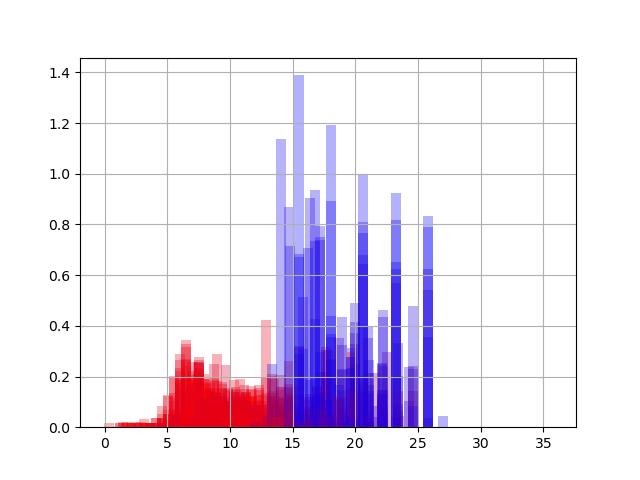

In [37]:
fig, ax = plt.subplots()
for i in range(0, len(epsilons)):
    n_bins_x = 30
    bin_edges_x = np.linspace(0, 1.2 * lbd_spls[i], n_bins_x + 1, endpoint=True)
    bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

    ax.bar(bin_center_x, color_values3[i], color=values2rgb(color_values2)[i], label=f'epsilon = {epsilons[i]}, lbd_spl = {lbd_spls[i]}, sig = {sigs[i]}')
ax.grid()
plt.show()

In [7]:
# read off data and histogram animation
from os import listdir
filenames = [f for f in listdir('evol_data/') if (f[:9] == "lbdvectt_")]

# system parameters
L_full = 10000   # system size
Drho = 0.1      # fixed
Dc = 1.0        # fixed 
T = 5.0         # fixed
# epsilon = 1e-2  # important
r = 1e-2        # important
# lbd_spl = 20.0  # important

# initial conditions
mu_fact = 0.85  # part of lbd_spl to start at
# sig = 5.0       # spread

# evolution parameters
n_steps = 100_000
dt = 1e1        # true dt is now adaptive. Save every dt

epsilon_range = np.logspace(-2, 0, 5, endpoint=True)
lbd_spl_range = np.linspace(12, 30, 7, endpoint=True)
sig_range     = [1.0, 5.0]

params_list = [(L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt) for lbd_spl in lbd_spl_range for epsilon in epsilon_range for sig in sig_range]
    
i = 26
# for params in tqdm(enumerate(params_list), total=len(params_list)):
params = params_list[i]
L_full, Drho, Dc, T, epsilon, r, lbd_spl, mu_fact, sig, n_steps, dt = params
kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)

print(f'{epsilon = :.2e}, {lbd_spl = :.2f}')
lbd_vect_t = np.load(f'/scratch/n/Natan.Dominko/SIP_data/lbdvecttA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy')
# adj_matr_t = np.load(f'/scratch/n/Natan.Dominko/SIP_data/adjmatrtA_{L_full:.0f}_{Drho:.1f}_{Dc:.1f}_{T:.1f}_{epsilon:.2e}_{r:.0e}_{lbd_spl:.2f}_{mu_fact:.2f}_{sig:.1f}_{n_steps:.0e}_{dt:.0e}.npy', allow_pickle=True)
t_range = np.arange(0, n_steps*dt, dt)

last_ind = np.max(np.where(np.any(lbd_vect_t > 0, axis=0))[0])

n_bins_x = 30
bin_edges_x = np.linspace(0, 1.2 * lbd_spl, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

# find true last time
last_ind = np.max(np.where(np.any(lbd_vect_t > 0, axis=0))[0])
end_vals = lbd_vect_t[lbd_vect_t[:, last_ind] > 0, last_ind]
end_hist, _ = np.histogram(end_vals, bins=bin_edges_x, density=True)


epsilon = 3.16e-01, lbd_spl = 18.00


/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSSteadyState.py:57: RuntimeWarning: overflow encountered in exp
  res = np.where((lbd > lbd_spl) & (lbd < lbd_inf), np.exp(-0.5*av_int.sol(lbd)), np.nan)


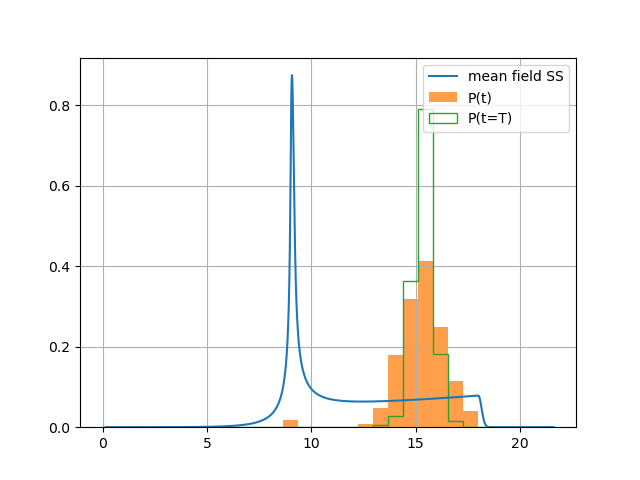

In [8]:
from matplotlib.animation import FuncAnimation

# Step 1: Generate initial data
stride = 10
data = lbd_vect_t[:,0:stride].flatten()

# Step 2: Create the figure and axis
fig, ax = plt.subplots()
ax.grid()
from MFKSSteadyState import get_P_ss
xss, Pss = get_P_ss(1.2*lbd_spl, kappa, k, eps, lbd_spl, r)
ax.plot(xss, Pss, label='mean field SS')

# Create the initial histogram (the first frame)
n_bins = 30
bin_edges = np.linspace(0, 1.2 * lbd_spl, n_bins + 1, endpoint=True)
bin_center = 0.5 * (bin_edges[1:] + bin_edges[:-1])
hist, bin_edges, patches = ax.hist(data[data > 0], bins=bin_edges, density=True, alpha=0.75,  label='P(t)')

ax.hist(lbd_vect_t[lbd_vect_t > 0].flatten(), bins=bin_edges, density=True, histtype='step', label='P(t=T)')
ax.legend()

# Step 3: Define the update function for animation
def update(frame):
    new_data = lbd_vect_t[:,frame*stride:(frame+1)*stride].flatten()  # Generate new data for each frame
    new_hist_values, _ = np.histogram(new_data[new_data > 0], bins=bin_edges, density=True)  # Calculate new histogram values

    # Update the heights of the histogram bars
    for patch, new_height in zip(patches, new_hist_values):
        patch.set_height(new_height)

    ax.set_xlim([0, 1.2 * lbd_spl])  # Fix x-axis limits
    ax.set_ylim([0, 0.5])  # Fix y-axis limits
    ax.set_title(f'{epsilon = :.2e}, {lbd_spl = :.2f}, time: {stride * frame * dt:.2e}')  # Display the current frame number

# Step 4: Create the animation
ani = FuncAnimation(fig, update, frames=500, interval=100)

# Show the animated plot
plt.show()


In [6]:
plt.close('all')

In [40]:
# full (linearized) system near eq., eigvals
import numpy as np
def get_matr(N):
    A = np.zeros((N,N))
    for i in range(N):
        if i < N-1:
            A[i, i+1] += 1
            A[i, i] -= 1
        if i > 0:
            A[i, i-1] += 1
            A[i, i] -= 1
    return A
        
import matplotlib.pyplot as plt
%matplotlib widget
fig, ax = plt.subplots()
for N in [100]:
    matr = get_matr(N)
    matr[:,np.arange(N)>int(0.7 * N)] *= -0.6
    # matr[:,np.arange(N)%4==0] *= -2.6
    print(matr)
    ax.plot(np.linspace(0, 1-1/N, N), np.sort(np.linalg.eigvals(matr))[::-1], 'o-') # 2*(1 - np.cos(np.pi*np.linspace(0, 1-1/N, N)))
ax.plot(np.linspace(0, 1-1/100, 100), -2*(1 - np.cos(np.pi*np.linspace(0, 1-1/100, 100))), 'k-')
ax.plot(np.linspace(0, 1-1/100, 100), 0.6*2*(1 - np.cos(np.pi*np.linspace(0, 1-1/100, 100)))[::-1], 'r-')
ax.vlines(0.3, -3, 3, 'g')
ax.grid()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[-1.   1.   0.  ... -0.  -0.  -0. ]
 [ 1.  -2.   1.  ... -0.  -0.  -0. ]
 [ 0.   1.  -2.  ... -0.  -0.  -0. ]
 ...
 [ 0.   0.   0.  ...  1.2 -0.6 -0. ]
 [ 0.   0.   0.  ... -0.6  1.2 -0.6]
 [ 0.   0.   0.  ... -0.  -0.6  0.6]]


In [30]:
from scipy.stats import gaussian_kde
def KDE_with_error(data, x_eval, bandwidth, n_bootstraps):
    # Perform KDE
    kde = gaussian_kde(data, bw_method=bandwidth)
    pdf = kde.evaluate(x_eval)
    
    # Bootstrap to estimate the errors
    bootstrap_pdfs = np.zeros((n_bootstraps, len(x_eval)))
    
    for i in tqdm(range(n_bootstraps)):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde_sample = gaussian_kde(sample, bw_method=bandwidth)
        bootstrap_pdfs[i, :] = kde_sample.evaluate(x_eval)
    
    # Calculate the standard error of the KDE estimates
    pdf_std_error = np.std(bootstrap_pdfs, axis=0)
    return pdf, pdf_std_error


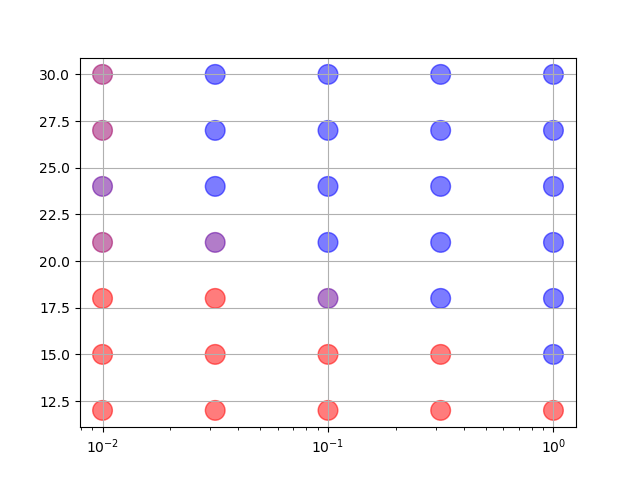

In [62]:
# phase diagram plots
from os import listdir
filenames = [f for f in listdir('evol_data/') if (f[:9] == "lbdvectt_")]
# print(f"Files in current directory: {filenames}")

fig, ax = plt.subplots()
epsilons = []    
lbd_spls = []
sigs = []
color_values = []
color_values2 = []
for filename in filenames:
    
    lbd_vect_t = np.load('evol_data/' + filename)
    param_strings = filename.split('_')
    epsilon = float(param_strings[1])
    lbd_spl = float(param_strings[2])
    L_full  = float(param_strings[3])
    mu_fact = float(param_strings[4])
    sig     = float(param_strings[5])
    n_steps = int(float(param_strings[6]))
    dt      = float(param_strings[7])
    stride_save = int(float(param_strings[8][:-4]))

    if n_steps != 1000000:
        continue

    n_bins_x = 30
    bin_edges_x = np.linspace(0, 1.2 * lbd_spl, n_bins_x + 1, endpoint=True)
    bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

    end_vals = lbd_vect_t[lbd_vect_t[:, -1] > 0, -1]
    end_hist, _ = np.histogram(end_vals, bins=bin_edges_x, density=True)
    
    mean = np.trapz(end_hist * bin_center_x, bin_center_x)
    stdev= np.sqrt(np.trapz(end_hist * (mean - bin_center_x)**2, bin_center_x)) / lbd_spl
    # print(f'{epsilon = :.2e}, {lbd_spl = :.2f}, {stdev}')

    epsilons.append(epsilon)    
    lbd_spls.append(lbd_spl)
    sigs.append(sig)
    color_values.append(stdev)
    color_values2.append(np.sum((lbd_vect_t < 5) * (lbd_vect_t > 0)))

# scatter = ax.scatter(epsilons, [lbd_spls[i] + 0.5 * (sigs[i] - 1) / 4 for i in range(len(lbd_spls))], c=color_values, s=200, cmap='coolwarm')
# scatter = ax.scatter(epsilons, [lbd_spls[i] + 0.5 * (sigs[i] - 1) / 4 for i in range(len(lbd_spls))], c=[np.log(_l+1) for _l in color_values2], s=200, cmap='bwr')
scatter = ax.scatter(epsilons, lbd_spls, c=[(1,0,0,0.3) if _c > 0.1 else (0,0,1,0.3) for _c in color_values], s=200)
# fig.colorbar(scatter, ax=ax)
ax.grid()
ax.set_xscale('log')
plt.show()


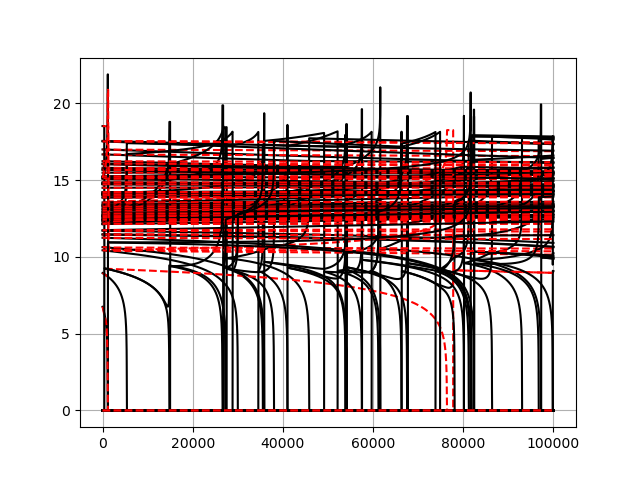

In [232]:
fig, ax = plt.subplots()
for i in range(Nmax):
    ax.plot(t_range, lbd_vect_t[i, :], 'k-')
    ax.plot(t_range, lbd_vect_t_2[i, :], 'r--')
    # ax.plot(sol.t, sol.y[i, :], 'r--')
# ax.plot(t_range, np.sum(lbd_vect_t, axis=0))

ax.grid()
plt.show()

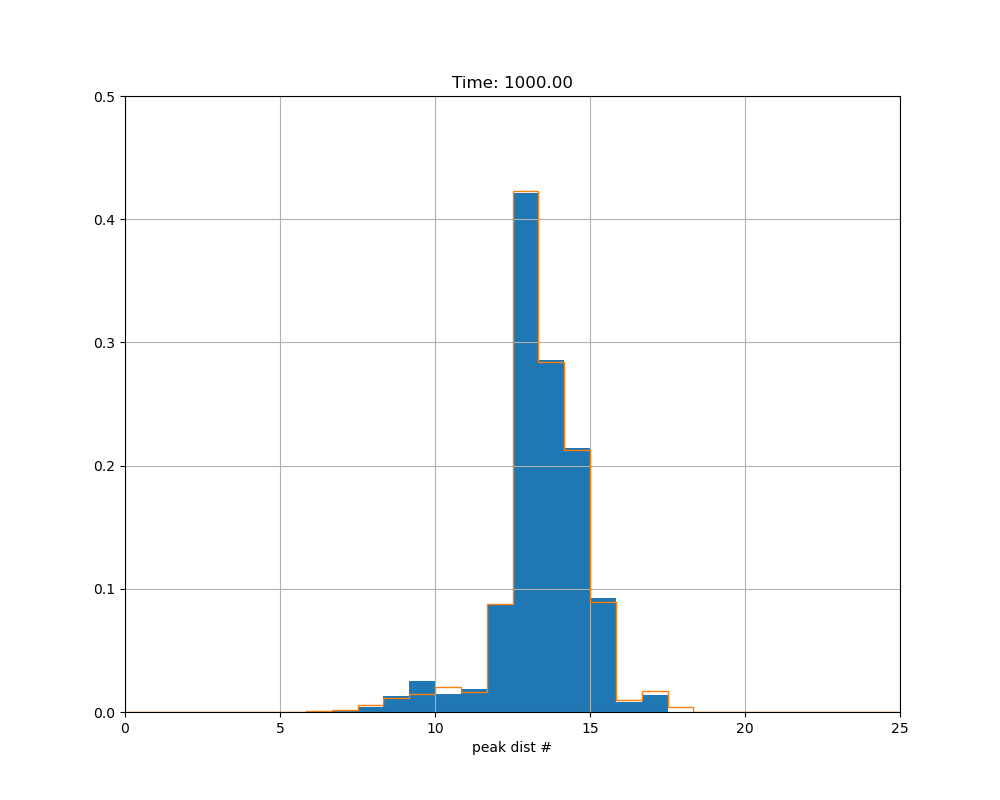

In [211]:
n_bins_x = 30
bin_edges_x = np.linspace(0, 25, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])


fig = plt.figure(figsize=(10,8))
k = 100
plt.hist(lbd_vect_t[lbd_vect_t > 0], bins=bin_edges_x, density=True)
plt.hist(lbd_vect_t_2[lbd_vect_t_2 > 0], bins=bin_edges_x, density=True, histtype='step')
# plt.plot(bin_center_x, KDE_with_error(lbd_vect_t[lbd_vect_t > 0], bin_center_x, bandwidth=None, n_bootstraps=100)[0])
plt.title(f'Time: {t_range[k]:.2f}')
plt.xlabel('peak dist #')
plt.xlim(0, 25)
plt.ylim(0, 0.5)
plt.grid()
plt.show()

In [33]:
plt.close('all')
print(np.shape(lbd_vect_t))

(66, 1000)


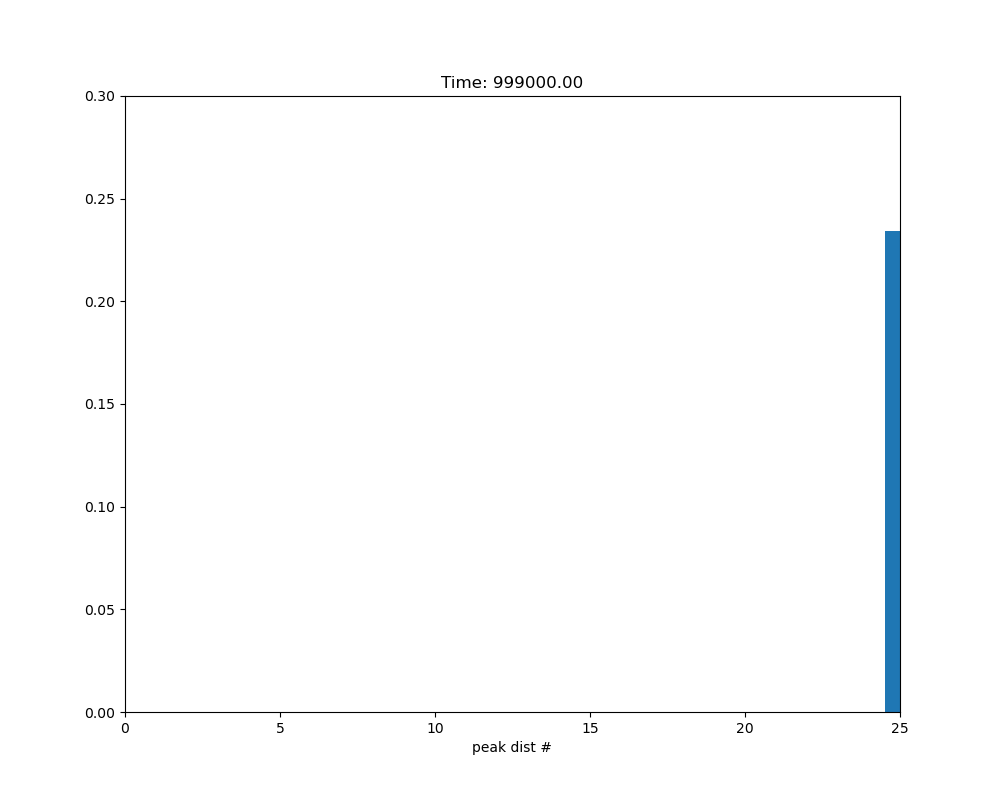

No such comm: 9daeca8d9d04430387f650d5ecc84eb2


In [27]:
n_bins_x = 40
bin_edges_x = np.linspace(0, 35, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

from matplotlib.animation import FuncAnimation

# Animation function
plt.close('all')
def animate(k):
    plt.cla()
    plt.hist(lbd_vect_t[lbd_vect_t[:, k] > 0, k], bins=bin_edges_x, density=True)
    # plt.plot(bin_center_x, KDE_with_error(lbd_vect_t[lbd_vect_t[:, k] > 0, k], bin_center_x, bandwidth=None, n_bootstraps=100)[0])
    plt.title(f'Time: {t_range[k]:.2f}')
    plt.xlabel('peak dist #')
    plt.xlim(0, 25)
    plt.ylim(0, 0.3)

# Create animation
fig = plt.figure(figsize=(10,8))
ani = FuncAnimation(fig, animate, frames=n_steps // stride_save, interval=1)
ani.save('distances_hist_model4.gif', writer='imagemagick', fps=10)# Display animation
# plt.show()

In [30]:
def get_kymograph(lbd_vect, adj_matr):
    n_particles = np.sum(np.diag(adj_matr) == -2) + 2
    kymograph = np.zeros((len(lbd_vect)))
    start_ind = np.where(np.diag(adj_matr) == -1)[0][0]
    visited_inds = [start_ind]
    kymograph[1] = lbd_vect[start_ind]
    visited_inds.append(sparse_find_neighbors(adj_matr, start_ind)[0])
    for i in range(2, n_particles):
        kymograph[i] = kymograph[i-1] + lbd_vect[visited_inds[-1]]
        next_possible_inds = sparse_find_neighbors(adj_matr, visited_inds[-1])[0]
        if next_possible_inds[0] == visited_inds[-2]:
            visited_inds.append(next_possible_inds[1])
        elif next_possible_inds[1] == visited_inds[-2]:
            visited_inds.append(next_possible_inds[0])
        else:
            raise ValueError('Should not come to this')
    kymograph[n_particles] = kymograph[n_particles - 1] + lbd_vect[visited_inds[-1]]
    return kymograph
print(np.sum(lbd_vect))
print(lbd_vect)
print(adj_matr)
print(get_kymograph(lbd_vect, adj_matr))

1000.0000000000007
[12.91069908  8.08820588 14.90306316  8.52680309 10.21446943 14.71406534
 15.04969929  0.          8.06964117 14.55203422 16.43542489 14.23731317
 10.22048857  8.67489087 14.61743276  8.13231943 14.61196576 13.22759565
 13.32274871  8.20358983  8.65986233  0.          7.59736125  9.51856909
  0.         15.31137762  5.91574354 14.23406709  6.10057163  8.605213
 11.5768084   9.27780923 10.56659691 14.64879418  9.16801584 13.98827579
 14.50666308  7.86618918  8.53026008  9.01302862  8.54159715  9.36806176
  8.95089114 12.2684424   0.          7.39095759 13.87575589  8.60753309
 10.13694834 12.22209965 14.66754966 12.66819047 12.75556879 13.7600509
  9.82501132  4.43708064  7.22373791  8.8946454   8.34772575 13.19567799
  0.         12.75500036  8.83480276  6.90909186 12.05684966  8.70420544
  8.12049413 10.03021085 11.91452506 15.1196808  13.33720265 13.01652224
 10.97326835 11.19733702  7.72824783  8.82927264 16.00555668  8.04595293
  0.          9.8810067  12.2759537

ValueError: Input must be 1- or 2-d.

In [55]:
import numpy as np
from scipy.sparse import csr_matrix

# Example: an array of adjacency matrices over time (undirected chain graphs)
n_time = 5
adj_matr_t = [
    csr_matrix([
        [0, 1, 0, 0], 
        [1, 0, 1, 0], 
        [0, 1, 0, 1], 
        [0, 0, 1, 0]  
    ]),
    csr_matrix([
        [0, 1, 0, 0], 
        [1, 0, 1, 0], 
        [0, 1, 0, 1], 
        [0, 0, 1, 0]  
    ]),  # Same as previous, should reuse order
    csr_matrix([
        [0, 1, 0, 0], 
        [1, 0, 1, 0], 
        [0, 1, 0, 0], 
        [0, 0, 0, 0]  
    ]),  # Different structure, new order
    csr_matrix([
        [0, 1, 0, 0], 
        [1, 0, 1, 0], 
        [0, 1, 0, 1], 
        [0, 0, 1, 0]  
    ]),  # Same as initial, reuse order
    csr_matrix([
        [0, 1, 0, 0], 
        [1, 0, 1, 0], 
        [0, 1, 0, 1], 
        [0, 0, 1, 0]  
    ])  # Different again
]

# Traversal function (same as before)
def traverse_chain(adj_matr, start_node):
    visited = set()  # Keep track of visited nodes
    order = [start_node]
    visited.add(start_node)
    current_node = start_node
    
    while len(visited) < adj_matr.shape[0]:
        # Find the neighbors of the current node
        neighbors = adj_matr[current_node].nonzero()[1]
        
        # Select the next neighbor that hasn't been visited
        for neighbor in neighbors:
            if neighbor not in visited:
                order.append(neighbor)
                visited.add(neighbor)
                current_node = neighbor
                break
    
    return order

# Function to compute orders over time
def compute_orders_over_time(adj_matr_t):
    n_time = len(adj_matr_t)
    orders = [None] * n_time  # Array to store the order at each time step
    previous_order = None
    previous_adj_matr = None
    
    for t in range(n_time):
        current_adj_matr = adj_matr_t[t]
        
        # Step 1: Check if the current adjacency matrix is different from the previous one
        if (previous_adj_matr is not None) and (current_adj_matr != previous_adj_matr).nnz == 0:
            # If the adjacency matrix hasn't changed, reuse the previous order
            orders[t] = previous_order
            print(f"Time {t}: Reusing previous order.")
        else:
            # Recompute the chain order for the current time step
            degrees = np.array(current_adj_matr.sum(axis=1)).flatten()
            start_node = np.where(degrees == 1)[0][0]  # Find a node with degree 1 (start node)
            current_order = traverse_chain(current_adj_matr, start_node)
            
            # Store the order and update the previous values
            orders[t] = current_order
            previous_order = current_order
            previous_adj_matr = current_adj_matr
            print(f"Time {t}: Recomputing order.")
    
    return orders

# Compute the orders for each time step
orders = compute_orders_over_time(adj_matr_t)

# Output results
for t, order in enumerate(orders):
    print(f"Time {t} order: {order}")


Time 0: Recomputing order.
Time 1: Reusing previous order.


KeyboardInterrupt: 

In [31]:
kymo_t = np.zeros_like(lbd_vect_t)
for i in tqdm(range(n_steps // stride_save)):
    kymo_t[:, i] = get_kymograph(lbd_vect_t[:, i], adj_matr_t[i])

  0%|          | 0/1000 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

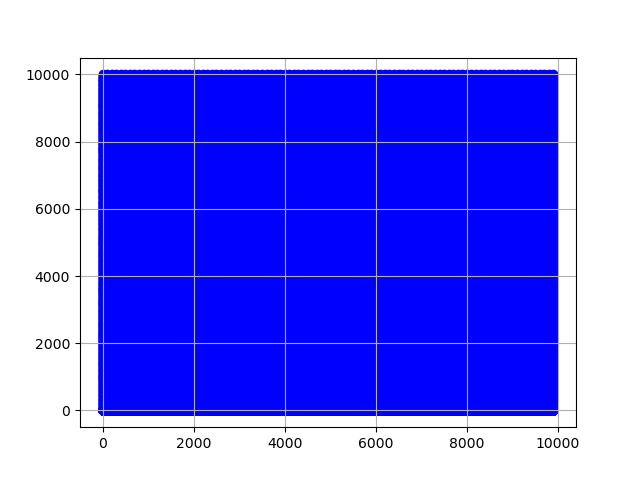

In [12]:
fig, ax = plt.subplots()
for i in range(Nmax):
    ax.scatter(t_range, kymo_t[i, :], color='blue')

ax.grid()
plt.show()

## Trash

In [ ]:
class StochIntParticles:

    def __init__(self, Drho, Dc, T, epsilon, r, lbd_spl, L_full, mu_fact, sig, Nmax_fact=2):
        self.Drho   = Drho
        self.Dc     = Dc
        self.T      = T
        self.epsilon= epsilon
        self.r      = r
        self.lbd_spl= lbd_spl
        self.L_full = L_full
        self.mu_fact= mu_fact
        self.sig    = sig
        self.Nmax_fact= Nmax_fact
        self.kappa, self.k, self.eps, self._lbd_spl, _ = reparameterize(self.Drho, self.Dc, self.T, self.epsilon, self.r)
        self.current_time = 0
        self.t_range = []
        self.set_initials()
        self.lbd_vect = self.lbd_vect_ini
        self.adj_matr = self.adj_matr_ini
        self.lbd_vect_t = []
        self.adj_matr_t = []
        
    def set_initials(self):
        self.Nmax = int(self.Nmax_fact * self.L_full / self.lbd_spl)
        self.n_ini = int(self.L_full / self.lbd_spl / self.mu_fact)

        self.lbd_vect_ini = np.zeros((self.Nmax))
        self.adj_matr_ini = np.zeros((self.Nmax, self.Nmax), dtype=int)

        # prepare initials
        for i in range(self.Nmax):
            if np.sum(self.lbd_vect_ini) < self.L_full:
                self.lbd_vect_ini[i] = self.L_full / self.n_ini + self.sig * np.random.randn()
                self.adj_matr_ini[i, i+1] = 1
                self.adj_matr_ini[i, i] += -1
                if i > 0:
                    self.adj_matr_ini[i, i-1] = 1
                    self.adj_matr_ini[i, i] += -1
            
            else:
                self.lbd_vect_ini[i-1] = 0
                self.lbd_vect_ini[i-1] = self.L_full - np.sum(self.lbd_vect_ini)
                self.adj_matr_ini[i-1, i] = 0
                self.adj_matr_ini[i-1, i-1] += 1
                break

    def sparse_find_neighbors(self, node):
        return self.sparse_adj_matr[node].indices[self.sparse_adj_matr[node].data == 1]

    def split(self, ind_split):
        # get another empty index
        ind_split2 = np.where(self.adj_matr.diagonal() == 0)[0][0]

        # set lbd_vect
        split_val = 0.5 * self.lbd_vect[ind_split]
        for ind in [ind_split, ind_split2]:
            self.lbd_vect[ind] = split_val
        
        # set adj_matr
        ind_neighbor = self.sparse_find_neighbors(ind_split)[0]
        
        self.adj_matr[ind_split, ind_neighbor] = 0
        self.adj_matr[ind_neighbor, ind_split] = 0

        self.adj_matr[ind_neighbor, ind_split2] = 1
        self.adj_matr[ind_split2, ind_neighbor] = 1

        self.adj_matr[ind_split, ind_split2] = 1
        self.adj_matr[ind_split2, ind_split] = 1
        
        self.adj_matr[ind_split2, ind_split2] = -2

    def fix_negative(self):
        while np.any(self.lbd_vect < 0): # here can put some constant to make it faster
            ind_negative = np.argmin(self.lbd_vect)
            inds_neighbors = self.sparse_find_neighbors(self.adj_matr, ind_negative) 
            if len(inds_neighbors) == 2:
                ind_neighbor1 = inds_neighbors[0]
                ind_neighbor2 = inds_neighbors[1]
                
                self.adj_matr[ind_neighbor1, ind_neighbor2] = 1
                self.adj_matr[ind_neighbor2, ind_neighbor1] = 1
                
                self.adj_matr[ind_neighbor1, ind_negative] = 0
                self.adj_matr[ind_negative, ind_neighbor1] = 0
                
                self.adj_matr[ind_negative, ind_neighbor2] = 0
                self.adj_matr[ind_neighbor2, ind_negative] = 0

                self.adj_matr[ind_negative, ind_negative] = 0

                self.lbd_vect[ind_neighbor1] += 0.5 * self.lbd_vect[ind_negative]
                self.lbd_vect[ind_neighbor2] += 0.5 * self.lbd_vect[ind_negative]

            elif len(inds_neighbors) == 1:
                ind_neighbor1 = inds_neighbors[0]
                
                self.adj_matr[ind_neighbor1, ind_negative] = 0
                self.adj_matr[ind_negative, ind_neighbor1] = 0
                
                self.adj_matr[ind_negative, ind_negative] = 0
                self.adj_matr[ind_neighbor1, ind_neighbor1] = -1

                self.lbd_vect[ind_neighbor1] += self.lbd_vect[ind_negative]

            else:
                raise ValueError(f"Adjacency matrix has {len(inds_neighbors)} neighbors. ")

            # set lbd_vect
            self.lbd_vect[ind_negative] = 0
            self.adj_matr[ind_negative, ind_negative] = 0

    def g(self, lbd, kappa, k, eps):
        return 0.5 * kappa * np.exp(-k * lbd) + eps * lbd

    def rhs(self):
        return self.adj_matr @ self.g(self.lbd_vect, self.kappa, self.k, self.eps)
    
    def evolve(self, n_steps, dt, stride_save, random_uniform_array):

        for i in tqdm(range(1, n_steps)):
            # handle splitting
            potential_split_inds = np.where(self.lbd_vect > self.lbd_spl)[0]
            for j, potential_split_ind in enumerate(potential_split_inds):
                if random_uniform_array[i, j] < dt * self.r * (self.lbd_vect[potential_split_ind] - self.lbd_spl):
                    self.lbd_vect, self.adj_matr = self.split(potential_split_ind)
            # handle dynamics
            self.lbd_vect += dt * self.rhs()
            self.fix_negative()

            if i % stride_save == 0:
                self.current_time += dt * stride_save
                self.lbd_vect_t.append(self.lbd_vect)
                self.adj_matr_t.append(self.adj_matr)


In [ ]:
sys = StochIntParticles(Drho = 0.1,
                  Dc = 1.0,
                  T = 5.0,
                  epsilon = 1e-2,
                  r = 1e-2,
                  lbd_spl = 17.5,
                  L_full = 1000,
                  mu_fact = 0.85,
                  sig = 1
)
sys.evolve(n_steps = 1000000,
           dt = 1e-2,
           stride_save = 1000,
           random_uniform_array = np.random.uniform(0, 1, (1000000, sys.Nmax)))
